<a href="https://colab.research.google.com/github/fidanfatih/Pycoders_Capstone/blob/main/Pycoders_AutoScout_23022022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
    ** In this notebook, We will make EDA in 3 stages.**

    . Part-1 : Data Cleansing. It deals with Incorrect Headers, Incorrect Format, Anomalies, Dropping useless columns
    
    . Part-2 : Filling Columns. It deals with Missing Values. Categorical to numeric transformation will be done.

    . Part-3 : Outliers and Final review 

## Import Libraries and Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import gc

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")
pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_info_rows', 2000)
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.width', 2000)
sns.set_style("whitegrid")
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AutoScout24/autoscout_data_2000.csv')
df = data.copy()
df.shape

(71104, 49)

## METHODS


In [ ]:
def show_nans(df, limit=0):
    missing = df.isnull().sum()*100/df.shape[0]
    return missing.loc[lambda x : x >= limit]

def perc_nans(serial):
    # display percentage of nans in a Series
    return serial.isnull().sum()/serial.shape[0]*100

def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)

def v_counts(df, s):
  s1 = df[s].value_counts(dropna=False)
  s2 = df[s].value_counts(dropna=False, normalize=True)*100
  multicol1 = pd.MultiIndex.from_tuples([(s, 'COUNT'),
                                       (s, 'RATE')])
  s3 = pd.concat([s1, s2], axis=1, keys=multicol1)
  return s3

In [ ]:
def pol_twin(df, col, target, figsize=(10,6)):
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111)
  df[col].value_counts(dropna=False, normalize=True).sort_index().plot.bar(ax= ax)
  ax_twin = ax.twinx()
  df.groupby(col)[target].mean().plot.line(ax=ax_twin, color='red', marker='o', ms=10)
  # ax.grid()
  h1, l1 = ax.get_legend_handles_labels()
  h2, l2 = ax_twin.get_legend_handles_labels()
  ax.legend(h1+h2, l1+l2, loc=2)
  fig.tight_layout();

In [ ]:
def simplify_column(s, threshold=0.001, value='mode'):
  """
  reduction of diversity
  """
  s = s.replace(s.value_counts(dropna=True)[s.value_counts(dropna=True, normalize=True)<threshold].index,s.mode()[0] if value=='mode' else value)
  return s

In [ ]:
import scipy.stats as sts

# References:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramers_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def corrank(X, threshold=0):
    rows= []
    for var1 in X:
      col = []
      for var2 in X :
        cramers =cramers_v(X[var1], X[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
      rows.append(col)
    cramers_results = np.array(rows)
    corr_matrix = pd.DataFrame(cramers_results, columns = X.columns, index =X.columns)

    import itertools
    df = pd.DataFrame([[i,j,corr_matrix.abs().loc[i,j]] for i,j in list(itertools.combinations(corr_matrix.abs(), 2))],columns=['Feature1','Feature2','corr'])    
    df = df.sort_values(by='corr',ascending=False).reset_index(drop=True)
    return df[df['corr']>threshold]

## Check Data

In [ ]:
df.head(2)

,location,url,make,model,short_description,price,mileage,gearbox,registration,fuel_type,power,seller,body_type,type,drivetrain,seats,doors,country_version,offer_number,warranty,Mileage,first_registration,production_date,general_inspection,last_service,full_service_history,non_smoker_vehicle,previous_owner,last_timing_belt_change,Power,Gearbox,engine_size,gears,cylinders,empty_weight,Fuel_type,fuel_consumption,co2_emissions,emission_class,emissions_sticker,\nComfort & Convenience\n,\nEntertainment & Media\n,\nSafety & Security\n,extras,\ncolour,\nmanufacturer_color,\npaint,upholstery_colour,upholstery
0,"LOON OP ZAND, NL",https://www.autoscout24.com/offers/audi-a3-2-0-fsi-ambition-pro-line-gasoline-grey-11c36265-2a5c-41e7-8d4f-0bc7177ee8e9?source=list_searchresults,"\n,Audi ,\n","\n,A3,\n",2.0 FSI Ambition Pro Line,"[['\n', '€ 4,450.-', '\n']]","['', ['191,066 km']]","\n,Automatic,\n",08/2003,"\n,Gasoline,\n","110 kW (150 hp),","['\n', ['Dealer\n']]","\n,Compact,\n","\n,Used,\n","\n,Front,\n",\n5,\n3,"Country version,None",\nSJ-112-R,"\n,6 months,\n","[['\n'], ['']]",08/2003,None,05/2022,None,"\n,Yes,\n","\n,None,\n","[['\n'], ['None']]","[['\n'], ['None']]","\n,110 kW (150 hp),\n","\n,Automatic,\n","\n,1,984 cc,\n","\n,None,\n","\n,4,\n","\n,1,280 kg,\n","\n,Super 95,\n","\n,None,\n","['\n', [' ', ' ', ' '], '\n']","\n,Euro 4,\n","\n,None,\n","[['Air conditioning', 'Armrest', 'Automatic climate control', 'Electrical side mirrors', 'Navigation system', 'Power windows', 'Sunroof']]","[['CD player', 'Radio']]","[['ABS', 'Alarm system', 'Central door lock', 'Central door lock with remote control', 'Driver-side airbag', 'Electronic stability control', 'Fog lights', 'Head airbag', 'Immobilizer', 'Passenger-side airbag', 'Power steering', 'Side airbag', 'Traction contro']]",[['Alloy wheels']],"\n4, Grey",None,"\npaint, Metallic","\nupholstery, Black","\n8, Cloth"
1,"HEERLEN, NL",https://www.autoscout24.com/offers/audi-a3-sportback-1-4-tfsi-ambiente-ecc-pdc-lichtmetaal-gasoline-white-7ff92ad1-e356-4c2c-8308-b008d4c9d6c4?source=list_searchresults,"\n,Audi ,\n","\n,A3,\n",Sportback 1.4 TFSI Ambiente/ECC/PDC//Lichtmetaal//,"[['\n', '€ 12,950.-', '\n']]","['', ['94,758 km']]","\n,Automatic,\n",10/2013,"\n,Gasoline,\n","92 kW (125 hp),","['\n', ['Dealer\n']]","\n,Compact,\n","\n,Used,\n","\n,Front,\n",\n5,\n5,"Country version,None",\n809725,"\n,None,\n","[['\n'], ['']]",10/2013,None,None,None,"\n,Yes,\n","\n,None,\n","[['\n'], ['None']]","[['\n'], ['None']]","\n,92 kW (125 hp),\n","\n,Automatic,\n","\n,1,395 cc,\n","\n,None,\n","\n,4,\n","\n,1,200 kg,\n","\n,Gasoline,\n","['\n', ['4.9 l/100 km (comb.)', ' ', ' '], '\n']","\n,None,\n","\n,None,\n","\n,None,\n","[['Air conditioning', 'Automatic climate control', 'Electrical side mirrors', 'Light sensor', 'Power windows', 'Rain sensor']]","[['CD player', 'Radio']]","[['Alarm system', 'Central door lock', 'Central door lock with remote control', 'Fog lights', 'Immobilizer']]","[['Alloy wheels (16"")']]","\n4, White",None,None,"\nupholstery, Black","\n8, Cloth"


In [ ]:
df = df.replace("None",np.nan)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71104 entries, 0 to 71103
Data columns (total 49 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   location                 object 
 1   url                      object 
 2   make                     object 
 3   model                    object 
 4   short_description        object 
 5   price                    object 
 6   mileage                  object 
 7   gearbox                  object 
 8   registration             object 
 9   fuel_type                object 
 10  power                    object 
 11  seller                   object 
 12  body_type                object 
 13  type                     object 
 14  drivetrain               object 
 15  seats                    object 
 16  doors                    object 
 17  country_version          object 
 18  offer_number             object 
 19  warranty                 object 
 20  Mileage                  object 
 21  first_regist

In [ ]:
list(df.columns)

['location',
 'url',
 'make',
 'model',
 'short_description',
 'price',
 'mileage',
 'gearbox',
 'registration',
 'fuel_type',
 'power',
 'seller',
 'body_type',
 'type',
 'drivetrain',
 'seats',
 'doors',
 'country_version',
 'offer_number',
 'warranty',
 'Mileage',
 'first_registration',
 'production_date',
 'general_inspection',
 'last_service',
 'full_service_history',
 'non_smoker_vehicle',
 'previous_owner',
 'last_timing_belt_change',
 'Power',
 'Gearbox',
 'engine_size',
 'gears',
 'cylinders',
 'empty_weight',
 'Fuel_type',
 'fuel_consumption',
 'co2_emissions',
 'emission_class',
 'emissions_sticker',
 '\nComfort & Convenience\n',
 '\nEntertainment & Media\n',
 '\nSafety & Security\n',
 'extras',
 '\ncolour',
 '\nmanufacturer_color',
 '\npaint',
 ' upholstery_colour ',
 ' upholstery ']

In [ ]:
df.isnull().sum()

location                         0
url                              0
make                             0
model                            0
short_description              169
price                            0
mileage                          0
gearbox                          0
registration                    40
fuel_type                        0
power                            0
seller                           0
body_type                        0
type                             0
drivetrain                       0
seats                            0
doors                            0
country_version                  0
offer_number                     0
warranty                         0
Mileage                          0
first_registration              40
production_date              63688
general_inspection           17024
last_service                 71104
full_service_history             0
non_smoker_vehicle               0
previous_owner                   0
last_timing_belt_cha

In [ ]:
show_nans(df)

location                       0.000000
url                            0.000000
make                           0.000000
model                          0.000000
short_description              0.237680
price                          0.000000
mileage                        0.000000
gearbox                        0.000000
registration                   0.056256
fuel_type                      0.000000
power                          0.000000
seller                         0.000000
body_type                      0.000000
type                           0.000000
drivetrain                     0.000000
seats                          0.000000
doors                          0.000000
country_version                0.000000
offer_number                   0.000000
warranty                       0.000000
Mileage                        0.000000
first_registration             0.056256
production_date               89.570207
general_inspection            23.942394
last_service                 100.000000


## Cleaning Target Feature (Price)

In [ ]:
df.price.value_counts(dropna=False).sample(10)

[['\n', '€ 8,100.-', '\n']]      3
[['\n', '€ 9,941.-', '\n']]      3
[['\n', '€ 21,840.-', '\n']]     8
[['\n', '€ 55,681.-', '\n']]     2
[['\n', '€ 51,850.-', '\n']]     7
[['\n', '€ 29,738.-', '\n']]     1
[['\n', '€ 117,995.-', '\n']]    1
[['\n', '€ 8,888.-', '\n']]      7
[['\n', '€ 78,875.-', '\n']]     1
[['\n', '€ 28,899.-', '\n']]     1
Name: price, dtype: int64

In [ ]:
df.price = df.price.str.extract('€ (\d*\,*\d*).-')[0].str.replace(",",'').astype('float')
df.price

0         4450.0
1        12950.0
2        12445.0
3        12450.0
4        14945.0
          ...   
71099     1999.0
71100     3950.0
71101     3449.0
71102     1650.0
71103      944.0
Name: price, Length: 71104, dtype: float64

In [ ]:
perc_nans(df.price)

2.2108460846084608

In [ ]:
df = df.dropna(subset=['price'])

# Alternative
# df = df.iloc[df[df.price.notna()==True].index,:]

In [ ]:
perc_nans(df.price)

0.0

In [ ]:
df.shape

(69532, 49)

## Percentages of Null Data

In [ ]:
show_nans(df)

location                       0.000000
url                            0.000000
make                           0.000000
model                          0.000000
short_description              0.238739
price                          0.000000
mileage                        0.000000
gearbox                        0.000000
registration                   0.057527
fuel_type                      0.000000
power                          0.000000
seller                         0.000000
body_type                      0.000000
type                           0.000000
drivetrain                     0.000000
seats                          0.000000
doors                          0.000000
country_version                0.000000
offer_number                   0.000000
warranty                       0.000000
Mileage                        0.000000
first_registration             0.057527
production_date               89.603348
general_inspection            24.053673
last_service                 100.000000


In [ ]:
df.head(1)

,location,url,make,model,short_description,price,mileage,gearbox,registration,fuel_type,power,seller,body_type,type,drivetrain,seats,doors,country_version,offer_number,warranty,Mileage,first_registration,production_date,general_inspection,last_service,full_service_history,non_smoker_vehicle,previous_owner,last_timing_belt_change,Power,Gearbox,engine_size,gears,cylinders,empty_weight,Fuel_type,fuel_consumption,co2_emissions,emission_class,emissions_sticker,\nComfort & Convenience\n,\nEntertainment & Media\n,\nSafety & Security\n,extras,\ncolour,\nmanufacturer_color,\npaint,upholstery_colour,upholstery
0,"LOON OP ZAND, NL",https://www.autoscout24.com/offers/audi-a3-2-0-fsi-ambition-pro-line-gasoline-grey-11c36265-2a5c-41e7-8d4f-0bc7177ee8e9?source=list_searchresults,"\n,Audi ,\n","\n,A3,\n",2.0 FSI Ambition Pro Line,4450.0,"['', ['191,066 km']]","\n,Automatic,\n",08/2003,"\n,Gasoline,\n","110 kW (150 hp),","['\n', ['Dealer\n']]","\n,Compact,\n","\n,Used,\n","\n,Front,\n",\n5,\n3,"Country version,None",\nSJ-112-R,"\n,6 months,\n","[['\n'], ['']]",08/2003,NaN,05/2022,NaN,"\n,Yes,\n","\n,None,\n","[['\n'], ['None']]","[['\n'], ['None']]","\n,110 kW (150 hp),\n","\n,Automatic,\n","\n,1,984 cc,\n","\n,None,\n","\n,4,\n","\n,1,280 kg,\n","\n,Super 95,\n","\n,None,\n","['\n', [' ', ' ', ' '], '\n']","\n,Euro 4,\n","\n,None,\n","[['Air conditioning', 'Armrest', 'Automatic climate control', 'Electrical side mirrors', 'Navigation system', 'Power windows', 'Sunroof']]","[['CD player', 'Radio']]","[['ABS', 'Alarm system', 'Central door lock', 'Central door lock with remote control', 'Driver-side airbag', 'Electronic stability control', 'Fog lights', 'Head airbag', 'Immobilizer', 'Passenger-side airbag', 'Power steering', 'Side airbag', 'Traction contro']]",[['Alloy wheels']],"\n4, Grey",NaN,"\npaint, Metallic","\nupholstery, Black","\n8, Cloth"


## Rename Columns

In [ ]:
df.columns

Index(['location', 'url', 'make', 'model', 'short_description', 'price', 'mileage', 'gearbox', 'registration', 'fuel_type', 'power', 'seller', 'body_type', 'type', 'drivetrain', 'seats', 'doors', 'country_version', 'offer_number', 'warranty', 'Mileage', 'first_registration', 'production_date', 'general_inspection', 'last_service', 'full_service_history', 'non_smoker_vehicle', 'previous_owner', 'last_timing_belt_change', 'Power', 'Gearbox', 'engine_size', 'gears', 'cylinders', 'empty_weight', 'Fuel_type', 'fuel_consumption', 'co2_emissions', 'emission_class', 'emissions_sticker', '\nComfort & Convenience\n', '\nEntertainment & Media\n', '\nSafety & Security\n', 'extras', '\ncolour', '\nmanufacturer_color', '\npaint', ' upholstery_colour ', ' upholstery '], dtype='object')

In [ ]:
df.rename(columns={
                  "\nComfort & Convenience\n":"comfort_convenience",
                  "\nEntertainment & Media\n":"entertainment_media",
                  "\nSafety & Security\n":"safety_security",
                  "\ncolour":"colour",
                  "\nmanufacturer_color":"manufacturer_color",
                  "\npaint":"paint",
                  " upholstery_colour ":"upholstery_colour",
                  " upholstery ":"upholstery" },inplace=True)

# 1-Data Cleansing

> Open a header for all columns

## location

In [ ]:
df.location.value_counts(dropna=False)

ROTTERDAM, NL              1542
APELDOORN, NL              1232
AMSTERDAM, NL              1019
TILBURG, NL                 947
ALKMAAR, NL                 737
                           ... 
Rojales, NL                   1
Zuid Holland, NL              1
Berkel En Rodenrijs, NL       1
HOENZADRIEL, NL               1
Utrechtse Heuvelrug, NL       1
Name: location, Length: 2444, dtype: int64

In [ ]:
df.location = df.location.str.strip(", NL")
df.location = df.location.str.title()

In [ ]:
perc_nans(df.location)

0.0

In [ ]:
v_counts(df,'location')

location          
                       COUNT      RATE
Rotterdam               1744  2.508198
Apeldoor                1232  1.771846
Amsterdam               1211  1.741644
Tilburg                 1062  1.527354
Alkmaar                  776  1.116033
...                      ...       ...
Ferwerd                    1  0.001438
Eiden / Oegstgeest         1  0.001438
Well                       1  0.001438
Ruinen                     1  0.001438
Utrechtse Heuvelrug        1  0.001438

[1808 rows x 2 columns]

## make

In [ ]:
perc_nans(df.make)

0.0

In [ ]:
df.make.value_counts(dropna=False)

\n,BMW ,\n              7647
\n,Volkswagen ,\n       7194
\n,Mercedes-Benz ,\n    6551
\n,Audi ,\n             6246
\n,Volvo ,\n            5170
\n,Renault ,\n          4732
\n,Ford ,\n             4471
\n,Peugeot ,\n          3886
\n,Toyota ,\n           3083
\n,Skoda ,\n            2857
\n,Kia ,\n              2812
\n,Opel ,\n             2584
\n,Hyundai ,\n          2520
\n,Mazda ,\n            2413
\n,Citroen ,\n          2397
\n,Fiat ,\n             2081
\n,Honda ,\n            1052
\n,Dacia ,\n             908
\n,Chevrolet ,\n         471
\n,Tesla ,\n             457
Name: make, dtype: int64

In [ ]:
df.make = df.make.str.strip(",\n ")

In [ ]:
v_counts(df,'make')

make           
              COUNT       RATE
BMW            7647  10.997814
Volkswagen     7194  10.346315
Mercedes-Benz  6551   9.421561
Audi           6246   8.982914
Volvo          5170   7.435425
Renault        4732   6.805500
Ford           4471   6.430133
Peugeot        3886   5.588794
Toyota         3083   4.433930
Skoda          2857   4.108899
Kia            2812   4.044181
Opel           2584   3.716275
Hyundai        2520   3.624231
Mazda          2413   3.470345
Citroen        2397   3.447334
Fiat           2081   2.992867
Honda          1052   1.512972
Dacia           908   1.305874
Chevrolet       471   0.677386
Tesla           457   0.657251

## model

In [ ]:
perc_nans(df.model)

0.0

In [ ]:
df.model

0         \n,A3,\n
1         \n,A3,\n
2         \n,A3,\n
3         \n,A1,\n
4         \n,A1,\n
           ...    
71099    \n,S60,\n
71100    \n,S60,\n
71101    \n,S60,\n
71102    \n,S40,\n
71103    \n,S60,\n
Name: model, Length: 69532, dtype: object

In [ ]:
df.model = df.model.str.split(",").apply(lambda x: x[1]).str.strip()

In [ ]:
df.model.value_counts(dropna=False)

A3                  1297
Megane              1033
Golf                1025
Focus                939
A4                   922
                    ... 
Active Hybrid X6       1
C-Elysée               1
Sportka                1
Bronco                 1
Xantia                 1
Name: model, Length: 767, dtype: int64

In [ ]:
df.model.value_counts(dropna=False).loc['None']

10

In [ ]:
df.model = df.model.replace('None',np.nan)

In [ ]:
perc_nans(df.model)

0.01438186734165564

## short_description

In [ ]:
df.short_description

0                                 2.0 FSI Ambition Pro Line
1        Sportback 1.4 TFSI Ambiente/ECC/PDC//Lichtmetaal//
2        1.4 TFSI Attraction Pro Line [ Navi Airco Cruise ]
3           1.4 TFSI Sportback Pro-Line Aut. S-Tronic Navi.
4        S-Line | Automaat | Navigatie | Cruise-/Climate co
                                ...                        
71099           2.4 Kinetic LPG-G3 NAP/LEER/NAVI/DAK/NW APK
71100               2.4 CNG |LPG |Hangeschakeld | Vol Leder
71101    2.0T Edition,1e Eigenaar,LPG G3,Onderbouw,Navi,Cli
71102                                                   2.4
71103         2.4 Airco, Cruise Control, Stuurbekrachtiging
Name: short_description, Length: 69532, dtype: object

In [ ]:
df[df.model.isna()][['short_description','make','model']]

,short_description,make,model
17268,Transit 2.0 TDCI L3H2 14 persoons Minibus Kleinbus,Ford,NaN
24444,EQV 300 L2 Avantgarde 360 camera | BURMESTER | GAR,Mercedes-Benz,NaN
24445,EQV 300 Extra Lang 8 Pers / Distronic / DAB / 360,Mercedes-Benz,NaN
33880,Caddy 1.6 TDI Airco Trekhaak,Volkswagen,NaN
42393,Jumpy bestel 2.0 BlueHDI 180 M Driver | 19'' LMV |,Citroen,NaN
42547,jumpy,Citroen,NaN
43179,Silverado 1500 RST 4x4,Chevrolet,NaN
43182,Silverado 1500 RST 4x4,Chevrolet,NaN
63221,"PROACE CITY Verso 1.2 Turbo Dynamic, Unieke Auto!",Toyota,NaN
63227,"PROACE CITY Verso 1.2 Turbo Dynamic, Unieke Auto!",Toyota,NaN


Nan values of `model` can be extracted from `short_description`

In [ ]:
model_list=['Transit','EQV 300','EQV 300','Caddy','Jumpy','Jumpy','Silverado','Silverado','Verso','Verso']
df.loc[df[df.model.isna()].index,'model']=model_list

In [ ]:
perc_nans(df.model)

0.0

## mileage

In [ ]:
perc_nans(df.mileage)

0.0

In [ ]:
df.mileage

0        ['', ['191,066 km']]
1         ['', ['94,758 km']]
2        ['', ['160,883 km']]
3        ['', ['145,102 km']]
4        ['', ['119,666 km']]
                 ...         
71099    ['', ['442,713 km']]
71100    ['', ['251,723 km']]
71101    ['', ['340,257 km']]
71102    ['', ['399,990 km']]
71103    ['', ['404,758 km']]
Name: mileage, Length: 69532, dtype: object

In [ ]:
df.mileage = df.mileage.str.extract('(\d*),(\d*) km').apply(lambda x: x[0]+x[1], axis=1).astype('float')

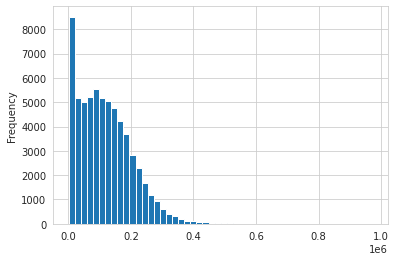

In [ ]:
df.mileage.plot.hist(bins=50);

In [ ]:
perc_nans(df.mileage)

9.033250877293908

## gearbox

In [ ]:
df.gearbox.sample(10)

15327       \n,Manual,\n
27191    \n,Automatic,\n
58000       \n,Manual,\n
44816       \n,Manual,\n
20032    \n,Automatic,\n
53986       \n,Manual,\n
15       \n,Automatic,\n
28160    \n,Automatic,\n
23938    \n,Automatic,\n
8457     \n,Automatic,\n
Name: gearbox, dtype: object

In [ ]:
df.gearbox = df.gearbox.str.extract(',(\w*),')

In [ ]:
df.gearbox.value_counts(dropna=False)

Automatic    40617
Manual       28117
NaN            798
Name: gearbox, dtype: int64

In [ ]:
perc_nans(df.gearbox)

1.1476730138641202

## seller

In [ ]:
perc_nans(df.seller) 

0.0

In [ ]:
df.seller.value_counts()

['\n', ['Dealer\n']]            63464
['\n', ['Private seller\n']]     6058
['\n', ['Diesel\n']]                4
['\n', ['Gasoline\n']]              4
['\n', ['Electric\n']]              2
Name: seller, dtype: int64

In [ ]:
df.seller =df.seller.str.extract(' \W*(\w*)\\n*')

In [ ]:
df.seller.value_counts()

Dealer      63464
Private      6058
Diesel          4
Gasoline        4
Electric        2
Name: seller, dtype: int64

10 rows are shifted. We have to adjust them.

## fuel_type

In [ ]:
perc_nans(df.fuel_type)

0.0

In [ ]:
df.fuel_type

0        \n,Gasoline,\n
1        \n,Gasoline,\n
2        \n,Gasoline,\n
3        \n,Gasoline,\n
4        \n,Gasoline,\n
              ...      
71099         \n,LPG,\n
71100         \n,CNG,\n
71101         \n,LPG,\n
71102         \n,LPG,\n
71103         \n,LPG,\n
Name: fuel_type, Length: 69532, dtype: object

In [ ]:
df.fuel_type = df.fuel_type.str.split(",").apply(lambda x: x[1])

In [ ]:
df.fuel_type.value_counts(dropna=False)

Gasoline             40764
Diesel               13045
Electric/Gasoline     9165
Electric              5477
LPG                    600
Electric/Diesel        277
CNG                    107
Hydrogen                67
Ethanol                 12
Others                   8
Automatic                7
Manual                   3
Name: fuel_type, dtype: int64

There is a shifting horizantally. "Automatic" and "Manual" should not be in this column.

## Handling of the row shifting

In [ ]:
df[(df.fuel_type=='Automatic') | (df.fuel_type=='Manual')][['make','model','gearbox','fuel_type','seller','empty_weight','power','registration']]

,make,model,gearbox,fuel_type,seller,empty_weight,power,registration
17268,Ford,Transit,NaN,Manual,Diesel,"\n,None,\n","3,500 kg,",96 kW (131 hp)
24444,Mercedes-Benz,EQV 300,NaN,Automatic,Electric,"\n,2,780 kg,\n","[None, '']",NaN
24445,Mercedes-Benz,EQV 300,NaN,Automatic,Electric,"\n,2,120 kg,\n","[None, '']",NaN
33880,Volkswagen,Caddy,NaN,Manual,Diesel,"\n,None,\n","2,159 kg,",75 kW (102 hp)
42393,Citroen,Jumpy,NaN,Automatic,Diesel,"\n,None,\n","2,735 kg,",130 kW (177 hp)
42547,Citroen,Jumpy,NaN,Manual,Diesel,"\n,None,\n","1,588 kg,",90 kW (122 hp)
43179,Chevrolet,Silverado,NaN,Automatic,Gasoline,"\n,None,\n","[None, '']",265 kW (360 hp)
43182,Chevrolet,Silverado,NaN,Automatic,Gasoline,"\n,None,\n","[None, '']",265 kW (360 hp)
63221,Toyota,Verso,NaN,Automatic,Gasoline,"\n,None,\n","[None, '']",96 kW (131 hp)
63227,Toyota,Verso,NaN,Automatic,Gasoline,"\n,None,\n","[None, '']",96 kW (131 hp)


In [ ]:
shifted_rows = df[(df.fuel_type=='Automatic') | (df.fuel_type=='Manual')].index
shifted_rows

Int64Index([17268, 24444, 24445, 33880, 42393, 42547, 43179, 43182, 63221, 63227], dtype='int64')

In [ ]:
df.loc[shifted_rows,['gearbox']] = df.loc[shifted_rows,['fuel_type']].values
df.loc[shifted_rows,['fuel_type']] = df.loc[shifted_rows,['seller']].values
df.loc[shifted_rows,['seller']] = 'Dealer'

8 rows are shifted in `empty_weight` and `power`. so we get the shifted indexes for these columns

In [ ]:
shifted_rows=df.registration[df.registration.str.contains('hp')==True].index
shifted_rows

Int64Index([17268, 33880, 42393, 42547, 43179, 43182, 63221, 63227], dtype='int64')

In [ ]:
df.loc[shifted_rows,['empty_weight']] = df.loc[shifted_rows,['power']].values
df.loc[shifted_rows,['power']] = df.loc[shifted_rows,['registration']].values
df.loc[shifted_rows,['registration']] = np.nan

## registration

In [ ]:
df.registration.value_counts()

01/2021    3242
01/2022    1422
12/2016     808
03/2021     777
06/2021     717
           ... 
05/1997       1
11/2025       1
05/1995       1
07/2028       1
10/1996       1
Name: registration, Length: 300, dtype: int64

In [ ]:
cramers_v(df.first_registration,df.registration)

1.0

`registration` and `first_registration` are correlated completely. we drop one of them.

In [ ]:
df = df.drop(['registration'],axis=1)

## first_registration

In [ ]:
perc_nans(df.first_registration)

0.05752746936662256

In [ ]:
df.first_registration

0        08/2003
1        10/2013
2        05/2013
3        06/2015
4        10/2015
          ...   
71099    02/2005
71100    10/2005
71101    08/2004
71102    01/2004
71103    09/2001
Name: first_registration, Length: 69532, dtype: object

we will extract the year from `first_registration`. Month information is negligible.

In [ ]:
df.first_registration = df.first_registration.str.extract('/(\d*)').astype('float')
v_counts(df, 'first_registration')

first_registration           
                    COUNT       RATE
2021.0               9146  13.153656
2017.0               6199   8.915320
2016.0               5759   8.282517
2018.0               4768   6.857274
2020.0               4683   6.735028
2015.0               3925   5.644883
2019.0               3556   5.114192
2014.0               3190   4.587816
2013.0               3173   4.563367
2011.0               3145   4.523097
2012.0               3136   4.510154
2010.0               2890   4.156360
2008.0               2370   3.408503
2009.0               2344   3.371110
2007.0               2014   2.896508
2006.0               1715   2.466490
2005.0               1646   2.367255
2022.0               1577   2.268020
2004.0               1375   1.977507
2003.0               1089   1.566185
2002.0                809   1.163493
2001.0                549   0.789565
2000.0                402   0.578151
NaN                    40   0.057527
1997.0                  6   0.008629
1998.0                  6   0.008629
1999.0                  5   0.007191
1993.0                  3   0.004315
1994.0                  2   0.002876
1996.0                  2   0.002876
1995.0                  2   0.002876
1980.0                  1   0.001438
2025.0                  1   0.001438
1976.0                  1   0.001438
1991.0                  1   0.001438
2028.0                  1   0.001438
1981.0                  1   0.001438

## previous_owner

In [ ]:
perc_nans(df.previous_owner)

0.0

In [ ]:
df.previous_owner

0        [['\n'], ['None']]
1        [['\n'], ['None']]
2        [['\n'], ['None']]
3        [['\n'], ['None']]
4        [['\n'], ['None']]
                ...        
71099    [['\n'], ['None']]
71100    [['\n'], ['None']]
71101       [['\n'], ['1']]
71102    [['\n'], ['None']]
71103    [['\n'], ['None']]
Name: previous_owner, Length: 69532, dtype: object

In [ ]:
df.previous_owner = df.previous_owner.str.strip("['\\n], ")
df.previous_owner.value_counts(dropna=False)

None    64683
1        2956
2        1299
3         386
4         132
5          41
6          14
7           8
8           7
9           2
10          2
14          1
12          1
Name: previous_owner, dtype: int64

In [ ]:
df.previous_owner = df.previous_owner.replace('None',np.nan)
perc_nans(df.previous_owner)

93.02623252603118

## last_timing_belt_change

In [ ]:
df.last_timing_belt_change

0        [['\n'], ['None']]
1        [['\n'], ['None']]
2        [['\n'], ['None']]
3        [['\n'], ['None']]
4        [['\n'], ['None']]
                ...        
71099    [['\n'], ['None']]
71100    [['\n'], ['None']]
71101    [['\n'], ['None']]
71102    [['\n'], ['None']]
71103    [['\n'], ['None']]
Name: last_timing_belt_change, Length: 69532, dtype: object

In [ ]:
df.last_timing_belt_change = df.last_timing_belt_change.str.strip("['\\n], ")
df.last_timing_belt_change.value_counts(dropna=False)

None       68584
06/2021       48
10/2021       36
07/2021       34
05/2021       33
09/2021       31
03/2021       29
11/2021       28
06/2020       26
04/2021       26
09/2020       24
07/2019       24
05/2020       23
07/2020       23
08/2021       23
08/2020       23
12/2020       21
10/2020       21
02/2020       21
06/2019       21
09/2019       20
12/2019       19
12/2021       19
10/2019       19
01/2021       16
01/2020       16
02/2021       15
03/2020       14
05/2019       14
04/2019       13
08/2019       13
01/2018       12
11/2020       12
07/2018       12
11/2019       12
06/2017       11
04/2020       10
10/2018       10
08/2018       10
05/2018        9
11/2018        9
02/2019        8
07/2017        8
12/2018        8
01/2019        7
10/2017        6
06/2018        6
03/2019        6
04/2018        6
03/2018        6
01/2017        5
01/1900        5
09/2017        5
09/2016        4
09/2015        4
08/2017        4
02/2016        4
05/2017        4
06/2016       

In [ ]:
df.last_timing_belt_change = df.last_timing_belt_change.replace('None',np.nan)
perc_nans(df.last_timing_belt_change)

98.63659897601104

## power

In [ ]:
perc_nans(df.power) 

0.0

In [ ]:
df.power

0        110 kW (150 hp),
1         92 kW (125 hp),
2         90 kW (122 hp),
3         92 kW (125 hp),
4         92 kW (125 hp),
               ...       
71099    103 kW (140 hp),
71100    103 kW (140 hp),
71101    132 kW (179 hp),
71102    103 kW (140 hp),
71103    104 kW (141 hp),
Name: power, Length: 69532, dtype: object

1 kW = 1.359622 hp

In [ ]:
df.power = df.power.str.extract('(\d*) hp')
df.power.value_counts(dropna=False)

NaN    5981
150    4083
120    2806
136    2479
122    2421
       ... 
352       1
18        1
377       1
434       1
14        1
Name: power, Length: 366, dtype: int64

In [ ]:
perc_nans(df.power)

8.601794857044238

## body_type

In [ ]:
df.body_type.value_counts(dropna=False)

\n,Off-Road/Pick-up,\n    19339
\n,Compact,\n             14665
\n,Station wagon,\n       12487
\n,Van,\n                  6882
\n,Sedan,\n                5939
\n,Convertible,\n          3928
\n,Transporter,\n          2499
\n,Coupe,\n                2096
\n,None,\n                 1071
\n,Other,\n                 621
\n,Panel van,\n               2
\n,Flatbed van,\n             2
\n,Car transport,\n           1
Name: body_type, dtype: int64

In [ ]:
df.body_type = df.body_type.apply(lambda x:x.split(',')[1])

In [ ]:
df.body_type.value_counts(dropna=False)

Off-Road/Pick-up    19339
Compact             14665
Station wagon       12487
Van                  6882
Sedan                5939
Convertible          3928
Transporter          2499
Coupe                2096
None                 1071
Other                 621
Panel van               2
Flatbed van             2
Car transport           1
Name: body_type, dtype: int64

In [ ]:
df.body_type = df.body_type.replace('None',np.nan)

In [ ]:
perc_nans(df.body_type)

1.5402979922913191

## type

In [ ]:
df.type.value_counts(dropna=False)

\n,Used,\n                 61473
\n,New,\n                   3848
\n,Demonstration,\n         2038
\n,Pre-registered,\n        1101
\n,None,\n                  1071
\n,Antique / Classic,\n        1
Name: type, dtype: int64

In [ ]:
df.type = df.type.apply(lambda x:x.split(',')[1])
df.type.value_counts(dropna=False)

Used                 61473
New                   3848
Demonstration         2038
Pre-registered        1101
None                  1071
Antique / Classic        1
Name: type, dtype: int64

In [ ]:
df.type = df.type.replace('None',np.nan)
perc_nans(df.type)

1.5402979922913191

## drivetrain

In [ ]:
df.drivetrain.sample(10)

4046       \n,4WD,\n
46922    \n,Front,\n
36117     \n,Rear,\n
23276     \n,Rear,\n
3509     \n,Front,\n
22641     \n,Rear,\n
39745    \n,Front,\n
37701    \n,Front,\n
40236    \n,Front,\n
51530     \n,None,\n
Name: drivetrain, dtype: object

In [ ]:
df.drivetrain = df.drivetrain.apply(lambda x:x.split(',')[1])
df.drivetrain.value_counts(dropna=False)

Front    37214
None     16160
4WD       8113
Rear      8045
Name: drivetrain, dtype: int64

In [ ]:
df.drivetrain = df.drivetrain.replace('None',np.nan)
perc_nans(df.drivetrain)

23.241097624115515

## seats

In [ ]:
df.seats.unique()

array(['\n5', '\n4', 'None\n', '\n2', '\n6', '\n7', '\n3', '\n14', '\n9',
       '\n8', '\n1'], dtype=object)

In [ ]:
df.seats = df.seats.str.extract('(\d*)$')
df.seats.value_counts(dropna=False)

5     51860
4      6608
       5442
2      2185
7      2025
3       992
6       290
8        64
9        63
1         2
14        1
Name: seats, dtype: int64

In [ ]:
df.seats = df.seats.replace('',np.nan)
perc_nans(df.seats)

7.826612207328999

## doors

In [ ]:
df.doors.sample(10)

50407       \n5
42907    None\n
47413       \n5
39265       \n5
13736       \n4
50405       \n5
22294       \n5
25780       \n5
68351       \n4
5408        \n5
Name: doors, dtype: object

In [ ]:
df.doors = df.doors.str.extract('(\d)$')
df.doors.value_counts(dropna=False)

5      50480
4       9376
2       5742
3       2526
NaN     1310
6         94
1          4
Name: doors, dtype: int64

In [ ]:
perc_nans(df.doors)

1.8840246217568888

## warranty

In [ ]:
df.warranty.value_counts()

\n,None,\n         46010
\n,6 months,\n     18502
\n,3 months,\n      1810
\n,12 months,\n     1490
\n,24 months,\n     1152
\n,1 months,\n       262
\n,84 months,\n      231
\n,18 months,\n       33
\n,36 months,\n       13
\n,2 months,\n         8
\n,48 months,\n        7
\n,Yes,\n              5
\n,60 months,\n        3
\n,26 months,\n        2
\n,9 months,\n         2
\n,10 months,\n        1
\n,4 months,\n         1
Name: warranty, dtype: int64

In [ ]:
df.warranty = df.warranty.replace('\n,Yes,\n','\n,1 months,\n')
df.warranty = df.warranty.str.extract(',(\d*) months')
df.warranty.value_counts(dropna=False)

NaN    46010
6      18502
3       1810
12      1490
24      1152
1        267
84       231
18        33
36        13
2          8
48         7
60         3
26         2
9          2
10         1
4          1
Name: warranty, dtype: int64

In [ ]:
perc_nans(df.warranty)

66.1709716389576

## general_inspection

In [ ]:
df['general_inspection'].value_counts(dropna=False, normalize=True).head(10)

New        0.247368
NaN        0.240537
06/2022    0.034416
03/2022    0.031942
07/2022    0.030964
05/2022    0.030720
11/2022    0.028663
10/2022    0.028419
04/2022    0.028246
09/2022    0.027800
Name: general_inspection, dtype: float64

In [ ]:
df.general_inspection = df.general_inspection.replace('New','12/2022')
df['general_inspection'] = pd.to_datetime(df['general_inspection'], dayfirst=True)
df['general_inspection'].value_counts(dropna=False, normalize=True)

2022-12-01    0.271803
NaT           0.240537
2022-06-01    0.034416
2022-03-01    0.031942
2022-07-01    0.030964
2022-05-01    0.030720
2022-11-01    0.028663
2022-10-01    0.028419
2022-04-01    0.028246
2022-09-01    0.027800
2022-02-01    0.025485
2022-08-01    0.025283
2023-01-01    0.012599
2023-06-01    0.008083
2023-05-01    0.007968
2023-03-01    0.007781
2023-07-01    0.007522
2023-04-01    0.007435
2022-01-01    0.007378
2023-02-01    0.007306
2023-11-01    0.006889
2023-08-01    0.006256
2025-03-01    0.006227
2023-10-01    0.006170
2024-12-01    0.006055
2023-09-01    0.005652
2025-06-01    0.005508
2023-12-01    0.005350
2024-07-01    0.004588
2025-02-01    0.004473
2024-09-01    0.004358
2025-04-01    0.004286
2024-10-01    0.004271
2024-01-01    0.004128
2025-05-01    0.004099
2025-01-01    0.003969
2024-06-01    0.003840
2025-10-01    0.003725
2025-11-01    0.003653
2025-07-01    0.003610
2024-11-01    0.003394
2024-08-01    0.003265
2025-09-01    0.003250
2024-02-01 

In [ ]:
df['inspection_new'] = (df['general_inspection'] - pd.to_datetime("2022-01-01")).astype(str).str.strip(' days') \
                                                            .replace("NaT", np.nan).astype('float64') \
                                                            .apply(lambda x: x if pd.isnull(x) else np.int(x/30.0))

df.loc[df[(df.inspection_new <= 10)&(df.inspection_new >=0)].index,'inspection_new']=1
df.loc[df[(df.inspection_new > 10)].index,'inspection_new']=0
df.loc[df[(df.inspection_new < 0)].index,'inspection_new']=np.nan
df.inspection_new.value_counts(dropna=False, normalize=True)

0.0    0.451030
1.0    0.299315
NaN    0.249655
Name: inspection_new, dtype: float64

- We will reduce the feature to only 2 variables. Thus, we reduce the confusion and we also get rid of the anomalies in details of the feature.
- We have accepted the inspection of vehicles that have been inspected for more than 10 months as new.
- If the general inspection is a date that has passed, we have accepted these as missing value.

In [ ]:
df.inspection_new.fillna(0, inplace=True)
df.inspection_new.value_counts(dropna=False, normalize=True)

0.0    0.700685
1.0    0.299315
Name: inspection_new, dtype: float64

- We accepted that the examination of the missing-valued observations had not been done recently.

## full_service_history

In [ ]:
df.full_service_history.sample(20)

44587     \n,Yes,\n
70283     \n,Yes,\n
10952     \n,Yes,\n
11470    \n,None,\n
17298     \n,Yes,\n
62008     \n,Yes,\n
27884     \n,Yes,\n
15436     \n,Yes,\n
43376     \n,Yes,\n
35989     \n,Yes,\n
61876     \n,Yes,\n
28834     \n,Yes,\n
28588    \n,None,\n
43697     \n,Yes,\n
67275    \n,None,\n
17596     \n,Yes,\n
25456     \n,Yes,\n
47475     \n,Yes,\n
52595    \n,None,\n
59006     \n,Yes,\n
Name: full_service_history, dtype: object

In [ ]:
df.full_service_history = df.full_service_history.str.extract(',(\w*),')
df.full_service_history.value_counts(dropna=False)

Yes     47569
None    21963
Name: full_service_history, dtype: int64

In [ ]:
df.full_service_history = df.full_service_history.str.replace('None','No')
df.full_service_history.value_counts(dropna=False)

Yes    47569
No     21963
Name: full_service_history, dtype: int64

## non_smoker_vehicle

In [ ]:
df.non_smoker_vehicle

0        \n,None,\n
1        \n,None,\n
2        \n,None,\n
3         \n,Yes,\n
4        \n,None,\n
            ...    
71099    \n,None,\n
71100    \n,None,\n
71101    \n,None,\n
71102    \n,None,\n
71103    \n,None,\n
Name: non_smoker_vehicle, Length: 69532, dtype: object

In [ ]:
df.non_smoker_vehicle = df.non_smoker_vehicle.str.extract(',(\w*),')
df.non_smoker_vehicle.value_counts(dropna=False)

None    63922
Yes      5610
Name: non_smoker_vehicle, dtype: int64

In [ ]:
df.non_smoker_vehicle = df.non_smoker_vehicle.str.replace('None','No')
df.non_smoker_vehicle.value_counts(dropna=False)

No     63922
Yes     5610
Name: non_smoker_vehicle, dtype: int64

## engine_size

In [ ]:
df.engine_size

0        \n,1,984 cc,\n
1        \n,1,395 cc,\n
2        \n,1,395 cc,\n
3        \n,1,395 cc,\n
4        \n,1,395 cc,\n
              ...      
71099    \n,2,435 cc,\n
71100    \n,2,435 cc,\n
71101    \n,1,984 cc,\n
71102        \n,None,\n
71103    \n,2,435 cc,\n
Name: engine_size, Length: 69532, dtype: object

In [ ]:
df.engine_size = df.engine_size.str.extract('(\d,\d*)')
df.engine_size = df.engine_size.str.replace(',','').astype('float')
df.engine_size.value_counts(dropna=False)

NaN       11257
1598.0     4818
1998.0     2923
1199.0     2487
1395.0     2336
          ...  
3495.0        1
1405.0        1
6466.0        1
3556.0        1
2499.0        1
Name: engine_size, Length: 430, dtype: int64

In [ ]:
perc_nans(df.engine_size)

16.189668066501756

## gears

In [ ]:
df.gears

0        \n,None,\n
1        \n,None,\n
2        \n,None,\n
3        \n,None,\n
4           \n,7,\n
            ...    
71099       \n,5,\n
71100       \n,5,\n
71101       \n,5,\n
71102       \n,5,\n
71103       \n,5,\n
Name: gears, Length: 69532, dtype: object

In [ ]:
df.gears = df.gears.str.extract(',(\d),')
df.gears.value_counts(dropna=False)

6      20769
NaN    20257
5      11975
7       7642
8       5430
1       1741
9        996
4        674
2         40
3          8
Name: gears, dtype: int64

In [ ]:
perc_nans(df.gears)

29.133348673991833

## cylinders

In [ ]:
 df.cylinders

0        \n,4,\n
1        \n,4,\n
2        \n,4,\n
3        \n,4,\n
4        \n,4,\n
          ...   
71099    \n,5,\n
71100    \n,5,\n
71101    \n,5,\n
71102    \n,5,\n
71103    \n,5,\n
Name: cylinders, Length: 69532, dtype: object

In [ ]:
df.cylinders = df.cylinders.str.extract(',(\d),')
df.cylinders.value_counts(dropna=False)

4      46556
3       8484
NaN     6281
6       4661
5       1533
8       1028
1        554
2        433
7          2
Name: cylinders, dtype: int64

In [ ]:
perc_nans(df.cylinders)

9.033250877293908

## empty_weight

In [ ]:
df.empty_weight

0        \n,1,280 kg,\n
1        \n,1,200 kg,\n
2        \n,1,200 kg,\n
3            \n,None,\n
4        \n,1,105 kg,\n
              ...      
71099    \n,1,441 kg,\n
71100    \n,1,489 kg,\n
71101    \n,1,495 kg,\n
71102        \n,None,\n
71103    \n,1,488 kg,\n
Name: empty_weight, Length: 69532, dtype: object

In [ ]:
df.empty_weight =df.empty_weight.str.extract('(\d,\d*)')
df.empty_weight = df.empty_weight.str.replace(',','').astype('float')
df.empty_weight.value_counts(dropna=False)

NaN       4877
1295.0    1689
1405.0    1261
1635.0     877
1065.0     735
          ... 
1551.0       1
2253.0       1
1072.0       1
2483.0       1
2147.0       1
Name: empty_weight, Length: 1416, dtype: int64

In [ ]:
perc_nans(df.empty_weight)

7.0140367025254555

## co2_emissions

In [ ]:
df.co2_emissions

0        ['\n', [' ', ' ', ' '], '\n']
1                           \n,None,\n
2               \n,116 g/km (comb.),\n
3                           \n,None,\n
4               \n,111 g/km (comb.),\n
                     ...              
71099    ['\n', [' ', ' ', ' '], '\n']
71100           \n,159 g/km (comb.),\n
71101           \n,215 g/km (comb.),\n
71102                       \n,None,\n
71103           \n,207 g/km (comb.),\n
Name: co2_emissions, Length: 69532, dtype: object

In [ ]:
df.co2_emissions= df.co2_emissions.str.extract(',(\d*)')
df.co2_emissions.value_counts(dropna=False)

       18577
0       5547
139     1190
149     1011
119      994
       ...  
378        1
400        1
311        1
24         1
70         1
Name: co2_emissions, Length: 349, dtype: int64

In [ ]:
df.loc[df[df.co2_emissions==''].index,'co2_emissions']=np.nan
df.co2_emissions.value_counts(dropna=False)

NaN    18577
0       5547
139     1190
149     1011
119      994
       ...  
378        1
400        1
311        1
24         1
70         1
Name: co2_emissions, Length: 349, dtype: int64

In [ ]:
perc_nans(df.co2_emissions)

26.71719496059368

## emission_class

In [ ]:
df.emission_class.value_counts(dropna=False)

\n,Euro 6,\n                     21862
\n,None,\n                       21201
\n,Euro 5,\n                     11754
\n,Euro 4,\n                      8475
\n,Euro 6d-TEMP,\n                2969
\n,Euro 3,\n                      1893
['\n', [' ', ' ', ' '], '\n']      668
\n,Euro 1,\n                       520
\n,Euro 2,\n                       149
\n,Euro 6c,\n                       22
\n,Euro 6d,\n                       19
Name: emission_class, dtype: int64

In [ ]:
df.emission_class = df.emission_class.str.extract(',(\w+\s*\d*)')
df.emission_class.value_counts(dropna=False)

Euro 6    24872
None      21201
Euro 5    11754
Euro 4     8475
Euro 3     1893
NaN         668
Euro 1      520
Euro 2      149
Name: emission_class, dtype: int64

In [ ]:
df.emission_class = df.emission_class.replace('None', np.nan)
perc_nans(df.emission_class)

31.45170568946672

## emissions_sticker

In [ ]:
df.emissions_sticker.value_counts(dropna=False)

\n,None,\n                       69378
\n,4 (Green),\n                    122
\n,1 (No sticker),\n                14
['\n', [' ', ' ', ' '], '\n']       12
\n,3 (Yellow),\n                     4
\n,2 (Red),\n                        2
Name: emissions_sticker, dtype: int64

In [ ]:
df.emissions_sticker = df.emissions_sticker.str.extract('\((\w+)\)')
df.emissions_sticker.value_counts(dropna=False)

NaN       69404
Green       122
Yellow        4
Red           2
Name: emissions_sticker, dtype: int64

In [ ]:
perc_nans(df.emissions_sticker)

99.8159120980268

## comfort_convenience

In [ ]:
df.comfort_convenience

0                                                                                                                                                                      [['Air conditioning', 'Armrest', 'Automatic climate control', 'Electrical side mirrors', 'Navigation system', 'Power windows', 'Sunroof']]
1                                                                                                                                                                                  [['Air conditioning', 'Automatic climate control', 'Electrical side mirrors', 'Light sensor', 'Power windows', 'Rain sensor']]
2                                                                                                            [['Air conditioning', 'Armrest', 'Cruise control', 'Electrical side mirrors', 'Leather steering wheel', 'Multi-function steering wheel', 'Navigation system', 'Power windows', 'Start-stop system']]
3                                                                                 

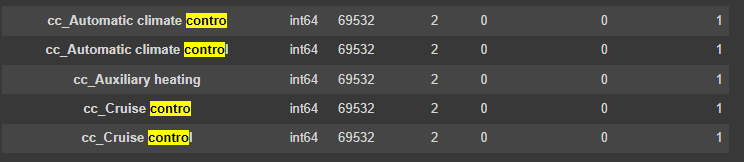

There are missing l letters at the end of the list. Let's complete them.

In [ ]:
df.comfort_convenience = df.comfort_convenience.str.replace("ontro']]","ontrol']]", case=False).str.replace("hee']]","heel']]", case=False)

In [ ]:
df.comfort_convenience = df.comfort_convenience.str.strip("[']").str.split("', '")

In [ ]:
df.comfort_convenience

0                                                                                                                                                          [Air conditioning, Armrest, Automatic climate control, Electrical side mirrors, Navigation system, Power windows, Sunroof]
1                                                                                                                                                                    [Air conditioning, Automatic climate control, Electrical side mirrors, Light sensor, Power windows, Rain sensor]
2                                                                                                    [Air conditioning, Armrest, Cruise control, Electrical side mirrors, Leather steering wheel, Multi-function steering wheel, Navigation system, Power windows, Start-stop system]
3                                                                                           [Air conditioning, Armrest, Automatic climate control, Cruise control, Nav

## entertainment_media

In [ ]:
df.entertainment_media

0                                                                         [['CD player', 'Radio']]
1                                                                         [['CD player', 'Radio']]
2        [['Bluetooth', 'CD player', 'Hands-free equipment', 'MP3', 'On-board computer', 'Radio']]
3                                         [['Bluetooth', 'CD player', 'On-board computer', 'USB']]
4                                             [['CD player', 'MP3', 'On-board computer', 'Radio']]
                                                   ...                                            
71099                                                [['CD player', 'On-board computer', 'Radio']]
71100                                                                                  [['Radio']]
71101                                                                      [['On-board computer']]
71102                                                [['CD player', 'On-board computer', 'Radio']]
71103     

In [ ]:
df.entertainment_media = df.entertainment_media.str.replace("ontro']]","ontrol']]", case=False).str.replace("hee']]","heel']]", case=False)

In [ ]:
df.entertainment_media = df.entertainment_media.str.strip("[']").str.split("', '")

In [ ]:
df.entertainment_media

0                                                                 [CD player, Radio]
1                                                                 [CD player, Radio]
2        [Bluetooth, CD player, Hands-free equipment, MP3, On-board computer, Radio]
3                                     [Bluetooth, CD player, On-board computer, USB]
4                                         [CD player, MP3, On-board computer, Radio]
                                            ...                                     
71099                                          [CD player, On-board computer, Radio]
71100                                                                        [Radio]
71101                                                            [On-board computer]
71102                                          [CD player, On-board computer, Radio]
71103                                                     [On-board computer, Radio]
Name: entertainment_media, Length: 69532, dtype: object

## safety_security

In [ ]:
df.safety_security

0                                                                                                 [['ABS', 'Alarm system', 'Central door lock', 'Central door lock with remote control', 'Driver-side airbag', 'Electronic stability control', 'Fog lights', 'Head airbag', 'Immobilizer', 'Passenger-side airbag', 'Power steering', 'Side airbag', 'Traction contro']]
1                                                                                                                                                                                                                                                          [['Alarm system', 'Central door lock', 'Central door lock with remote control', 'Fog lights', 'Immobilizer']]
2                                                                                                                                    [['ABS', 'Central door lock', 'Central door lock with remote control', 'Driver-side airbag', 'Electronic stability control', 'Immobilizer', 'Isof

In [ ]:
df.safety_security = df.safety_security.str.replace("ontro']]","ontrol']]", case=False).str.replace("hee']]","heel']]", case=False)

In [ ]:
df.safety_security = df.safety_security.str.strip("[']").str.split("', '")

In [ ]:
df.safety_security

0                                                                                        [ABS, Alarm system, Central door lock, Central door lock with remote control, Driver-side airbag, Electronic stability control, Fog lights, Head airbag, Immobilizer, Passenger-side airbag, Power steering, Side airbag, Traction control]
1                                                                                                                                                                                                                                  [Alarm system, Central door lock, Central door lock with remote control, Fog lights, Immobilizer]
2                                                                                                                       [ABS, Central door lock, Central door lock with remote control, Driver-side airbag, Electronic stability control, Immobilizer, Isofix, Passenger-side airbag, Power steering, Side airbag, Traction control]
3                        

## extras

In [ ]:
df.extras

0                                                                     [['Alloy wheels']]
1                                                               [['Alloy wheels (16")']]
2                                                          [['Alloy wheels', 'Spoiler']]
3                                                               [['Alloy wheels (15")']]
4           [['Alloy wheels (17")', 'Shift paddles', 'Sport seats', 'Sport suspension']]
                                              ...                                       
71099                                                           [['Alloy wheels (15")']]
71100                                                           [['Alloy wheels (17")']]
71101                  [['Alloy wheels (17")', 'Automatically dimming interior mirror']]
71102    [['Alloy wheels (16")', 'Automatically dimming interior mirror', 'Spare tyre']]
71103                                                                 [['Alloy wheels']]
Name: extras, Length:

In [ ]:
df.extras = df.extras.str.replace("ontro']]","ontrol']]", case=False).str.replace("hee']]","heel']]", case=False)

In [ ]:
df.extras = df.extras.str.strip("[']").str.split("', '")

In [ ]:
df.extras

0                                                                 [Alloy wheels]
1                                                           [Alloy wheels (16")]
2                                                        [Alloy wheels, Spoiler]
3                                                           [Alloy wheels (15")]
4             [Alloy wheels (17"), Shift paddles, Sport seats, Sport suspension]
                                          ...                                   
71099                                                       [Alloy wheels (15")]
71100                                                       [Alloy wheels (17")]
71101                [Alloy wheels (17"), Automatically dimming interior mirror]
71102    [Alloy wheels (16"), Automatically dimming interior mirror, Spare tyre]
71103                                                             [Alloy wheels]
Name: extras, Length: 69532, dtype: object

## colour

In [ ]:
df.colour

0         \n4, Grey
1        \n4, White
2        \n4, Black
3         \n4, Grey
4        \n4, Black
            ...    
71099     \n4, Blue
71100     \n4, Blue
71101    \n4, Black
71102    \n4, Beige
71103     \n4, Grey
Name: colour, Length: 69532, dtype: object

In [ ]:
df.colour = df.colour.str.extract('\n4, (\w*)')
df.colour.value_counts(dropna=False)

Grey      22941
Black     17657
White      9924
Blue       8650
Red        3136
Brown      1890
Silver     1812
NaN        1184
Green       869
Beige       563
Orange      361
Yellow      288
Violet      165
Gold         56
Bronze       36
Name: colour, dtype: int64

In [ ]:
perc_nans(df.colour)

1.7028130932520278

## paint

In [ ]:
df.paint

0        \npaint, Metallic
1                      NaN
2        \npaint, Metallic
3        \npaint, Metallic
4                      NaN
               ...        
71099                  NaN
71100    \npaint, Metallic
71101    \npaint, Metallic
71102    \npaint, Metallic
71103    \npaint, Metallic
Name: paint, Length: 69532, dtype: object

In [ ]:
df.paint = df.paint.str.extract('(\w*)$')
df.paint.value_counts(dropna=False)

Metallic    49129
NaN         20403
Name: paint, dtype: int64

In [ ]:
perc_nans(df.paint)

29.343323937180006

## upholstery_colour

In [ ]:
df.upholstery_colour

0        \nupholstery, Black
1        \nupholstery, Black
2                        NaN
3                        NaN
4        \nupholstery, Black
                ...         
71099                    NaN
71100    \nupholstery, Beige
71101                    NaN
71102    \nupholstery, Beige
71103                    NaN
Name: upholstery_colour, Length: 69532, dtype: object

In [ ]:
df.upholstery_colour=df.upholstery_colour.str.extract('(\w*)$')
df.upholstery_colour.value_counts(dropna=False)

Black     33619
NaN       24284
Grey       6004
Beige      1721
Other      1667
Brown      1249
Red         324
Blue        321
White       289
Orange       24
Yellow       17
Green        13
Name: upholstery_colour, dtype: int64

In [ ]:
perc_nans(df.upholstery_colour)

34.92492665247656

## upholstery

In [ ]:
df.upholstery.value_counts(dropna=False)

\n8, Cloth           25936
\n8, Full leather    19071
NaN                  11870
\n8, Part leather    10547
\n8, alcantara        1097
\n8, Other             540
\n8, Velour            471
Name: upholstery, dtype: int64

In [ ]:
df.upholstery= df.upholstery.str.strip('\n8, ')
df.upholstery.value_counts(dropna=False)

Cloth           25936
Full leather    19071
NaN             11870
Part leather    10547
alcantara        1097
Other             540
Velour            471
Name: upholstery, dtype: int64

In [ ]:
perc_nans(df.upholstery)

17.071276534545245

## country_version

In [ ]:
df.country_version.value_counts(dropna=False)

Country version,None                    60739
Country version,Netherlands              7561
Country version,Germany                   866
Country version,Belgium                   117
Country version,Sweden                     56
Country version,Denmark                    38
Country version,France                     23
Country version,Czechia                    20
Country version,Spain                      16
Country version,Italy                      15
Country version,Switzerland                14
Country version,United States              13
Country version,Poland                     13
Country version,Austria                    11
Country version,Luxembourg                  9
Country version,Slovenia                    5
Country version,Hungary                     3
Country version,United Kingdom              3
Country version,Japan                       2
Country version,Canada                      2
Country version,Latvia                      1
Country version,Romania           

In [ ]:
df.country_version = df.country_version.str.extract('([a-zA-Z ]*)$').replace('None',np.nan)
df.country_version.value_counts(dropna=False)

NaN                     60739
Netherlands              7561
Germany                   866
Belgium                   117
Sweden                     56
Denmark                    38
France                     23
Czechia                    20
Spain                      16
Italy                      15
Switzerland                14
United States              13
Poland                     13
Austria                    11
Luxembourg                  9
Slovenia                    5
Hungary                     3
United Kingdom              3
Japan                       2
Canada                      2
Latvia                      1
Romania                     1
Estonia                     1
Namibia                     1
Lithuania                   1
United Arab Emirates        1
Name: country_version, dtype: int64

In [ ]:
perc_nans(df.country_version)

87.3540240464822

# Feature Engineering

## fuel_consumption

In [ ]:
df.fuel_consumption

0                                                                                      \n,None,\n
1                                                ['\n', ['4.9 l/100 km (comb.)', ' ', ' '], '\n']
2                                                  ['\n', ['5 l/100 km (comb.)', ' ', ' '], '\n']
3               ['\n', ['0 l/100 km (comb.)', '0 l/100 km (city)', '0 l/100 km (country)'], '\n']
4         ['\n', ['4.8 l/100 km (comb.)', '5.9 l/100 km (city)', '4.2 l/100 km (country)'], '\n']
                                                   ...                                           
71099                                                                                  \n,None,\n
71100    ['\n', ['8.9 l/100 km (comb.)', '12.7 l/100 km (city)', '6.6 l/100 km (country)'], '\n']
71101      ['\n', ['9.1 l/100 km (comb.)', '12.6 l/100 km (city)', '7 l/100 km (country)'], '\n']
71102                                                                                  \n,None,\n
71103    ['\n', ['8.

In [ ]:
df['fuel_consumption_mean'] = df.fuel_consumption.str.extract('(\d*\.?\d*) l\/100 km \(comb').astype('float')
df['fuel_consumption_city'] = df.fuel_consumption.str.extract('(\d*\.?\d*) l\/100 km \(city').astype('float')
df['fuel_consumption_country'] = df.fuel_consumption.str.extract('(\d*\.?\d*) l\/100 km \(country').astype('float')

In [ ]:
df = df.drop(['fuel_consumption'], axis=1)

## make_model

In [ ]:
df['make_model'] = df[['make','model']].apply(lambda x: x[0].strip()+' '+x[1].strip(), axis=1)
df.make_model.value_counts(dropna=False)

Audi A3                     1297
Renault Megane              1033
Volkswagen Golf             1025
Ford Focus                   939
Audi A4                      922
                            ... 
Volkswagen T5 California       1
Skoda Others                   1
Volkswagen XL1                 1
Skoda Felicia                  1
Toyota Paseo                   1
Name: make_model, Length: 787, dtype: int64

## age

In [ ]:
df['age']= 2022 - df.first_registration
df.age.value_counts(dropna=False)

 1.0     9146
 5.0     6199
 6.0     5759
 4.0     4768
 2.0     4683
 7.0     3925
 3.0     3556
 8.0     3190
 9.0     3173
 11.0    3145
 10.0    3136
 12.0    2890
 14.0    2370
 13.0    2344
 15.0    2014
 16.0    1715
 17.0    1646
 0.0     1577
 18.0    1375
 19.0    1089
 20.0     809
 21.0     549
 22.0     402
 NaN       40
 25.0       6
 24.0       6
 23.0       5
 29.0       3
 28.0       2
 26.0       2
 27.0       2
 42.0       1
-3.0        1
 46.0       1
 31.0       1
-6.0        1
 41.0       1
Name: age, dtype: int64

## make_country

In [ ]:
list(df.make.unique())

['Audi',
 'BMW',
 'Ford',
 'Mercedes-Benz',
 'Opel',
 'Volkswagen',
 'Renault',
 'Citroen',
 'Chevrolet',
 'Dacia',
 'Fiat',
 'Honda',
 'Hyundai',
 'Kia',
 'Mazda',
 'Peugeot',
 'Skoda',
 'Toyota',
 'Tesla',
 'Volvo']

In [ ]:
make_country_dic= {'Audi':"Germany",
                  'BMW':"Germany",
                  'Ford':"USA",
                  'Mercedes-Benz':"Germany",
                  'Opel':"Germany",
                  'Volkswagen':"Germany",
                  'Renault':'France',
                  'Citroen':'France',
                  'Chevrolet':"USA",
                  'Dacia':'France',
                  'Fiat':"Italy",
                  'Honda':"Japan",
                  'Hyundai':"Korea",
                  'Kia':"Korea",
                  'Mazda':"Japan",
                  'Peugeot':'France',
                  'Skoda':"Germany",
                  'Toyota':"Japan",
                  'Tesla':'USA',
                  'Volvo':'Sweden'}

In [ ]:
df['make_country'] = df.make.apply(lambda x: make_country_dic[x])

In [ ]:
v_counts(df,'make_country')

make_country           
               COUNT       RATE
Germany        33079  47.573779
France         11923  17.147500
Japan           6548   9.417247
USA             5399   7.764770
Korea           5332   7.668412
Sweden          5170   7.435425
Italy           2081   2.992867

## province

In [ ]:
df.location = df.location.str.replace("tdam","dam"). \
                          str.replace("gevee","kevee"). \
                          str.replace("redam","erdam"). \
                          str.replace("tedam","terdam")

In [ ]:
vl = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AutoScout24/netherland_villages.csv')
vl.doorp = vl.doorp.str.lower()
vl.stad = vl.stad.str.lower()
vl = pd.concat([vl[['doorp','provincie']], vl[['stad','provincie']].rename(columns = {'stad':'doorp'})], ignore_index=True)
vl = vl.drop_duplicates()
vl.doorp = vl.doorp.str.replace(' (.*)$',' ')

v0= vl.doorp.str.replace('\W+',' ').str.replace('\s+',' ').str.strip("'s-+. \\").to_frame()
v0['provincie'] = vl['provincie'].copy()
v1 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0][:-1],x[1]], index=['doorp', 'provincie']),axis=1)
v2 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0][1:],x[1]], index=['doorp', 'provincie']),axis=1)
v3 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0].split()[-1],x[1]], index=['doorp', 'provincie']),axis=1)
v4 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0].split()[-1][:-1],x[1]], index=['doorp', 'provincie']),axis=1)
v5 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0].split()[-1][1:],x[1]], index=['doorp', 'provincie']),axis=1)
v6 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0].split()[0],x[1]], index=['doorp', 'provincie']),axis=1)
v7 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0].split()[0][:-1],x[1]], index=['doorp', 'provincie']),axis=1)
v8 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0].split()[0][1:],x[1]], index=['doorp', 'provincie']),axis=1)
v9 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0][:-2],x[1]], index=['doorp', 'provincie']),axis=1)
v10 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0].split()[-2] if len(x[0].split())>1 else x[0].split()[-1] ,x[1]], index=['doorp', 'provincie']),axis=1)
v11 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0].split()[-2][:-1] if len(x[0].split())>1 else x[0].split()[-1] ,x[1]], index=['doorp', 'provincie']),axis=1)
v12 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0].split()[1] if len(x[0].split())>1 else x[0].split()[-1] ,x[1]], index=['doorp', 'provincie']),axis=1)
v13 = vl[['doorp','provincie']].apply(lambda x: pd.Series([x[0].split()[1][:-1] if len(x[0].split())>1 else x[0].split()[-1] ,x[1]], index=['doorp', 'provincie']),axis=1)

vl = pd.concat([vl[['doorp','provincie']], v0, v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13], ignore_index=True)
vl = vl.drop_duplicates(keep='first')
vl = vl.loc[vl.doorp.drop_duplicates(keep='first').index]
vl.doorp = vl.doorp.apply(lambda x: np.nan if len(x)<3 else x).dropna()

In [ ]:
df2 = pd.DataFrame(df['location'].unique(), columns=['village'])
df2.village = df2.village.str.lower()
df2 = df2[['village']].merge(vl[['doorp','provincie']], left_on='village', right_on='doorp', how='left')
df2 = df2.dropna()

In [ ]:
df['province'] = df['location'].str.lower().to_frame().merge(df2[['doorp','provincie']], 
                                                             left_on='location', right_on='doorp', how='left').drop(['location','doorp'], axis=1)

In [ ]:
v_counts(df,'province')

province           
                 COUNT       RATE
Gelderland       11524  16.573664
North Brabant    10600  15.244779
NaN              10397  14.952827
South Holland     8131  11.693896
North Holland     6932   9.969510
Utrecht           5285   7.600817
Overijssel        3392   4.878329
Limburg           3221   4.632399
Friesland         2875   4.134787
Drenthe           2713   3.901801
Flevoland         2033   2.923834
Groningen         1294   1.861014
Zeeland           1135   1.632342

# Check Data and Save

In [ ]:
show_nans(df,85)

country_version             87.354024
production_date             89.603348
last_service               100.000000
previous_owner              93.026233
last_timing_belt_change     98.636599
emissions_sticker           99.815912
manufacturer_color         100.000000
dtype: float64

In [ ]:
df.head(2)

,location,url,make,model,short_description,price,mileage,gearbox,fuel_type,power,seller,body_type,type,drivetrain,seats,doors,country_version,offer_number,warranty,Mileage,first_registration,production_date,general_inspection,last_service,full_service_history,non_smoker_vehicle,previous_owner,last_timing_belt_change,Power,Gearbox,engine_size,gears,cylinders,empty_weight,Fuel_type,co2_emissions,emission_class,emissions_sticker,comfort_convenience,entertainment_media,safety_security,extras,colour,manufacturer_color,paint,upholstery_colour,upholstery,inspection_new,fuel_consumption_mean,fuel_consumption_city,fuel_consumption_country,make_model,age,make_country,province
0,Oon Op Zand,https://www.autoscout24.com/offers/audi-a3-2-0-fsi-ambition-pro-line-gasoline-grey-11c36265-2a5c-41e7-8d4f-0bc7177ee8e9?source=list_searchresults,Audi,A3,2.0 FSI Ambition Pro Line,4450.0,191066.0,Automatic,Gasoline,150,Dealer,Compact,Used,Front,5,3,NaN,\nSJ-112-R,6,"[['\n'], ['']]",2003.0,NaN,2022-05-01,NaN,Yes,No,NaN,NaN,"\n,110 kW (150 hp),\n","\n,Automatic,\n",1984.0,NaN,4,1280.0,"\n,Super 95,\n",NaN,Euro 4,NaN,"[Air conditioning, Armrest, Automatic climate control, Electrical side mirrors, Navigation system, Power windows, Sunroof]","[CD player, Radio]","[ABS, Alarm system, Central door lock, Central door lock with remote control, Driver-side airbag, Electronic stability control, Fog lights, Head airbag, Immobilizer, Passenger-side airbag, Power steering, Side airbag, Traction control]",[Alloy wheels],Grey,NaN,Metallic,Black,Cloth,1.0,NaN,NaN,NaN,Audi A3,19.0,Germany,NaN
1,Heerle,https://www.autoscout24.com/offers/audi-a3-sportback-1-4-tfsi-ambiente-ecc-pdc-lichtmetaal-gasoline-white-7ff92ad1-e356-4c2c-8308-b008d4c9d6c4?source=list_searchresults,Audi,A3,Sportback 1.4 TFSI Ambiente/ECC/PDC//Lichtmetaal//,12950.0,94758.0,Automatic,Gasoline,125,Dealer,Compact,Used,Front,5,5,NaN,\n809725,NaN,"[['\n'], ['']]",2013.0,NaN,NaT,NaN,Yes,No,NaN,NaN,"\n,92 kW (125 hp),\n","\n,Automatic,\n",1395.0,NaN,4,1200.0,"\n,Gasoline,\n",NaN,NaN,NaN,"[Air conditioning, Automatic climate control, Electrical side mirrors, Light sensor, Power windows, Rain sensor]","[CD player, Radio]","[Alarm system, Central door lock, Central door lock with remote control, Fog lights, Immobilizer]","[Alloy wheels (16"")]",White,NaN,NaN,Black,Cloth,0.0,4.9,NaN,NaN,Audi A3,9.0,Germany,North Brabant


## SAVE_1

In [ ]:
gc.collect()

117

In [ ]:
df.to_pickle('/content/drive/MyDrive/Colab Notebooks/AutoScout24/backup_1.pkl')

# 2-Filling Columns

In [ ]:
df=pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/AutoScout24/backup_1.pkl')
df = df.reset_index().drop('index', axis=1)

## METHODS

In [ ]:
# Grup Sutununa(group_col) gore gruplayip, uzerinde calisilan sutunun(col_name) null degerlerini mode ile doldurur.
def fill_most(df, group_col, col_name):
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        grp_inx = list(df[cond][col_name].index)
        mode = list(df[cond][col_name].mode())
        if mode != []:
            df[col_name].iloc[grp_inx] = df[col_name].iloc[grp_inx].fillna(df[cond][col_name].mode()[0])
        else:
            df[col_name].iloc[grp_inx] = df[col_name].iloc[grp_inx].fillna(df[col_name].mode()[0])
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [ ]:
# Grup Sutunlarina(group_col1 ve group_col2) gore gruplayip, uzerinde calisilan sutunun(col_name) null degerlerini "mode" or "median" or "ffill & bfill ile doldurur.
def fill(df, group_col1, group_col2, col_name, method): # method can be "mode" or "median" or "ffill/bfill"
    if method == "mode":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                grp_inx = list(df[cond2][col_name].index)
                mode1 = list(df[cond1][col_name].mode())
                mode2 = list(df[cond2][col_name].mode())
                if (mode1 != []) and (mode2 != []):
                    df[col_name].iloc[grp_inx] = df[col_name].iloc[grp_inx].fillna(df[cond2][col_name].mode()[0]).fillna(df[cond1][col_name].mode()[0])
                elif mode1 != []:
                    df[col_name].iloc[grp_inx] = df[col_name].iloc[grp_inx].fillna(df[cond1][col_name].mode()[0])
                else:
                    df[col_name].iloc[grp_inx] = df[col_name].iloc[grp_inx].fillna(df[col_name].mode()[0])
                
    elif method == "median":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                grp_inx = list(df[cond2][col_name].index)
                df[col_name].iloc[grp_inx] = df[col_name].iloc[grp_inx].fillna(df[cond2][col_name].median()).fillna(df[cond1][col_name].median()).fillna(df[col_name].median())
                
    elif method == "ffill":           
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                grp_inx = list(df[cond2][col_name].index)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(method="ffill").fillna(method="bfill")
                
        for group1 in list(df[group_col1].unique()):
            cond1 = df[group_col1]==group1
            df.loc[cond1, col_name] = df.loc[cond1, col_name].fillna(method="ffill").fillna(method="bfill")            
           
        df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [ ]:
# Grup Sutununa(group_col) gore gruplayip, uzerinde calisilan sutunun(col_name) null degerlerini ffill & bfill ile doldurur.
# Hala null deger kalma ihtimaline binaen, gruplama yapmaksizin, uzerinde calisilan sutunda da(col_name) ekstradan ffill & bfill yapar
def fill_prop(df, group_col, col_name):
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        grp_inx = list(df[cond][col_name].index)
        df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill")
    df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

## body_type

In [ ]:
v_counts(df, "body_type")

body_type           
                     COUNT       RATE
Off-Road/Pick-up     19339  27.813093
Compact              14665  21.091008
Station wagon        12487  17.958638
Van                   6882   9.897601
Sedan                 5939   8.541391
Convertible           3928   5.649197
Transporter           2499   3.594029
Coupe                 2096   3.014439
NaN                   1071   1.540298
Other                  621   0.893114
Panel van                2   0.002876
Flatbed van              2   0.002876
Car transport            1   0.001438

In [ ]:
df.body_type = df.body_type.replace("Other", np.nan)

In [ ]:
# reduction of diversity
df.body_type = simplify_column(df.body_type, threshold=0.001, value='Van')

In [ ]:
v_counts(df, "body_type")

body_type           
                     COUNT       RATE
Off-Road/Pick-up     19339  27.813093
Compact              14665  21.091008
Station wagon        12487  17.958638
Van                   6887   9.904792
Sedan                 5939   8.541391
Convertible           3928   5.649197
Transporter           2499   3.594029
Coupe                 2096   3.014439
NaN                   1692   2.433412

In [ ]:
df.groupby(['make_model','body_type']).age.describe()[:1000]

count       mean       std   min    25%   50%    75%   max
make_model             body_type                                                                   
Audi A1                Compact           211.0   8.578199  2.797499   1.0   7.00  10.0  11.00  12.0
                       Coupe               1.0  11.000000       NaN  11.0  11.00  11.0  11.00  11.0
                       Off-Road/Pick-up    4.0   1.000000  0.000000   1.0   1.00   1.0   1.00   1.0
                       Sedan               1.0  11.000000       NaN  11.0  11.00  11.0  11.00  11.0
                       Station wagon      18.0  10.444444  1.722591   5.0  11.00  11.0  11.00  12.0
...                                        ...        ...       ...   ...    ...   ...    ...   ...
Mercedes-Benz E 500    Station wagon      10.0  15.700000  3.683296   8.0  15.50  17.5  18.00  18.0
Mercedes-Benz E 53 AMG Sedan               2.0   3.000000  0.000000   3.0   3.00   3.0   3.00   3.0
Mercedes-Benz E 55 AMG Station wagon       3.0  20.000000  2.000000  18.0  19.00  20.0  21.00  22.0
Mercedes-Benz E 63 AMG Sedan              10.0   5.900000  4.280446   1.0   2.50   5.0   8.75  13.0
                       Station wagon       4.0  10.750000  5.315073   4.0   7.75  12.0  15.00  15.0

[1000 rows x 8 columns]

Firstly grouped by make_model and fill body_type by mode.

In [ ]:
# Grup Sutununa(group_col) gore gruplayip, uzerinde calisilan sutunun(col_name) null degerlerini mode ile doldurur.
fill_most(df, "make_model", "body_type") 

Number of NaN :  0
------------------
Off-Road/Pick-up    19588
Compact             15123
Station wagon       12843
Van                  7018
Sedan                6069
Convertible          4000
Transporter          2754
Coupe                2137
Name: body_type, dtype: int64


## fuel_type

Group those with the same or close type of fuel to reduce complexity.

In [ ]:
df.fuel_type.value_counts(dropna=False)

Gasoline             40768
Diesel               13049
Electric/Gasoline     9165
Electric              5479
LPG                    600
Electric/Diesel        277
CNG                    107
Hydrogen                67
Ethanol                 12
Others                   8
Name: fuel_type, dtype: int64

Group those with the same or close type of fuel to reduce complexity.

    >> Group those with the same or close type of fuel to reduce complexity.

In [ ]:
df.fuel_type.replace(["Hydrogen", "Ethanol", "CNG", 'Electric/Gasoline', 'Electric/Diesel'],['Others','Others', "LPG", "Hybrit", "Hybrit"], inplace=True)

In [ ]:
df.fuel_type.value_counts(dropna=False)

Gasoline    40768
Diesel      13049
Hybrit       9442
Electric     5479
LPG           707
Others         87
Name: fuel_type, dtype: int64

## co2_emission

In [ ]:
perc_nans(df.co2_emissions)

26.71719496059368

In [ ]:
df = df.astype({'co2_emissions':'float'})

In [ ]:
df.groupby('fuel_type')['co2_emissions'].mean()

fuel_type
Diesel      125.856022
Electric           NaN
Gasoline    142.468413
Hybrit       46.475190
LPG         153.934641
Others      170.153846
Name: co2_emissions, dtype: float64

In [ ]:
df.loc[df[df.fuel_type=='Electric'].index,'co2_emissions'] = df.loc[df[df.fuel_type=='Electric'].index,'co2_emissions'].fillna(0)

In [ ]:
df.groupby('fuel_type')['co2_emissions'].mean()

fuel_type
Diesel      125.856022
Electric      0.000000
Gasoline    142.468413
Hybrit       46.475190
LPG         153.934641
Others      170.153846
Name: co2_emissions, dtype: float64

In [ ]:
df[df.co2_emissions==0]['fuel_type'].value_counts()

Electric    5479
Gasoline    2628
Hybrit      2153
Diesel       756
LPG           10
Name: fuel_type, dtype: int64

In [ ]:
indexes = df[(df.co2_emissions==0)&(df.fuel_type!="Electric")]['fuel_type'].index
df.loc[indexes,"co2_emissions"]= np.nan

In [ ]:
df[df.co2_emissions!=0]['fuel_type'].value_counts()

Gasoline    40768
Diesel      13049
Hybrit       9442
LPG           707
Others         87
Name: fuel_type, dtype: int64

In [ ]:
perc_nans(df.co2_emissions)

26.81499165851694

In [ ]:
fill(df, "make_model", "fuel_type", "co2_emissions", "median")

Number of NaN :  0
------------------
0.0      5490
139.0    1609
119.0    1518
149.0    1216
159.0    1090
         ... 
301.0       1
143.5       1
192.5       1
67.0        1
284.5       1
Name: co2_emissions, Length: 422, dtype: int64


In [ ]:
df.groupby('fuel_type')['co2_emissions'].mean()

fuel_type
Diesel      138.679784
Electric      0.000000
Gasoline    154.708239
Hybrit       73.207001
LPG         166.722065
Others      134.701149
Name: co2_emissions, dtype: float64

In [ ]:
perc_nans(df.co2_emissions)

0.0

## age

In [ ]:
df.age.unique()

array([19.,  9.,  7.,  6.,  5.,  3.,  8., 11., 10., 12.,  4., 13., 17.,
       18., 14., 15.,  1., 20., 16.,  2., 22., 21.,  0., 23., -6., 27.,
       -3., nan, 41., 25., 42., 24., 46., 29., 31., 28., 26.])

Lets check the rows urls having negative ages.

In [ ]:
df.loc[df[df.age<0].index,:][['age','url']]

,age,url
2401,-6.0,https://www.autoscout24.com/offers/audi-a4-avant-1-4-tfsi-trekhaak-leder-gasoline-black-a7d5d863-f38c-489b-a392-718677fac262?source=list_searchresults
5773,-3.0,https://www.autoscout24.com/offers/audi-q5-50-tfsi-e-299-pk-quattro-s-edition-s-line-trek-electric-gasoline-grey-560aeda1-fa15-4302-8ff6-20fa70faf12f?source=list_searchresults


In [ ]:
# we checked the urls. Lets adjust the anomalies.
df.age = df.age.replace(-6,4).replace(-3,1)

In [ ]:
df.age.value_counts(dropna=False).sort_index()

0.0     1577
1.0     9147
2.0     4683
3.0     3556
4.0     4769
5.0     6199
6.0     5759
7.0     3925
8.0     3190
9.0     3173
10.0    3136
11.0    3145
12.0    2890
13.0    2344
14.0    2370
15.0    2014
16.0    1715
17.0    1646
18.0    1375
19.0    1089
20.0     809
21.0     549
22.0     402
23.0       5
24.0       6
25.0       6
26.0       2
27.0       2
28.0       2
29.0       3
31.0       1
41.0       1
42.0       1
46.0       1
NaN       40
Name: age, dtype: int64

Lets check the nan values.

In [ ]:
df.loc[df[df.age.isna()==True].index,['first_registration','type','url']]

,first_registration,type,url
12543,NaN,New,https://www.autoscout24.com/offers/bmw-ix-ix-xdrive40-high-executive-electric-blue-c4506cd1-54dc-4e5e-ab2f-540c4cf40baa?source=list_searchresults
12709,NaN,New,https://www.autoscout24.com/offers/bmw-ix3-ix3-executive-electric-black-f338c025-32c5-46ef-a136-84503acd29c1?source=list_searchresults
12710,NaN,New,https://www.autoscout24.com/offers/bmw-ix3-ix3-executive-electric-beige-7d56fa14-6eb9-427a-a006-29996623264c?source=list_searchresults
12712,NaN,New,https://www.autoscout24.com/offers/bmw-ix3-ix3-executive-electric-white-bd97d710-acb2-470a-95d9-5988ea1c42dc?source=list_searchresults
12713,NaN,New,https://www.autoscout24.com/offers/bmw-ix3-ix3-executive-electric-red-47e4826f-aecd-4db7-a537-acc7f1dd5495?source=list_searchresults
14467,NaN,New,https://www.autoscout24.com/offers/ford-mustang-shelby-super-snake-eu-mustang-supercharged-gasoline-blue-80119ae7-a61b-4941-8269-0ae81f0b6a12?source=list_searchresults
14544,NaN,New,https://www.autoscout24.com/offers/ford-f-150-harley-davidson-edition-5-0l-v8-gasoline-white-68039357-8dfa-4c0d-a93f-ae79fdff9971?source=list_searchresults
14547,NaN,New,https://www.autoscout24.com/offers/ford-f-150-hennessey-raptor-600-3-5-v6-eb-s-c-gasoline-black-c16612fe-6057-46c2-8a2e-77b92b43d6ea?source=list_searchresults
14551,NaN,New,https://www.autoscout24.com/offers/ford-f-150-shelby-f-150-gasoline-black-c2661c50-58de-43aa-8168-e6443b49d087?source=list_searchresults
14552,NaN,New,https://www.autoscout24.com/offers/ford-f-150-shelby-f-150-gasoline-white-867e7b4e-8cd1-4bc8-8f09-867d4480b008?source=list_searchresults


All df.age rows with nan values are new cars. So their age is 0.

In [ ]:
df.age = df.age.fillna(0)

We assign 21 to the cars bigger than 20 old. So the anomaly in the plots is eliminated.

In [ ]:
df.loc[df[df.age>20].index,'age']=21
df.age.value_counts(dropna=False).sort_index()

0.0     1617
1.0     9147
2.0     4683
3.0     3556
4.0     4769
5.0     6199
6.0     5759
7.0     3925
8.0     3190
9.0     3173
10.0    3136
11.0    3145
12.0    2890
13.0    2344
14.0    2370
15.0    2014
16.0    1715
17.0    1646
18.0    1375
19.0    1089
20.0     809
21.0     981
Name: age, dtype: int64

Plot df.age and df.mileage relation.

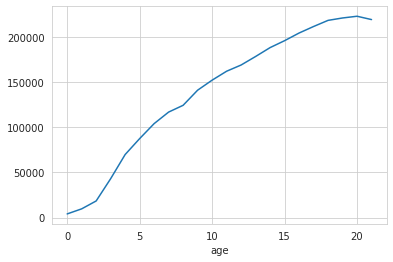

In [ ]:
df.groupby('age').mileage.mean().plot();

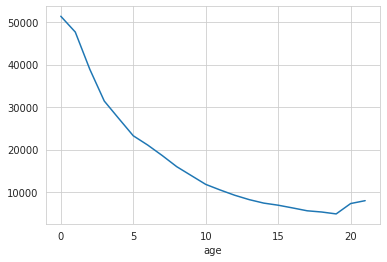

In [ ]:
df.groupby('age').price.mean().plot();

## type

In [ ]:
df['type'].value_counts(dropna=False)

Used                 61473
New                   3848
Demonstration         2038
Pre-registered        1101
NaN                   1071
Antique / Classic        1
Name: type, dtype: int64

In [ ]:
df.groupby('type').age.describe()


,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
Antique / Classic,1.0,21.000000,NaN,21.0,21.0,21.0,21.0,21.0
Demonstration,2038.0,1.557900,1.583957,0.0,1.0,1.0,2.0,19.0
New,3848.0,0.703222,0.561081,0.0,0.0,1.0,1.0,11.0
Pre-registered,1101.0,0.810173,0.406007,0.0,1.0,1.0,1.0,2.0
Used,61473.0,8.257381,5.241099,0.0,4.0,7.0,12.0,21.0


In [ ]:
df[df.type=='New'][['age']].value_counts(dropna=False)

age 
1.0     2442
0.0     1284
2.0      113
3.0        7
6.0        1
11.0       1
dtype: int64

- Elder than 1-year-old "New" cars are assigned "Used". (Anomaly Fixing)
- Count of "Antique / Classic" cars is 1. So we replace it "Used". (Diversity Reduction)

In [ ]:
df.loc[df[(df.type=='New')&(df.age>1)].index,'type']="Used"
df.loc[df[df.type=="Antique / Classic"].index,'type']='Used'
df.type.value_counts(dropna=False)

Used              61596
New                3726
Demonstration      2038
Pre-registered     1101
NaN                1071
Name: type, dtype: int64

In [ ]:
df.type.value_counts(dropna=False)

Used              61596
New                3726
Demonstration      2038
Pre-registered     1101
NaN                1071
Name: type, dtype: int64

- 0-year-old cars having NaN type should be `New` type
- Elder than 3-years-old cars having NaN type should be `Used` type.

In [ ]:
condition_1 = (df.type.isna()) & (df.age==0)
condition_2 = (df.type.isna()) & (df.age>3)

df.loc[condition_1,'type'] = 'New'
df.loc[condition_2,'type'] = 'Used'

In [ ]:
df.type.value_counts(dropna=False)

Used              62595
New                3739
Demonstration      2038
Pre-registered     1101
NaN                  59
Name: type, dtype: int64

In [ ]:
# Grup Sutunlarina(group_col1 ve group_col2) gore gruplayip, uzerinde calisilan sutunun(col_name) null degerlerini "mode" or "median" or "ffill & bfill ile doldurur.
fill(df, "make_model", "age", "type", "ffill") # method can be "mode" or "median" or "ffill"

Number of NaN :  0
------------------
Used              62629
New                3752
Demonstration      2046
Pre-registered     1105
Name: type, dtype: int64


## mileage

In [ ]:
perc_nans(df.mileage)

9.033250877293908

In [ ]:
df.mileage.value_counts(dropna=False).sort_index()

1000.0        48
1001.0        60
1002.0         5
1003.0         3
1004.0         1
            ... 
668451.0       1
686968.0       1
827190.0       1
973379.0       2
NaN         6281
Name: mileage, Length: 49344, dtype: int64

In [ ]:
# Average mileage and the frequency of the cars having NaN `mileage` according to `age`
df1 = df.groupby('age')['mileage'].mean().to_frame()
df2 = df[df.mileage.isna()]['age'].value_counts().sort_index().to_frame()

df3 = pd.concat([df1,df2], axis=1).rename(columns={'mileage':'avr_mileage', 
                                             'age':'freq_of_null_mileage_per_age'})
df3

,avr_mileage,freq_of_null_mileage_per_age
0.0,3998.642857,1575.0
1.0,9593.837390,4381.0
2.0,18329.558066,257.0
3.0,42961.917657,22.0
4.0,69675.669746,6.0
5.0,87295.259845,3.0
6.0,103880.709795,1.0
7.0,116646.039021,4.0
8.0,124142.384688,3.0
9.0,140847.631861,3.0


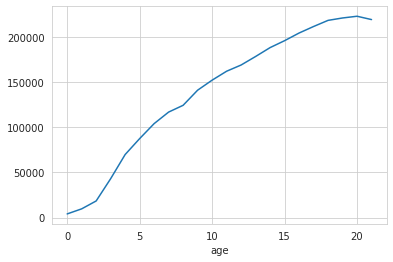

In [ ]:
# Lineplot of average mileage of the cars
df.groupby('age').mileage.mean().plot();

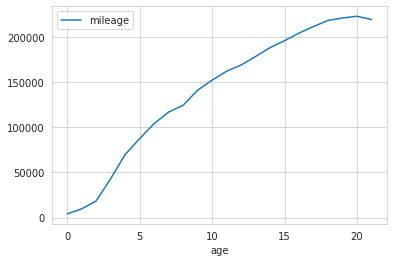

In [ ]:
df.mileage.fillna(df.groupby("age").mileage.transform("mean"), inplace=True)
df.groupby('age')['mileage'].mean().to_frame().plot();

In [ ]:
perc_nans(df.mileage)

0.0

## warranty

In [ ]:
perc_nans(df.warranty)

66.1709716389576

In [ ]:
df.warranty.unique()

array(['6', nan, '3', '1', '12', '60', '26', '24', '18', '36', '48', '2',
       '9', '10', '84', '4'], dtype=object)

In [ ]:
df.warranty = df.warranty.astype('float')
df.warranty.value_counts(dropna=False).sort_index()

1.0       267
2.0         8
3.0      1810
4.0         1
6.0     18502
9.0         2
10.0        1
12.0     1490
18.0       33
24.0     1152
26.0        2
36.0       13
48.0        7
60.0        3
84.0      231
NaN     46010
Name: warranty, dtype: int64

In [ ]:
# Diversity Reduction
df.loc[df[df.warranty<=3].index,'warranty'] = 3 #'0-3 months'
df.loc[df[(df.warranty>3)&(df.warranty<=6)].index,'warranty'] = 6 #'3-6 months'
df.loc[df[(df.warranty>6)&(df.warranty<=12)].index,'warranty'] = 12 #'6-12 months'
df.loc[df[(df.warranty>12)&(df.warranty<=24)].index,'warranty'] = 24 #'12-24 months'
df.loc[df[(df.warranty>24)&(df.warranty<=84)].index,'warranty'] = 84 #'24-84 months'

df.warranty.value_counts(dropna=False).sort_index()

3.0      2085
6.0     18503
12.0     1493
24.0     1185
84.0      256
NaN     46010
Name: warranty, dtype: int64

In [ ]:
df.groupby(['warranty']).age.describe()

,count,mean,std,min,25%,50%,75%,max
warranty,,,,,,,,
3.0,2085.0,8.722782,4.452337,1.0,6.0,8.0,11.0,21.0
6.0,18503.0,5.260660,3.666127,0.0,2.0,5.0,7.0,21.0
12.0,1493.0,2.829203,2.282561,0.0,1.0,2.0,4.0,21.0
24.0,1185.0,2.059072,1.770122,0.0,1.0,1.0,2.0,17.0
84.0,256.0,1.078125,1.428612,0.0,1.0,1.0,1.0,19.0


In [ ]:
df.groupby(['warranty']).mileage.describe()

,count,mean,std,min,25%,50%,75%,max
warranty,,,,,,,,
3.0,2085.0,130386.797850,66201.145374,1000.0,84560.00000,127499.00000,167258.00000,515252.0
6.0,18503.0,69042.475952,55327.356871,1000.0,20224.00000,59484.00000,103806.00000,433404.0
12.0,1493.0,36508.782556,36581.694696,1000.0,9593.83739,22110.00000,53075.00000,219788.0
24.0,1185.0,23784.033168,27960.007519,1000.0,9265.00000,10000.00000,28882.00000,196903.0
84.0,256.0,11708.220288,17786.595651,1209.0,9593.83739,9593.83739,9593.83739,234260.0


In [ ]:
df.groupby(['warranty']).price.describe()

,count,mean,std,min,25%,50%,75%,max
warranty,,,,,,,,
3.0,2085.0,17395.683453,12790.580302,999.0,8950.0,14900.0,22445.0,182500.0
6.0,18503.0,26031.531806,17788.824402,900.0,14949.0,21900.0,30935.0,236800.0
12.0,1493.0,37485.594776,19601.024602,3900.0,23750.0,34950.0,47995.0,250845.0
24.0,1185.0,48837.338397,26825.387818,7945.0,28950.0,41450.0,63950.0,189995.0
84.0,256.0,39897.269531,17966.346928,1095.0,29492.0,36995.0,45390.0,174950.0


The warranty feature having NaN values can be 0.

In [ ]:
df.warranty = df.warranty.fillna(0)
df.warranty.value_counts(dropna=False).sort_index()

0.0     46010
3.0      2085
6.0     18503
12.0     1493
24.0     1185
84.0      256
Name: warranty, dtype: int64

## SAVE_2

In [ ]:
df.to_pickle('/content/drive/MyDrive/Colab Notebooks/AutoScout24/backup_2.pkl')

In [ ]:
df=pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/AutoScout24/backup_2.pkl')

## colour

In [ ]:
df.colour.value_counts(dropna=False)

Grey      22941
Black     17657
White      9924
Blue       8650
Red        3136
Brown      1890
Silver     1812
NaN        1184
Green       869
Beige       563
Orange      361
Yellow      288
Violet      165
Gold         56
Bronze       36
Name: colour, dtype: int64

In [ ]:
perc_nans(df.colour)

1.7028130932520278

In [ ]:
df.groupby(['colour', 'body_type']).make_model.describe()

count unique                    top freq
colour body_type                                                
Beige  Compact             94     35            Skoda Fabia    9
       Convertible         35     16         Renault Megane   16
       Coupe                1      1  Mercedes-Benz CLK 320    1
       Off-Road/Pick-up   128     37         Hyundai Tucson   16
       Sedan               52     30              Volvo S60    5
...                       ...    ...                    ...  ...
Yellow Off-Road/Pick-up    48     23      Volkswagen Tiguan    9
       Sedan                9      6    Mercedes-Benz C 180    2
       Station wagon       19     12          Skoda Octavia    6
       Transporter         39     15   Ford Transit Connect   15
       Van                 23     11              Fiat 500L    5

[111 rows x 4 columns]

Fill the null values in "colour" by "ffill" according to "make_model" and "body_type".

In [ ]:
# Grup Sutunlarina(group_col1 ve group_col2) gore gruplayip, uzerinde calisilan sutunun(col_name) null degerlerini "mode" or "median" or "ffill & bfill ile doldurur.
fill(df, "make_model", "body_type", "colour", "ffill") # method can be "mode" or "median" or "ffill"

Number of NaN :  0
------------------
Grey      23262
Black     17918
White     10175
Blue       8807
Red        3225
Brown      1903
Silver     1853
Green       883
Beige       570
Orange      371
Yellow      301
Violet      170
Gold         58
Bronze       36
Name: colour, dtype: int64


In [ ]:
#  Diversity Reduction
df.colour = simplify_column(df.colour, threshold=0.001, value='Other')
df.colour.value_counts(dropna=False)

Grey      23262
Black     17918
White     10175
Blue       8807
Red        3225
Brown      1903
Silver     1853
Green       883
Beige       570
Orange      371
Yellow      301
Violet      170
Other        94
Name: colour, dtype: int64

## upholstery

In [ ]:
df.upholstery.value_counts(dropna=False,normalize=True)

Cloth           0.373008
Full leather    0.274277
NaN             0.170713
Part leather    0.151686
alcantara       0.015777
Other           0.007766
Velour          0.006774
Name: upholstery, dtype: float64

We can combine the types that related with each other

In [ ]:
#  Diversity Reduction
df.upholstery.replace(["Other","Velour", "alcantara", "Part leather", "Full leather"], [np.nan, "Cloth", "Part/Full Leather", "Part/Full Leather", "Part/Full Leather"], inplace=True)
df.upholstery.value_counts(dropna=False,normalize=True)

Part/Full Leather    0.441739
Cloth                0.379782
NaN                  0.178479
Name: upholstery, dtype: float64

In [ ]:
fill(df, "make_model", "body_type", "upholstery", "ffill")

Number of NaN :  0
------------------
Part/Full Leather    35829
Cloth                33703
Name: upholstery, dtype: int64


## upholstery_colour

In [ ]:
df.upholstery_colour.value_counts(dropna=False,normalize=True)

Black     0.483504
NaN       0.349249
Grey      0.086349
Beige     0.024751
Other     0.023975
Brown     0.017963
Red       0.004660
Blue      0.004617
White     0.004156
Orange    0.000345
Yellow    0.000244
Green     0.000187
Name: upholstery_colour, dtype: float64

In [ ]:
df.groupby(["make_model", 'upholstery']).upholstery_colour.describe()

count unique    top freq
make_model upholstery                                
Audi A1    Cloth               105      3  Black   75
           Part/Full Leather    28      3  Black   25
Audi A2    Cloth                10      3   Grey    6
           Part/Full Leather     3      1  Black    3
Audi A3    Cloth               456      6  Black  355
...                            ...    ...    ...  ...
Volvo XC60 Part/Full Leather   384      7  Black  286
Volvo XC70 Cloth                 2      2   Grey    1
           Part/Full Leather    79      5  Black   43
Volvo XC90 Cloth                 3      2  Black    2
           Part/Full Leather   331      7  Black  197

[1227 rows x 4 columns]

In [ ]:
fill(df, "make_model", "upholstery", "upholstery_colour", "ffill")

Number of NaN :  0
------------------
Black     51052
Grey       9982
Beige      2744
Other      2324
Brown      1851
Blue        525
Red         514
White       436
Orange       49
Yellow       37
Green        18
Name: upholstery_colour, dtype: int64


In [ ]:
v_counts(df, 'upholstery_colour')

upholstery_colour           
                   COUNT       RATE
Black              51052  73.422309
Grey                9982  14.355980
Beige               2744   3.946384
Other               2324   3.342346
Brown               1851   2.662084
Blue                 525   0.755048
Red                  514   0.739228
White                436   0.627049
Orange                49   0.070471
Yellow                37   0.053213
Green                 18   0.025887

In [ ]:
#  Diversity Reduction
df.upholstery_colour = simplify_column(df.upholstery_colour, threshold=0.001, value='Other')
df.upholstery_colour.value_counts(dropna=False)

Black    51052
Grey      9982
Beige     2744
Other     2428
Brown     1851
Blue       525
Red        514
White      436
Name: upholstery_colour, dtype: int64

##paint

In [ ]:
df.paint.value_counts(dropna=False,normalize=True)

Metallic    0.706567
NaN         0.293433
Name: paint, dtype: float64

In [ ]:
df.paint.fillna('No Metalic', inplace=True)

## previous_owner

In [ ]:
df.previous_owner.value_counts(dropna=False)

NaN    64683
1       2956
2       1299
3        386
4        132
5         41
6         14
7          8
8          7
9          2
10         2
14         1
12         1
Name: previous_owner, dtype: int64

In [ ]:
perc_nans(df.previous_owner)

93.02623252603118

the feature has too many missing values. we drop it.

In [ ]:
df = df.drop('previous_owner', axis=1)

## doors

In [ ]:
v_counts(df,"doors")

doors           
     COUNT       RATE
5    50480  72.599666
4     9376  13.484439
2     5742   8.258068
3     2526   3.632860
NaN   1310   1.884025
6       94   0.135190
1        4   0.005753

In [ ]:
fill(df, "make_model", "body_type", "doors", "mode")

Number of NaN :  0
------------------
5    51436
4     9620
2     5829
3     2549
6       94
1        4
Name: doors, dtype: int64


## seats

In [ ]:
v_counts(df,"seats")

seats           
     COUNT       RATE
5    51860  74.584364
4     6608   9.503538
NaN   5442   7.826612
2     2185   3.142438
7     2025   2.912328
3      992   1.426681
6      290   0.417074
8       64   0.092044
9       63   0.090606
1        2   0.002876
14       1   0.001438

In [ ]:
fill(df, "make_model", "body_type", "seats", "mode")

Number of NaN :  0
------------------
5     56098
4      7129
2      2529
7      2160
3      1179
6       301
9        67
8        66
1         2
14        1
Name: seats, dtype: int64


In [ ]:
df.seats = df.seats.astype('int')

In [ ]:
simplify_column(df.seats, threshold=0.001, value='8').value_counts(dropna=False)

5    56098
4     7129
2     2529
7     2160
3     1179
6      301
8      136
Name: seats, dtype: int64

In [ ]:
df.loc[df[(df.seats==1)|(df.seats==14)].index,['url','short_description','seats',"doors"]]

,url,short_description,seats,doors
16832,https://www.autoscout24.com/offers/ford-transit-2-0-tdci-l3h2-14-persoons-minibus-kleinbus-diesel-white-9dc6f9ef-d48f-4b25-a245-ebfc971c3c32?source=list_searchresults,Transit 2.0 TDCI L3H2 14 persoons Minibus Kleinbus,14,5
37402,https://www.autoscout24.com/offers/renault-kangoo-express-rolstoel-auto-zelf-rijder-automaat-1-6-16v-gasoline-yellow-2c7ffae0-3f44-46ba-884f-c160cde00b90?source=list_searchresults,Express rolstoel auto zelf rijder automaat 1.6-16V,1,5
38380,https://www.autoscout24.com/offers/renault-kangoo-maxi-1-5-dci-110-express-tech-line-airco-elek-pa-diesel-white-e3a2f484-c0f8-4f6d-bc13-36eb0f1ca925?source=list_searchresults,"Maxi 1.5 dCi 110 Express Tech Line- Airco, Elek Pa",1,5


In [ ]:
df.loc[df[df.seats==1].index,'seats']=2 # It was checked by url

In [ ]:
# Diversity reduction
df.seats = simplify_column(df.seats, threshold=0.001, value='8') # 8,9,14 doors are reduced to 8.
v_counts(df,"seats")

seats           
   COUNT       RATE
5  56098  80.679399
4   7129  10.252833
2   2531   3.640051
7   2160   3.106483
3   1179   1.695622
6    301   0.432894
8    134   0.192717

## cylinders

In [ ]:
df.cylinders = df.cylinders.astype('float')
v_counts(df,"cylinders")

cylinders           
        COUNT       RATE
4.0     46556  66.956222
3.0      8484  12.201576
NaN      6281   9.033251
6.0      4661   6.703388
5.0      1533   2.204740
8.0      1028   1.478456
1.0       554   0.796755
2.0       433   0.622735
7.0         2   0.002876

In [ ]:
# Diversity reduction
df.cylinders = df.cylinders.replace(7.0, np.nan)

In [ ]:
fill(df, "make_model", "body_type", "cylinders", "mode")

Number of NaN :  0
------------------
4.0    48634
3.0     9013
6.0     4739
1.0     3760
5.0     1540
8.0     1109
2.0      737
Name: cylinders, dtype: int64


## drivetrain

In [ ]:
df["drivetrain"].value_counts(dropna=False)

Front    37214
NaN      16160
4WD       8113
Rear      8045
Name: drivetrain, dtype: int64

In [ ]:
fill(df, "make_model", "body_type", "drivetrain", "mode")

Number of NaN :  0
------------------
Front    49927
Rear     10388
4WD       9217
Name: drivetrain, dtype: int64


## emission_class

In [ ]:
df.emission_class.value_counts(dropna=False)

Euro 6    24872
NaN       21869
Euro 5    11754
Euro 4     8475
Euro 3     1893
Euro 1      520
Euro 2      149
Name: emission_class, dtype: int64

In [ ]:
df.groupby(['emission_class']).co2_emissions.describe()

,count,mean,std,min,25%,50%,75%,max
emission_class,,,,,,,,
Euro 1,520.0,135.935577,59.240034,0.0,98.0,129.0,166.0,387.0
Euro 2,149.0,204.765101,51.616588,119.0,166.0,194.0,228.0,405.0
Euro 3,1893.0,197.563127,46.658320,89.0,165.0,189.0,223.0,356.0
Euro 4,8475.0,186.771917,42.700778,9.0,158.0,180.0,208.0,392.0
Euro 5,11754.0,145.146886,35.924007,0.0,119.0,144.0,166.0,370.0
Euro 6,24872.0,117.057695,38.047283,0.0,102.0,119.0,137.0,370.0


In [ ]:
fill(df, "make_model", "fuel_type", "emission_class", "mode")

Number of NaN :  0
------------------
Euro 6    40143
Euro 5    14344
Euro 4    11172
Euro 3     2321
Euro 1     1388
Euro 2      164
Name: emission_class, dtype: int64


## gearbox

In [ ]:
df.gearbox.value_counts(dropna=False)

Automatic    40624
Manual       28120
NaN            788
Name: gearbox, dtype: int64

In [ ]:
fill(df, "make_model", "body_type", "gearbox", "mode")

Number of NaN :  0
------------------
Automatic    41182
Manual       28350
Name: gearbox, dtype: int64


## gears

In [ ]:
df.gears.value_counts(dropna=False)

6      20769
NaN    20257
5      11975
7       7642
8       5430
1       1741
9        996
4        674
2         40
3          8
Name: gears, dtype: int64

In [ ]:
df.gears = df.gears.astype('float')

In [ ]:
fill(df, "make_model", "body_type", "gears", "mode")

Number of NaN :  0
------------------
6.0    29519
5.0    16325
7.0     9713
8.0     7433
1.0     4520
9.0     1269
4.0      705
2.0       40
3.0        8
Name: gears, dtype: int64


In [ ]:
# Diversity reduction
df.gears = simplify_column(df.gears, threshold=0.001, value='mode')
v_counts(df,"gears")

gears           
     COUNT       RATE
6.0  29567  42.522867
5.0  16325  23.478398
7.0   9713  13.969108
8.0   7433  10.690042
1.0   4520   6.500604
9.0   1269   1.825059
4.0    705   1.013922

## power

In [ ]:
perc_nans(df.power)

8.601794857044238

In [ ]:
df.power = df.power.astype('float')
df.power.value_counts(dropna=False)

NaN      5981
150.0    4083
120.0    2806
136.0    2479
122.0    2421
         ... 
352.0       1
18.0        1
377.0       1
434.0       1
14.0        1
Name: power, Length: 366, dtype: int64

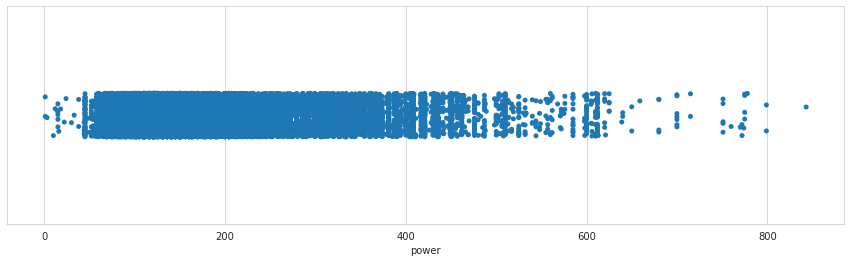

In [ ]:
plt.figure(figsize=(15,4))
sns.stripplot(x=df.power);

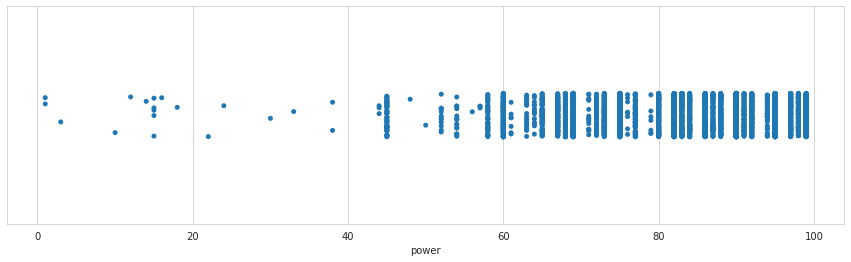

In [ ]:
plt.figure(figsize=(15,4))
sns.stripplot(x=df.power[df.power<=100]);

In [ ]:
df[df.power<51].groupby(["make_model"]).power.describe()

,count,mean,std,min,25%,50%,75%,max
make_model,,,,,,,,
Audi A3,1.0,12.000000,NaN,12.0,12.00,12.0,12.00,12.0
Audi A4,1.0,3.000000,NaN,3.0,3.00,3.0,3.00,3.0
BMW i3,3.0,35.333333,4.618802,30.0,34.00,38.0,38.00,38.0
Dacia Spring,54.0,45.000000,0.000000,45.0,45.00,45.0,45.00,45.0
Fiat 500e,1.0,33.000000,NaN,33.0,33.00,33.0,33.00,33.0
Ford Puma,1.0,10.000000,NaN,10.0,10.00,10.0,10.00,10.0
Hyundai Ioniq,1.0,44.000000,NaN,44.0,44.00,44.0,44.00,44.0
Hyundai Kona,2.0,44.000000,0.000000,44.0,44.00,44.0,44.00,44.0
Kia Stonic,1.0,16.000000,NaN,16.0,16.00,16.0,16.00,16.0


- There is no cars under 51 hp. 

In [ ]:
indexes = df[df.power<51].index
df.loc[indexes,'power']=np.nan

In [ ]:
fill(df, "make_model", "body_type", "power", "median")

Number of NaN :  0
------------------
150.0    4515
120.0    2856
136.0    2679
122.0    2565
116.0    2416
         ... 
613.0       1
377.0       1
384.5       1
187.0       1
575.0       1
Name: power, Length: 368, dtype: int64


## engine_size


In [ ]:
df.engine_size.value_counts(dropna=False)

NaN       11257
1598.0     4818
1998.0     2923
1199.0     2487
1395.0     2336
          ...  
3495.0        1
1405.0        1
6466.0        1
3556.0        1
2499.0        1
Name: engine_size, Length: 430, dtype: int64

In [ ]:
perc_nans(df.engine_size)

16.189668066501756

In [ ]:
fill(df, "make_model", "body_type", "engine_size", "median")

Number of NaN :  0
------------------
1598.0    8823
1998.0    2954
1199.0    2893
1498.0    2587
1395.0    2540
          ... 
3556.0       1
7440.0       1
5980.0       1
3952.0       1
2499.0       1
Name: engine_size, Length: 447, dtype: int64


## SAVE_3

In [ ]:
df.to_pickle('/content/drive/MyDrive/Colab Notebooks/AutoScout24/backup_3.pkl')

In [ ]:
df=pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/AutoScout24/backup_3.pkl')

## empty_weight

In [ ]:
perc_nans(df.empty_weight)

7.0140367025254555

In [ ]:
df.empty_weight.value_counts(dropna=False).sort_index()

1000.0      96
1001.0      13
1002.0      19
1003.0       1
1004.0      41
          ... 
3647.0       1
3745.0       1
3960.0       1
4200.0       1
NaN       4877
Name: empty_weight, Length: 1416, dtype: int64

In [ ]:
fill(df, "make_model", "body_type", "empty_weight", "median")

Number of NaN :  0
------------------
1295.0    1763
1065.0    1360
1405.0    1297
1395.0    1091
1635.0     885
          ... 
2299.0       1
2419.0       1
2625.0       1
2293.0       1
2147.0       1
Name: empty_weight, Length: 1445, dtype: int64


In [ ]:
perc_nans(df.empty_weight)

0.0

## comfort_convenience

In [ ]:
perc_nans(df.comfort_convenience)

0.0

In [ ]:
df.comfort_convenience

0                                                                                                                                                          [Air conditioning, Armrest, Automatic climate control, Electrical side mirrors, Navigation system, Power windows, Sunroof]
1                                                                                                                                                                    [Air conditioning, Automatic climate control, Electrical side mirrors, Light sensor, Power windows, Rain sensor]
2                                                                                                    [Air conditioning, Armrest, Cruise control, Electrical side mirrors, Leather steering wheel, Multi-function steering wheel, Navigation system, Power windows, Start-stop system]
3                                                                                           [Air conditioning, Armrest, Automatic climate control, Cruise control, Nav

Replacement of some list items:
- 'Automatic climate control, 2 zones'  >> 'Automatic climate control 2 zones'
- 'Automatic climate control, 3 zones'  >> 'Automatic climate control 3 zones'
- 'Automatic climate control, 4 zones'  >> 'Automatic climate control 4 zones'

In [ ]:
for i in df.comfort_convenience.index:
  df['comfort_convenience'].loc[i] = list(map(lambda x: re.sub(r', ', ' ', x), df.loc[i,'comfort_convenience']))

Display all `comfort_convenience` items. Check for any anomalies.

In [ ]:
cc_set={"Air conditioning"}
for i in df.comfort_convenience.index:
  cc_set = cc_set.union(df.loc[i,'comfort_convenience'])
cc_set

{'360° camera',
 'Air conditioning',
 'Air suspension',
 'Armrest',
 'Automatic climate control',
 'Automatic climate control 2 zones',
 'Automatic climate control 3 zones',
 'Automatic climate control 4 zones',
 'Auxiliary heating',
 'Cruise control',
 'Electric backseat adjustment',
 'Electric tailgate',
 'Electrical side mirrors',
 'Electrically adjustable seats',
 'Electrically heated windshield',
 'Fold flat passenger seat',
 'Heads-up display',
 'Heated steering wheel',
 'Hill Holder',
 'Keyless central door lock',
 'Leather seats',
 'Leather steering wheel',
 'Light sensor',
 'Lumbar support',
 'Massage seats',
 'Multi-function steering wheel',
 'Navigation system',
 'Panorama roof',
 'Park Distance Control',
 'Parking assist system camera',
 'Parking assist system self-steering',
 'Parking assist system sensors front',
 'Parking assist system sensors rear',
 'Power windows',
 'Rain sensor',
 'Seat heating',
 'Seat ventilation',
 'Sliding door left',
 'Sliding door right',
 'Spl

In [ ]:
# There is no Nan value.
# fill(df, "make_model", "body_type", "comfort_convenience", "mode")

In [ ]:
df.comfort_convenience.str.join(',').str.get_dummies(sep = ",").add_prefix("cc_")

,cc_360° camera,cc_Air conditioning,cc_Air suspension,cc_Armrest,cc_Automatic climate control,cc_Automatic climate control 2 zones,cc_Automatic climate control 3 zones,cc_Automatic climate control 4 zones,cc_Auxiliary heating,cc_Cruise control,cc_Electric backseat adjustment,cc_Electric tailgate,cc_Electrical side mirrors,cc_Electrically adjustable seats,cc_Electrically heated windshield,cc_Fold flat passenger seat,cc_Heads-up display,cc_Heated steering wheel,cc_Hill Holder,cc_Keyless central door lock,cc_Leather seats,cc_Leather steering wheel,cc_Light sensor,cc_Lumbar support,cc_Massage seats,cc_Multi-function steering wheel,cc_Navigation system,cc_Panorama roof,cc_Park Distance Control,cc_Parking assist system camera,cc_Parking assist system self-steering,cc_Parking assist system sensors front,cc_Parking assist system sensors rear,cc_Power windows,cc_Rain sensor,cc_Seat heating,cc_Seat ventilation,cc_Sliding door left,cc_Sliding door right,cc_Split rear seats,cc_Start-stop system,cc_Sunroof,cc_Tinted windows,cc_Wind deflector
0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0
4,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69527,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
69528,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
69529,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
69530,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = df.join(df.comfort_convenience.str.join(',').str.get_dummies(sep = ",").add_prefix("cc_"))

In [ ]:
df.drop('comfort_convenience', axis=1, inplace=True)

## entertainment_media

In [ ]:
perc_nans(df.entertainment_media)

0.0

In [ ]:
df.entertainment_media

0                                                                 [CD player, Radio]
1                                                                 [CD player, Radio]
2        [Bluetooth, CD player, Hands-free equipment, MP3, On-board computer, Radio]
3                                     [Bluetooth, CD player, On-board computer, USB]
4                                         [CD player, MP3, On-board computer, Radio]
                                            ...                                     
69527                                          [CD player, On-board computer, Radio]
69528                                                                        [Radio]
69529                                                            [On-board computer]
69530                                          [CD player, On-board computer, Radio]
69531                                                     [On-board computer, Radio]
Name: entertainment_media, Length: 69532, dtype: object

Display all `entertainment_media` items. Check for any anomalies.

In [ ]:
cc_set={"CD player"}
for i in df.entertainment_media.index:
  cc_set = cc_set.union(df.loc[i,'entertainment_media'])
cc_set

{'Android Auto',
 'Apple CarPlay',
 'Bluetooth',
 'CD player',
 'Digital cockpit',
 'Digital radio',
 'Hands-free equipment',
 'Induction charging for smartphones',
 'Integrated music streaming',
 'MP3',
 'On-board computer',
 'Radio',
 'Sound system',
 'Television',
 'USB',
 'WLAN / WiFi hotspot'}

In [ ]:
# There is no Nan value.
# fill(df, "make_model", "body_type", "entertainment_media", "mode")

In [ ]:
df.entertainment_media.str.join(',').str.get_dummies(sep = ",").add_prefix("em_")

,em_Android Auto,em_Apple CarPlay,em_Bluetooth,em_CD player,em_Digital cockpit,em_Digital radio,em_Hands-free equipment,em_Induction charging for smartphones,em_Integrated music streaming,em_MP3,em_On-board computer,em_Radio,em_Sound system,em_Television,em_USB,em_WLAN / WiFi hotspot
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0
3,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69527,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
69528,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
69529,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
69530,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0


In [ ]:
df = df.join(df.entertainment_media.str.join(',').str.get_dummies(sep = ",").add_prefix("em_"))

In [ ]:
df.drop("entertainment_media", axis=1, inplace=True)

## safety_security

In [ ]:
perc_nans(df.safety_security)

0.0

In [ ]:
df.safety_security

0                                                                                        [ABS, Alarm system, Central door lock, Central door lock with remote control, Driver-side airbag, Electronic stability control, Fog lights, Head airbag, Immobilizer, Passenger-side airbag, Power steering, Side airbag, Traction control]
1                                                                                                                                                                                                                                  [Alarm system, Central door lock, Central door lock with remote control, Fog lights, Immobilizer]
2                                                                                                                       [ABS, Central door lock, Central door lock with remote control, Driver-side airbag, Electronic stability control, Immobilizer, Isofix, Passenger-side airbag, Power steering, Side airbag, Traction control]
3                        

Display all `safety_security` items. Check for any anomalies.

In [ ]:
cc_set={"ABS"}
for i in df.safety_security.index:
  cc_set = cc_set.union(df.loc[i,'safety_security'])
cc_set

{'ABS',
 'Adaptive Cruise Control',
 'Adaptive headlights',
 'Alarm system',
 'Bi-Xenon headlights',
 'Blind spot monitor',
 'Central door lock',
 'Central door lock with remote control',
 'Daytime running lights',
 'Distance warning system',
 'Driver drowsiness detection',
 'Driver-side airbag',
 'Electronic stability control',
 'Emergency brake assistant',
 'Emergency system',
 'Fog lights',
 'Full-LED headlights',
 'Glare-free high beam headlights',
 'Head airbag',
 'High beam assist',
 'Immobilizer',
 'Isofix',
 'LED Daytime Running Lights',
 'LED Headlights',
 'Lane departure warning system',
 'Laser headlights',
 'Night view assist',
 'Passenger-side airbag',
 'Power steering',
 'Rear airbag',
 'Side airbag',
 'Speed limit control system',
 'Tire pressure monitoring system',
 'Traction control',
 'Traffic sign recognition',
 'Xenon headlights'}

In [ ]:
# There is no Nan value.
# fill(df, "make_model", "body_type", "safety_security", "mode")

In [ ]:
df.safety_security.str.join(',').str.get_dummies(sep = ",").add_prefix("ss_")

,ss_ABS,ss_Adaptive Cruise Control,ss_Adaptive headlights,ss_Alarm system,ss_Bi-Xenon headlights,ss_Blind spot monitor,ss_Central door lock,ss_Central door lock with remote control,ss_Daytime running lights,ss_Distance warning system,ss_Driver drowsiness detection,ss_Driver-side airbag,ss_Electronic stability control,ss_Emergency brake assistant,ss_Emergency system,ss_Fog lights,ss_Full-LED headlights,ss_Glare-free high beam headlights,ss_Head airbag,ss_High beam assist,ss_Immobilizer,ss_Isofix,ss_LED Daytime Running Lights,ss_LED Headlights,ss_Lane departure warning system,ss_Laser headlights,ss_Night view assist,ss_Passenger-side airbag,ss_Power steering,ss_Rear airbag,ss_Side airbag,ss_Speed limit control system,ss_Tire pressure monitoring system,ss_Traction control,ss_Traffic sign recognition,ss_Xenon headlights
0,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0
3,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0
4,1,0,0,1,1,0,1,1,0,0,0,1,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,1,0,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69527,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0
69528,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0
69529,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
69530,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0


In [ ]:
df = df.join(df.safety_security.str.join(',').str.get_dummies(sep = ",").add_prefix("ss_"))

In [ ]:
df.drop("safety_security", axis=1, inplace=True)

## extras

In [ ]:
perc_nans(df.extras)

0.0

In [ ]:
df.extras

0                                                                 [Alloy wheels]
1                                                           [Alloy wheels (16")]
2                                                        [Alloy wheels, Spoiler]
3                                                           [Alloy wheels (15")]
4             [Alloy wheels (17"), Shift paddles, Sport seats, Sport suspension]
                                          ...                                   
69527                                                       [Alloy wheels (15")]
69528                                                       [Alloy wheels (17")]
69529                [Alloy wheels (17"), Automatically dimming interior mirror]
69530    [Alloy wheels (16"), Automatically dimming interior mirror, Spare tyre]
69531                                                             [Alloy wheels]
Name: extras, Length: 69532, dtype: object

Display all `extras` items. Check for any anomalies.

In [ ]:
cc_set={"Alloy wheels"}
for i in df.extras.index:
  cc_set = cc_set.union(df.loc[i,'extras'])
cc_set

{'"Smoker\'s package"',
 '"Smoker\'s package", \'Sport seats',
 'All season tyres',
 'Alloy wheels',
 'Alloy wheels (11")',
 'Alloy wheels (12")',
 'Alloy wheels (13")',
 'Alloy wheels (14")',
 'Alloy wheels (15")',
 'Alloy wheels (15")\', "Smoker\'s package", \'Spare tyre',
 'Alloy wheels (15")\', "Smoker\'s package", \'Spoiler',
 'Alloy wheels (16")',
 'Alloy wheels (16")\', "Smoker\'s package"',
 'Alloy wheels (16")\', "Smoker\'s package", \'Sport suspension',
 'Alloy wheels (16")\', "Smoker\'s package", \'Trailer hitch',
 'Alloy wheels (17")',
 'Alloy wheels (17")\', "Smoker\'s package", \'Spare tyre',
 'Alloy wheels (17")\', "Smoker\'s package", \'Spoiler',
 'Alloy wheels (17")\', "Smoker\'s package", \'Sport package',
 'Alloy wheels (17")\', "Smoker\'s package", \'Sport suspension',
 'Alloy wheels (17")\', "Smoker\'s package", \'Summer tyres',
 'Alloy wheels (18")',
 'Alloy wheels (18")\', "Smoker\'s package", \'Sport seats',
 'Alloy wheels (19")',
 'Alloy wheels (20")',
 'Alloy 

In [ ]:
df.extras = df.extras.str.join(',').str.replace("\\","").str.replace("'","").str.replace(r'\s\W\d\d"\W',"").str.replace('"',"").str.replace(', ',",").str.split(',')

In [ ]:
cc_set={"Alloy wheels"}
for i in df.extras.index:
  cc_set = cc_set.union(df.loc[i,'extras'])
cc_set

{'All season tyres',
 'Alloy wheels',
 'Ambient lighting',
 'Automatically dimming interior mirror',
 'Awning',
 'Biodiesel conversion',
 'Cargo barrier',
 'Catalytic Converter',
 'Double cabin',
 'E10-enabled',
 'Electronic parking brake',
 'Emergency tyre',
 'Emergency tyre repair kit',
 'Handicapped enabled',
 'Headlight washer system',
 'Range extender',
 'Right hand drive',
 'Roof rack',
 'Shift paddles',
 'Ski bag',
 'Sliding door',
 'Smokers package',
 'Spare tyre',
 'Spoiler',
 'Sport package',
 'Sport seats',
 'Sport suspension',
 'Steel wheels',
 'Summer tyres',
 'Touch screen',
 'Trailer hitch',
 'Tuned car',
 'Voice Control',
 'Winter package',
 'Winter tyres'}

In [ ]:
# There is no Nan value.
# fill(df, "make_model", "body_type", "extras", "mode")

In [ ]:
df = df.join(df.extras.str.join(',').str.get_dummies(sep = ",").add_prefix("ex_"))

In [ ]:
df.drop("extras", axis=1, inplace=True)

## last_timing_belt_change

In [ ]:
perc_nans(df.last_timing_belt_change)

98.63659897601104

In [ ]:
df.drop('last_timing_belt_change', axis=1, inplace=True)

## non_smoker_vehicle

In [ ]:
# df.non_smoker_vehicle.value_counts()
v_counts(df,'non_smoker_vehicle')

non_smoker_vehicle           
                 COUNT       RATE
No               63922  91.931772
Yes               5610   8.068228

## seller

In [ ]:
v_counts(df,'seller')

seller           
         COUNT       RATE
Dealer   63474  91.287465
Private   6058   8.712535

## full_service_history

In [ ]:
v_counts(df,'full_service_history')

full_service_history           
                   COUNT       RATE
Yes                47569  68.413105
No                 21963  31.586895

## emissions_sticker

In [ ]:
v_counts(df,'emissions_sticker')

emissions_sticker           
                   COUNT       RATE
NaN                69404  99.815912
Green                122   0.175459
Yellow                 4   0.005753
Red                    2   0.002876

In [ ]:
perc_nans(df.emissions_sticker)

99.8159120980268

In [ ]:
df.drop('emissions_sticker', axis=1, inplace=True)

## fuel_consumption_mean

In [ ]:
df.fuel_consumption_mean.value_counts(dropna=False).sort_index()

0.0       513
0.1         1
0.9         1
1.0         3
1.1         3
        ...  
82.0        1
94.0        2
99.0        2
99.9       13
NaN     21230
Name: fuel_consumption_mean, Length: 159, dtype: int64

cleaning of anomaly values

In [ ]:
df[df.fuel_consumption_mean>18][['make_model','body_type','power','fuel_consumption_mean']]

,make_model,body_type,power,fuel_consumption_mean
254,Audi A5,Compact,150.0,99.9
3622,Audi A3,Compact,111.0,99.0
4250,Audi A6,Station wagon,204.0,47.0
5376,Audi A3,Compact,204.0,55.5
6454,BMW 420,Compact,184.0,99.9
9467,BMW 530,Sedan,184.0,47.0
11063,BMW X3,Off-Road/Pick-up,143.0,18.5
14581,Ford Puma,Off-Road/Pick-up,125.0,43.3
15873,Ford Fiesta,Compact,82.0,23.3
24954,Opel Crossland X,Compact,111.0,99.9


In [ ]:
df.loc[df[df.fuel_consumption_mean>18].index,'fuel_consumption_mean']= np.nan
df.loc[df[df.fuel_consumption_mean<3].index, 'fuel_consumption_mean']= np.nan
df.loc[df[df.fuel_type=='Electric'].index,'fuel_consumption_mean']= 0

In [ ]:
df[(df.fuel_type=='Others')&(df.fuel_consumption_mean.isna())][['make_model','body_type','age','fuel_type','fuel_consumption_mean']]

,make_model,body_type,age,fuel_type,fuel_consumption_mean
34643,Volkswagen ID.3,Compact,1.0,Others,NaN
45263,Fiat 500,Compact,1.0,Others,NaN
45264,Fiat 500,Compact,2.0,Others,NaN
47298,Hyundai iX35,Off-Road/Pick-up,8.0,Others,NaN
47904,Hyundai Nexo,Off-Road/Pick-up,2.0,Others,NaN
48816,Hyundai Nexo,Off-Road/Pick-up,1.0,Others,NaN
48818,Hyundai Nexo,Off-Road/Pick-up,2.0,Others,NaN
48819,Hyundai Nexo,Off-Road/Pick-up,2.0,Others,NaN
48820,Hyundai Nexo,Off-Road/Pick-up,0.0,Others,NaN
48821,Hyundai Nexo,Off-Road/Pick-up,1.0,Others,NaN


In [ ]:
df.loc[df[(df.make_model=="Hyundai Nexo")&(df.fuel_type=='Others')&(df.fuel_consumption_mean.isna())].index,'fuel_consumption_mean']=0 # Hydrogen
df.loc[df[(df.make_model=="Toyota Mirai")&(df.fuel_type=='Others')&(df.fuel_consumption_mean.isna())].index,'fuel_consumption_mean']=0 # Hydrogen
df.loc[df[(df.make_model=="Volkswagen ID.3")&(df.fuel_type=='Others')&(df.fuel_consumption_mean.isna())].index,'fuel_consumption_mean']=0 # Electric
df.loc[df[(df.make_model=="Volkswagen ID.3")&(df.fuel_type=='Others')&(df.fuel_consumption_mean.isna())].index,'fuel_type']="Electric" # Electric
df.loc[df[(df.make_model=="Kia Soul")&(df.fuel_type=='Others')&(df.fuel_consumption_mean.isna())].index,'fuel_type']="Gasoline"
df.loc[df[(df.make_model=="Hyundai iX35")&(df.fuel_type=='Others')&(df.fuel_consumption_mean.isna())].index,'fuel_type']="Diesel"
df.loc[df[(df.make_model=="Fiat 500")&(df.fuel_type=='Others')&(df.fuel_consumption_mean.isna())].index,'fuel_type']="Gasoline"

In [ ]:
perc_nans(df.fuel_consumption_mean)

23.363343496519587

In [ ]:
fill(df, "make_model", "body_type", 'fuel_consumption_mean', "median")

Number of NaN :  0
------------------
0.00     6301
5.20     2529
5.90     2336
6.00     2306
5.40     2205
         ... 
16.50       1
16.70       1
15.80       1
16.40       1
7.85        1
Name: fuel_consumption_mean, Length: 205, dtype: int64


## fuel_consumption_city

this column correlated with fuel_consumption_mean. So, we drop it.

In [ ]:
df.drop('fuel_consumption_city', axis=1, inplace=True)

## fuel_consumption_country

this column correlated with fuel_consumption_mean. So, we drop it.

In [ ]:
df.drop('fuel_consumption_country', axis=1, inplace=True)

## province

In [ ]:
perc_nans(df.province)

14.95282747511937

In [ ]:
df['province'] = df['province'].fillna(method='ffill').fillna(method='bfill')

In [ ]:
perc_nans(df.province)

0.0

## Check NaN Values

In [ ]:
drop_columns=[
              'location', # unneccessary after the feature engineering
              'url', # useless
              # 'make', 
              # 'model', 
              'short_description', # complicated data ---------------------->
              # 'price',
              # 'mileage', 
              # 'gearbox', 
              # 'registration', 
              # 'fuel_type', 
              # 'power', 
              # 'seller',
              # 'body_type', 
              # 'type', 
              # 'drivetrain', 
              # 'seats', 
              # 'doors', 
              'country_version', # null
              'offer_number', # useless
              # 'warranty', 
              'Mileage', # dublicate column
              'first_registration',  # unneccessary after the feature engineering
              'production_date', # null
              'general_inspection', # unneccessary after the feature engineering
              'last_service', #null
              # 'full_service_history', 
              # 'non_smoker_vehicle', 
              # 'previous_owner'
              # 'last_timing_belt_change', # null, droped above
              'Power', # dublicate column
              'Gearbox', # dublicate column
              # 'engine_size', 
              # 'gears', 
              # 'cylinders', 
              # 'empty_weight', 
              'Fuel_type',# dublicate column
              # 'fuel_consumption', 
              # 'co2_emissions', 
              # 'emission_class',
              # 'emissions_sticker', # null, droped above
              # '\nComfort & Convenience\n', 
              # '\nEntertainment & Media\n',
              # '\nSafety & Security\n',
              # 'extras', 
              # '\ncolour', # dublicate column
              'manufacturer_color', # null
              # '\npaint',
              # ' upholstery_colour ',
              # ' upholstery ',
]
df.drop(drop_columns, axis = 1, inplace=True)

In [ ]:
df.isnull().sum().sum()

0

## SAVE_4

In [ ]:
df.to_pickle('/content/drive/MyDrive/Colab Notebooks/AutoScout24/backup_4.pkl')

In [ ]:
df=pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/AutoScout24/backup_4.pkl')
show_nans(df,0.1)


Series([], dtype: float64)

In [ ]:
df.head(1)

,make,model,price,mileage,gearbox,fuel_type,power,seller,body_type,type,drivetrain,seats,doors,warranty,full_service_history,non_smoker_vehicle,engine_size,gears,cylinders,empty_weight,co2_emissions,emission_class,colour,paint,upholstery_colour,upholstery,inspection_new,fuel_consumption_mean,make_model,age,make_country,province,cc_360° camera,cc_Air conditioning,cc_Air suspension,cc_Armrest,cc_Automatic climate control,cc_Automatic climate control 2 zones,cc_Automatic climate control 3 zones,cc_Automatic climate control 4 zones,cc_Auxiliary heating,cc_Cruise control,cc_Electric backseat adjustment,cc_Electric tailgate,cc_Electrical side mirrors,cc_Electrically adjustable seats,cc_Electrically heated windshield,cc_Fold flat passenger seat,cc_Heads-up display,cc_Heated steering wheel,...,ss_Isofix,ss_LED Daytime Running Lights,ss_LED Headlights,ss_Lane departure warning system,ss_Laser headlights,ss_Night view assist,ss_Passenger-side airbag,ss_Power steering,ss_Rear airbag,ss_Side airbag,ss_Speed limit control system,ss_Tire pressure monitoring system,ss_Traction control,ss_Traffic sign recognition,ss_Xenon headlights,ex_All season tyres,ex_Alloy wheels,ex_Ambient lighting,ex_Automatically dimming interior mirror,ex_Awning,ex_Biodiesel conversion,ex_Cargo barrier,ex_Catalytic Converter,ex_Double cabin,ex_E10-enabled,ex_Electronic parking brake,ex_Emergency tyre,ex_Emergency tyre repair kit,ex_Handicapped enabled,ex_Headlight washer system,ex_Range extender,ex_Right hand drive,ex_Roof rack,ex_Shift paddles,ex_Ski bag,ex_Sliding door,ex_Smokers package,ex_Spare tyre,ex_Spoiler,ex_Sport package,ex_Sport seats,ex_Sport suspension,ex_Steel wheels,ex_Summer tyres,ex_Touch screen,ex_Trailer hitch,ex_Tuned car,ex_Voice Control,ex_Winter package,ex_Winter tyres
0,Audi,A3,4450.0,191066.0,Automatic,Gasoline,150.0,Dealer,Compact,Used,Front,5,3,6.0,Yes,No,1984.0,6.0,4.0,1280.0,119.0,Euro 4,Grey,Metallic,Black,Cloth,1.0,5.2,Audi A3,19.0,Germany,North Brabant,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 3-Outlier Analysis

## METHODS

In [ ]:
import inspect
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var][0]

def v_counts(df, s):
  s1 = df[s].value_counts(dropna=False)
  s2 = df[s].value_counts(dropna=False, normalize=True)*100
  multicol1 = pd.MultiIndex.from_tuples([(s, 'COUNT'),
                                       (s, 'RATE')])
  s3 = pd.concat([s1, s2], axis=1, keys=multicol1)
  return s3

def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    display(str.sort_values(by='Nulls', ascending=False))

!pip install colorama
import re
def column_details(regex, df):
  # We will focus on each column in detail
  # Uniqe Values, DTYPE, NUNIQUE, NULL_RATE
  cols=[col for col in df.columns if re.search(regex, col)]

  from colorama import Fore, Back, Style

  print('Unique Values of the Features:\nfeature: DTYPE, NUNIQUE, NULL_RATE\n')
  for i in df[cols]:
      color = Fore.RED if df[i].dtype =='float64' else Fore.BLUE if df[i].dtype =='int64' else Fore.GREEN
      print(f'{i}: {color} {df[i].dtype}, {df[i].nunique()}, %{round(df[i].isna().sum()/len(df[i])*100,2)}\n{Style.RESET_ALL}{pd.Series(df[i].unique()).sort_values().values}\n')
    

In [ ]:
from scipy.stats.mstats import winsorize
def col_plot(df,col_name,up=0.1,down=0, iqr=1.5):
  
  f_sqrt=lambda x:(np.sqrt(x) if x>1 else -np.sqrt(-x) if x<-1 else x)
  f_log=lambda x:(np.log(x)+1 if x>1 else -np.log(-x)-1 if x<-1 else x)
  root= df[col_name].apply(f_sqrt)
  log= df[col_name].apply(f_log)
  winsor= winsorize(df[col_name], (down,up))
  root_winsor=winsorize(df[col_name].apply(f_sqrt), (down,up))

  plt.figure(figsize=(35,15))
  plt.suptitle(col_name,fontsize=20)

  plt.subplot(251) # üç sigma aralikta(verinin %99.7 sini icine almasi beklenen bolum) iki kirmizi cizgi arasinda
  plt.hist(df[col_name], bins = 20)
  plt.axvline(x=df[col_name].mean() + 3*df[col_name].std(),color='red')
  plt.axvline(x=df[col_name].mean() - 3*df[col_name].std(),color='red')
  plt.tight_layout
  plt.xlabel("Histogram ±3z")
  plt.ylabel(col_name)

  plt.subplot(252) # üç sigma aralikta(verinin %99.7 sini icine almasi beklenen bolum) iki kirmizi cizgi arasinda
  plt.hist(winsor, bins = 22)
  plt.axvline(x=winsor.mean()+3*winsor.std(),color='red')
  plt.axvline(x=winsor.mean()-3*winsor.std(),color='red')
  plt.xlabel('WINSORIZE_Histogram ±3z')
  plt.ylabel(col_name)
  plt.tight_layout

  plt.subplot(253)
  plt.hist(root, bins=22)
  plt.axvline(x=root.mean()+3*root.std(),color='red')
  plt.axvline(x=root.mean()-3*root.std(),color='red')
  plt.xlabel('ROOT_Histogram ±3z')

  plt.subplot(254)
  plt.hist(log, bins=22)
  plt.axvline(x=log.mean()+3*log.std(),color='red')
  plt.axvline(x=log.mean()-3*log.std(),color='red')
  plt.xlabel('LOG_Histogram ±3z')

  plt.subplot(255)
  plt.hist(log, bins=22)
  plt.axvline(x=root_winsor.mean()+3*root_winsor.std(),color='red')
  plt.axvline(x=root_winsor.mean()-3*root_winsor.std(),color='red')
  plt.xlabel('ROOT-WINSORIZE_Histogram ±3z')

  plt.subplot(256)
  plt.boxplot(df[col_name], whis = iqr)
  plt.xlabel(f"IQR:{iqr}")

  plt.subplot(257)
  plt.boxplot(winsor, whis = iqr)
  plt.xlabel(f'WINSORIZE - IQR:{iqr}')

  plt.subplot(258)
  plt.boxplot(root, whis = iqr)
  plt.xlabel(f"ROOT - IQR:{iqr}")

  plt.subplot(259)
  plt.boxplot(log, whis = iqr)
  plt.xlabel(f"LOG - IQR:{iqr}")

  plt.subplot(2,5,10)
  plt.boxplot(log, whis = iqr)
  plt.xlabel(f"ROOT & WINSORIZE - IQR:{iqr}")
  plt.show()

In [ ]:
def pol_twin(df, col, target, figsize=(10,6)):
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111)
  df[col].value_counts(dropna=False, normalize=True).sort_index().plot.bar(ax= ax)
  ax_twin = ax.twinx()
  df.groupby(col)[target].mean().plot.line(ax=ax_twin, color='red', marker='o', ms=10)
  ax.grid()
  ax_twin.legend()
  ax.legend();

In [ ]:
def replace_outliers(s, replaced_value='median',whisker=1.5):
  # replace outliers with 'median','mean','mode' or an assigned value.
  indexes = s.dropna().index
  col = s.dropna()
  iqr = (np.quantile(col, 0.75))-(np.quantile(col, 0.25))
  upper_bound = np.quantile(col, 0.75)+(whisker*iqr)
  lower_bound = np.quantile(col, 0.25)-(whisker*iqr)
  upper_bound = upper_bound if upper_bound < col.max() else col.max(),
  lower_bound = lower_bound if lower_bound > col.min() else col.min(),

  if replaced_value=='median':
    col = col.mask(col > upper_bound, col.median())
    col = col.mask(col < lower_bound, col.median())
  elif replaced_value=='mean':
    col = col.mask(col > upper_bound, col.mean())
    col = col.mask(col < lower_bound, col.mean())
  elif replaced_value=='mode':
    col = col.mask(df[col] > upper_bound, col.mode()[0])
    col = col.mask(df[col] < lower_bound, col.mode()[0])
  else:
    col = col.mask(col > upper_bound, replaced_value)
    col= col.mask(col < lower_bound, replaced_value)   

  plt.figure(figsize=(8,3))
  sns.boxplot(x= col)
  plt.show()
  s[indexes]=col
  return s


def outliers(s, whisker=1.5):
  # summary of the outliers
  s=s.dropna()
  iqr = (np.quantile(s, 0.75))-(np.quantile(s, 0.25))
  upper_bound = np.quantile(s, 0.75)+(whisker*iqr)
  lower_bound = np.quantile(s, 0.25)-(whisker*iqr)
  f = []
  for i in s:
      if i > upper_bound:
          f.append(i)
      elif i < lower_bound:
          f.append(i)
  count = int(len(f))
  pros = len(f)/len(s)
  d = {'IQR':iqr,
      'Lower Bound':lower_bound if lower_bound > s.min() else s.min(),
       'Q1':np.quantile(s, 0.25),
       'Q2':np.quantile(s, 0.50),
       'Q3':np.quantile(s, 0.75),
      'Upper Bound':upper_bound if upper_bound < s.max() else s.max(),
      'Count of Outliers': count,'Percentage of Outliers':pros}
  d = pd.DataFrame(d.items(),columns = ['count','values'])
  return(d)

def capping_outliers(s, whisker=1.5):
  # replace outliers with upper_bound and lower_bound values
  indexes = s.dropna().index
  col = s.dropna()
  iqr = (np.quantile(col, 0.75))-(np.quantile(col, 0.25))
  upper_bound = np.quantile(col, 0.75)+(whisker*iqr)
  lower_bound = np.quantile(col, 0.25)-(whisker*iqr)
  upper_bound = upper_bound if upper_bound < col.max() else col.max(),
  lower_bound = lower_bound if lower_bound > col.min() else col.min(),

  col = np.where(col > upper_bound, upper_bound,col)
  col = np.where(col < lower_bound, lower_bound,col)
  plt.figure(figsize=(8,3))
  sns.boxplot(x= col)
  plt.show()
  s[indexes]=col
  return s
       

## SOME ADJUSTMENTS

In [ ]:
summary(df)

Data shape: (69532, 163)
___________________________
Data Types:
int64      131
object      20
float64     12
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
age,float64,69532,22,0,0.0,21.0
seller,object,69532,2,0,Dealer,Private
ex_Winter tyres,int64,69532,2,0,0,1
fuel_consumption_mean,float64,69532,205,0,0.0,17.0
fuel_type,object,69532,6,0,Diesel,Others
...,...,...,...,...,...,...
em_Digital cockpit,int64,69532,2,0,0,1
em_Digital radio,int64,69532,2,0,0,1
em_Hands-free equipment,int64,69532,2,0,0,1
em_Induction charging for smartphones,int64,69532,2,0,0,1


In [ ]:
df.select_dtypes(include='object')

,make,model,gearbox,fuel_type,seller,body_type,type,drivetrain,seats,doors,full_service_history,non_smoker_vehicle,emission_class,colour,paint,upholstery_colour,upholstery,make_model,make_country,province
0,Audi,A3,Automatic,Gasoline,Dealer,Compact,Used,Front,5,3,Yes,No,Euro 4,Grey,Metallic,Black,Cloth,Audi A3,Germany,North Brabant
1,Audi,A3,Automatic,Gasoline,Dealer,Compact,Used,Front,5,5,Yes,No,Euro 6,White,No Metalic,Black,Cloth,Audi A3,Germany,North Brabant
2,Audi,A3,Automatic,Gasoline,Dealer,Compact,Used,Front,5,5,No,No,Euro 6,Black,Metallic,Black,Cloth,Audi A3,Germany,North Brabant
3,Audi,A1,Automatic,Gasoline,Dealer,Compact,Used,Front,5,5,Yes,Yes,Euro 5,Grey,Metallic,Black,Part/Full Leather,Audi A1,Germany,North Brabant
4,Audi,A1,Automatic,Gasoline,Dealer,Compact,Used,Front,4,3,Yes,No,Euro 6,Black,No Metalic,Black,Part/Full Leather,Audi A1,Germany,Gelderland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69527,Volvo,S60,Manual,LPG,Dealer,Sedan,Used,Front,5,4,Yes,No,Euro 3,Blue,No Metalic,Beige,Part/Full Leather,Volvo S60,Sweden,Utrecht
69528,Volvo,S60,Manual,LPG,Dealer,Sedan,Used,Front,5,4,No,No,Euro 3,Blue,Metallic,Beige,Part/Full Leather,Volvo S60,Sweden,Utrecht
69529,Volvo,S60,Manual,LPG,Dealer,Sedan,Used,Front,5,4,Yes,No,Euro 3,Black,Metallic,Beige,Part/Full Leather,Volvo S60,Sweden,Utrecht
69530,Volvo,S40,Manual,LPG,Private,Sedan,Used,Front,5,4,No,No,Euro 4,Beige,Metallic,Beige,Cloth,Volvo S40,Sweden,Utrecht


In [ ]:
df = df.astype({'seats':'int',
                'doors':'int',
                })

## cylinders

In [ ]:
v_counts(df, "cylinders")

cylinders           
        COUNT       RATE
4.0     48634  69.944774
3.0      9013  12.962377
6.0      4739   6.815567
1.0      3760   5.407582
5.0      1540   2.214808
8.0      1109   1.594949
2.0       737   1.059944

## mileage

In [ ]:
v_counts(df, "mileage").sort_index()

mileage          
           COUNT      RATE
1000.0        48  0.069033
1001.0        60  0.086291
1002.0         5  0.007191
1003.0         3  0.004315
1004.0         1  0.001438
...          ...       ...
658472.0       1  0.001438
668451.0       1  0.001438
686968.0       1  0.001438
827190.0       1  0.001438
973379.0       2  0.002876

[49362 rows x 2 columns]

mileage is a variable with a wide range of values. We can not consider the outlier values above as a real outliers. So let's keep it as it is.

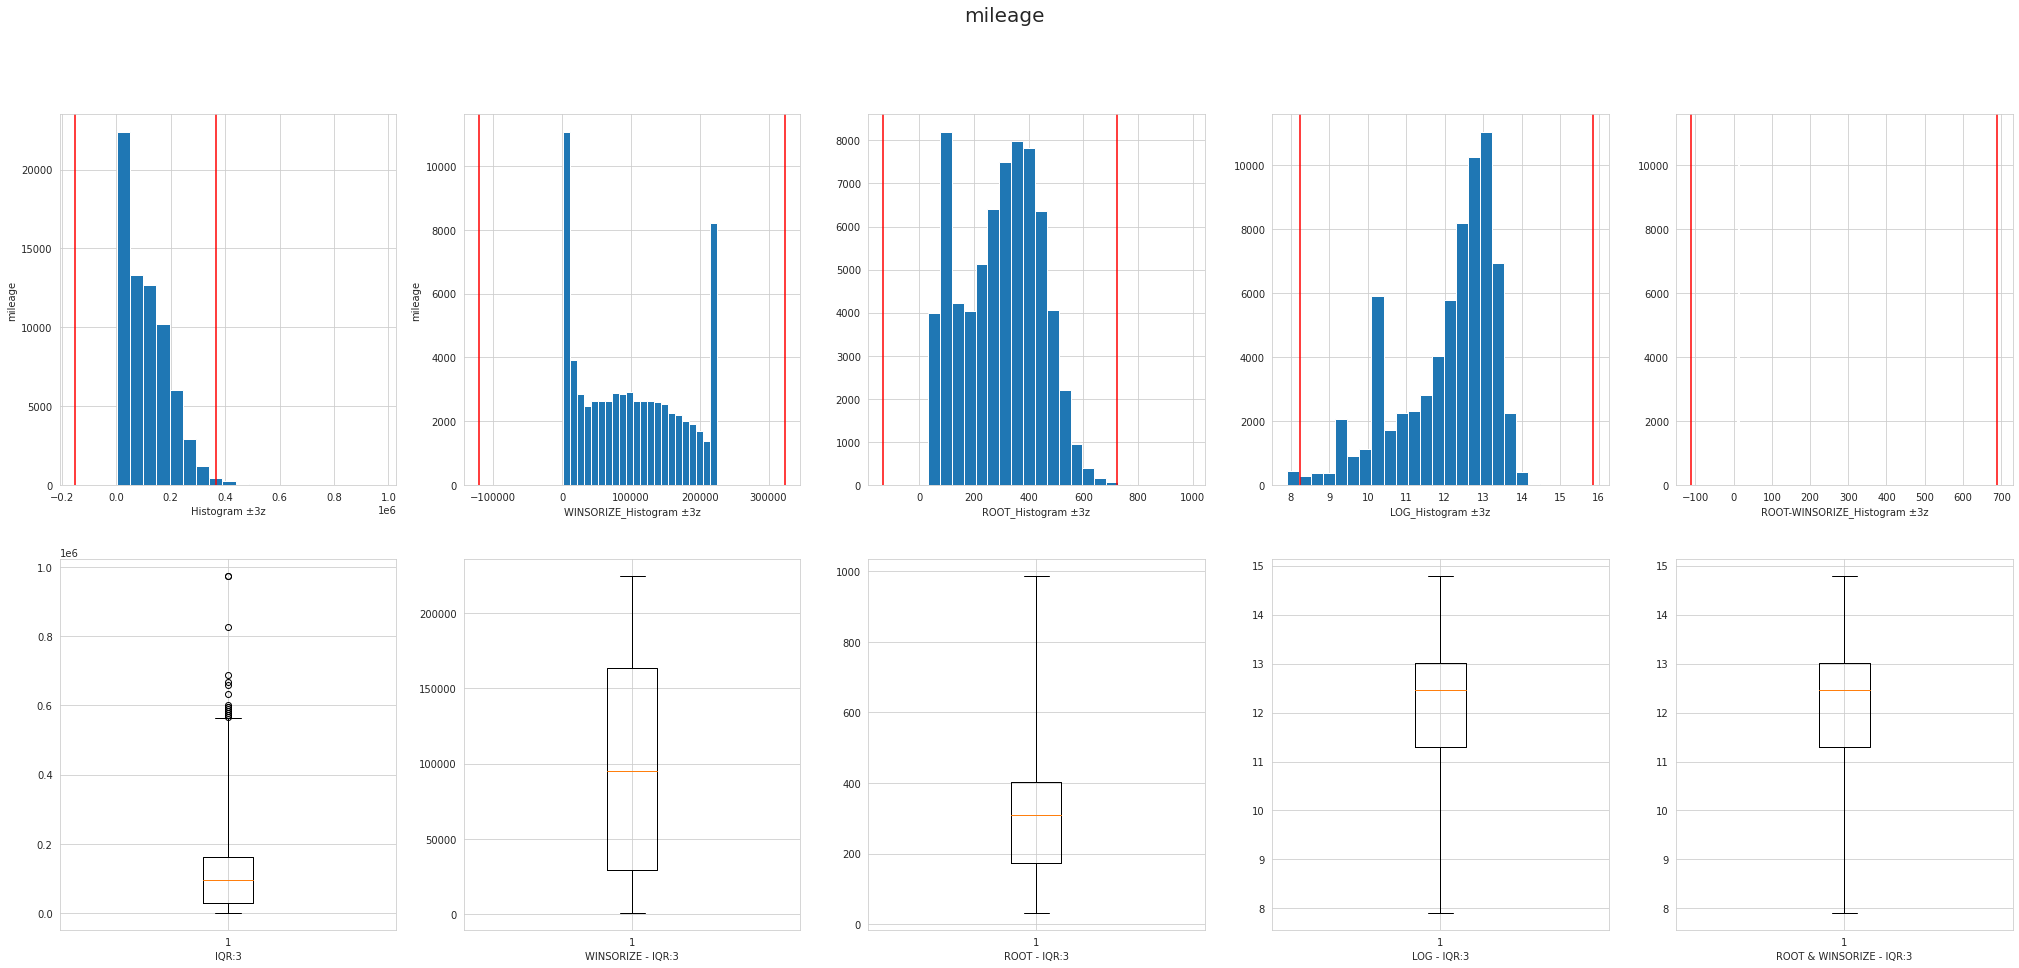

In [ ]:
col_plot(df, "mileage", iqr=3)

In [ ]:
df.mileage.describe()

count     69532.000000
mean     107407.623208
std       86540.429580
min        1000.000000
25%       29766.750000
50%       95000.000000
75%      163240.250000
max      973379.000000
Name: mileage, dtype: float64

In [ ]:
outliers(df.mileage, 1.5)

,count,values
0,IQR,133473.500000
1,Lower Bound,1000.000000
2,Q1,29766.750000
3,Q2,95000.000000
4,Q3,163240.250000
5,Upper Bound,363450.500000
6,Count of Outliers,564.000000
7,Percentage of Outliers,0.008111


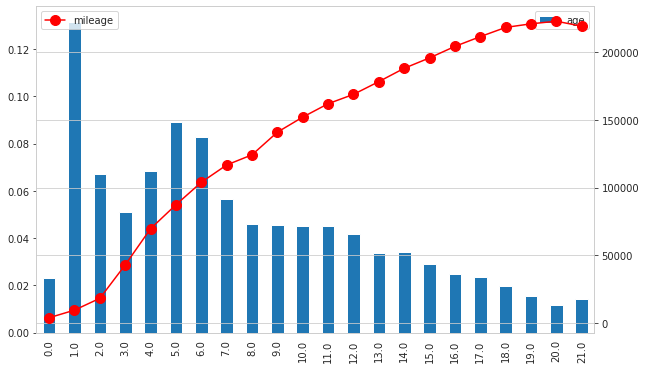

In [ ]:
pol_twin(df,'age','mileage')

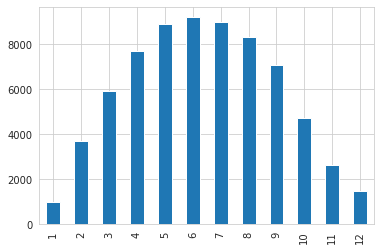

In [ ]:
bins = np.array([0,2500,7000,10000, 33000,68000, 100000, 135000, 170000,210000, 255000, 310000, 10000000])
digitized = np.digitize(df.mileage, bins)
pd.Series(digitized).value_counts().sort_index().plot.bar();

In [ ]:
df.mileage = digitized

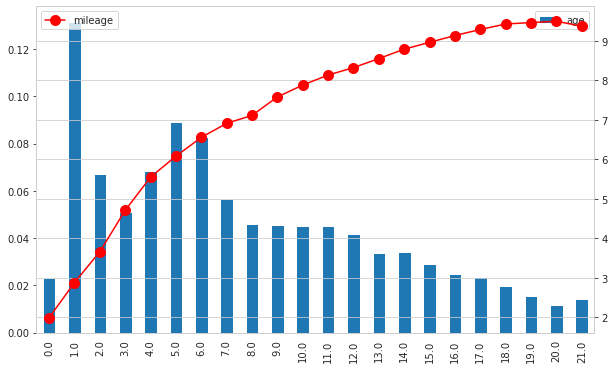

In [ ]:
pol_twin(df,'age','mileage')

In [ ]:
perc_nans(df.mileage)

0.0

## paint

In [ ]:
v_counts(df,"paint")

paint           
            COUNT       RATE
Metallic    49129  70.656676
No Metalic  20403  29.343324

## colour

In [ ]:
v_counts(df,"colour")

colour           
        COUNT       RATE
Grey    23262  33.455100
Black   17918  25.769430
White   10175  14.633550
Blue     8807  12.666111
Red      3225   4.638152
Brown    1903   2.736869
Silver   1853   2.664960
Green     883   1.269919
Beige     570   0.819766
Orange    371   0.533567
Yellow    301   0.432894
Violet    170   0.244492
Other      94   0.135190

## fuel_consumption_mean

In [ ]:
df.fuel_consumption_mean.describe()

count    69532.000000
mean         5.725124
std          2.453607
min          0.000000
25%          4.900000
50%          5.900000
75%          7.000000
max         17.000000
Name: fuel_consumption_mean, dtype: float64

In [ ]:
column_details("", df[['fuel_consumption_mean']])

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

fuel_consumption_mean:  float64, 205, %0.0
[ 0.    3.    3.1   3.2   3.3   3.4   3.5   3.6   3.7   3.8   3.9   4.
  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.6   4.65  4.7
  4.7   4.8   4.8   4.85  4.9   4.95  4.95  5.    5.05  5.1   5.15  5.2
  5.3   5.3   5.35  5.4   5.45  5.5   5.55  5.55  5.6   5.7   5.7   5.75
  5.8   5.8   5.85  5.9   5.95  6.    6.05  6.1   6.15  6.2   6.3   6.3
  6.35  6.4   6.5   6.55  6.6   6.65  6.7   6.7   6.8   6.8   6.85  6.9
  6.95  7.    7.05  7.05  7.1   7.15  7.15  7.2   7.2   7.25  7.3   7.35
  7.4   7.45  7.5   7.55  7.6   7.65  7.7   7.7   7.75  7.8   7.85  7.9
  7.95  7.95  8.    8.05  8.1   8.1   8.15  8.2   8.25  8.3   8.35  8.4
  8.45  8.5   8.6   8.65  8.7   8.8   8.85  8.9   8.9   9.    9.05  9.1
  9.2   9.25  9.3   9.35  9.4   9.5   9.6   9.7   9.8   9.85  9.9   9.95
 10.   10.05 10.1  10.2  10.3  10.4  10.5  10.6  10.6  10.7  10.8  10.9
 11.   11.1  11.2  11.3 

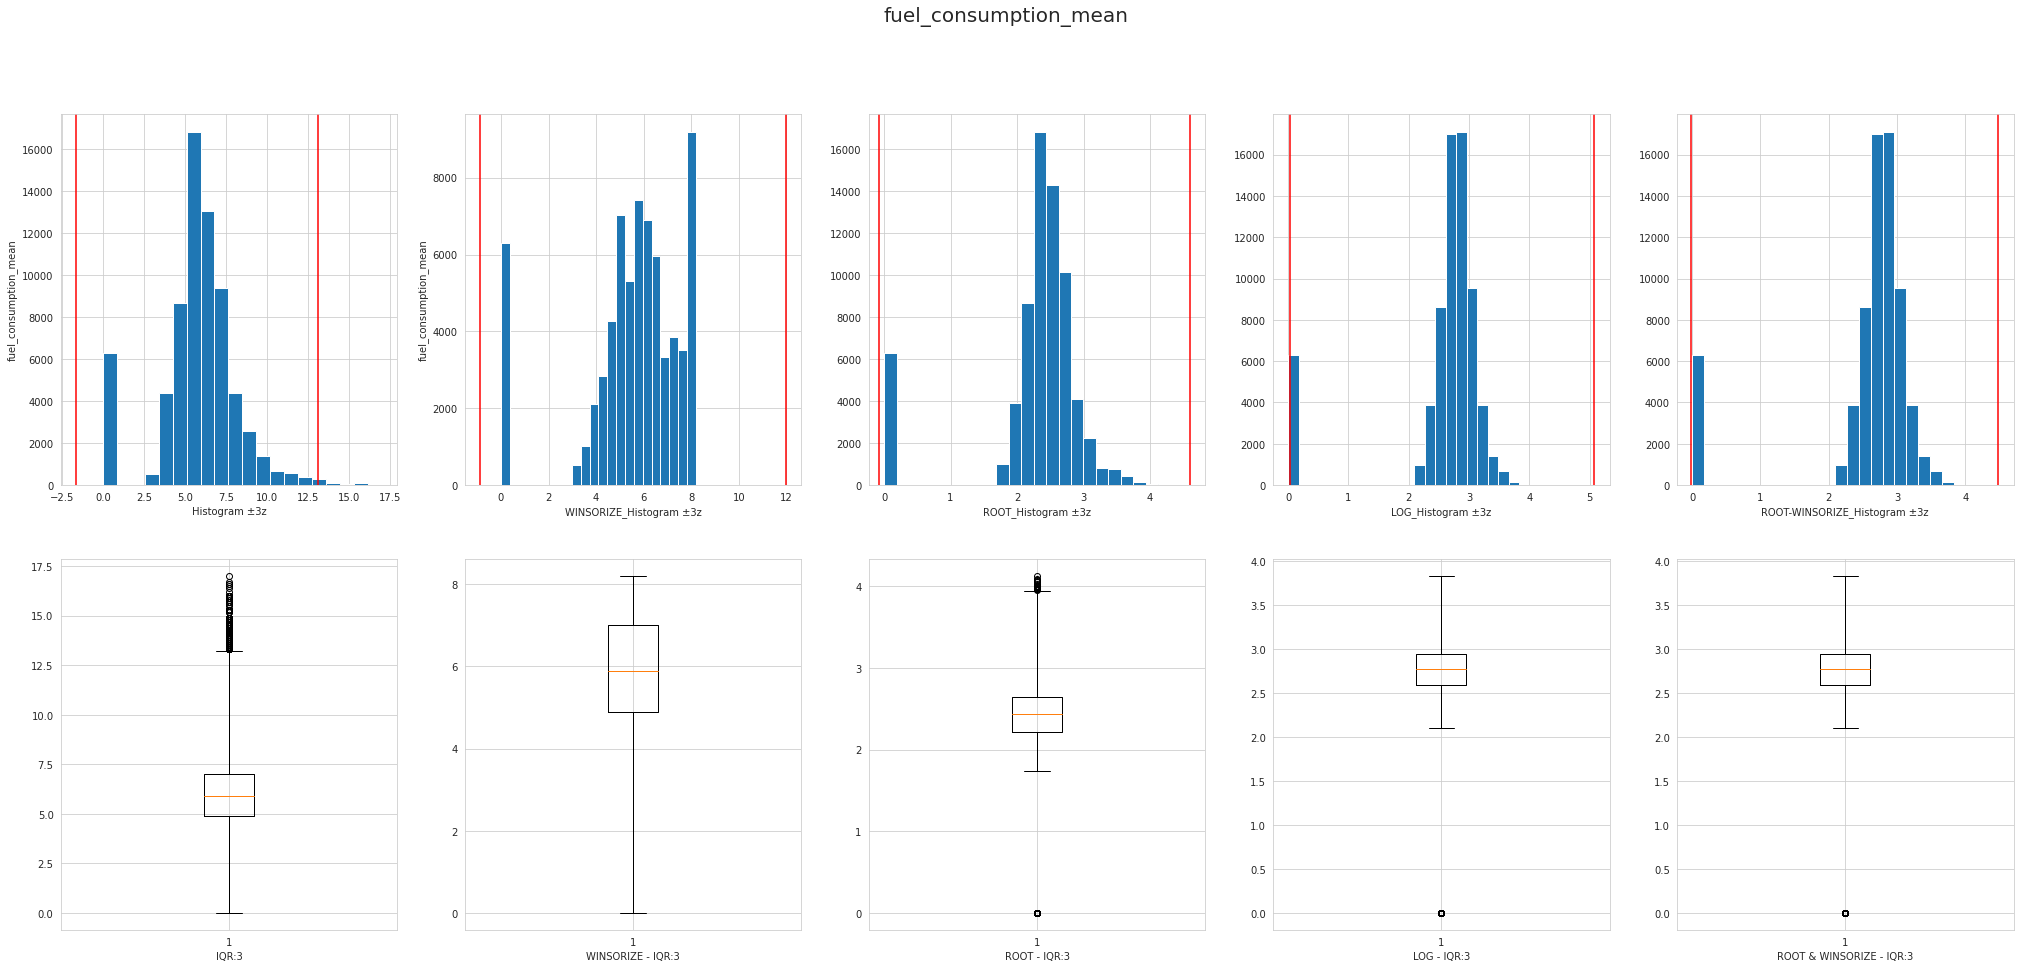

In [ ]:
col_plot(df, "fuel_consumption_mean", iqr=3)

In [ ]:
outliers(df.fuel_consumption_mean, 3)

,count,values
0,IQR,2.100000
1,Lower Bound,0.000000
2,Q1,4.900000
3,Q2,5.900000
4,Q3,7.000000
5,Upper Bound,13.300000
6,Count of Outliers,359.000000
7,Percentage of Outliers,0.005163


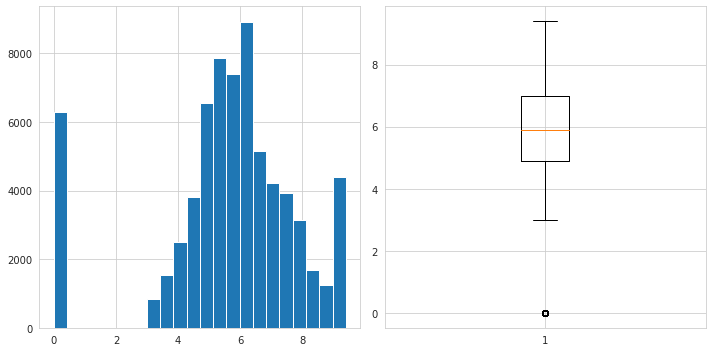

In [ ]:
winsor= winsorize(df.fuel_consumption_mean, (0, 0.05))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(pd.Series(winsor), bins=22)
ax[1].boxplot(pd.Series(winsor))
fig.tight_layout();

In [ ]:
df.fuel_consumption_mean = winsor

In [ ]:
perc_nans(df.fuel_consumption_mean)

0.0

## emission_class

In [ ]:
v_counts(df,"emission_class")

emission_class           
                COUNT       RATE
Euro 6          40143  57.733130
Euro 5          14344  20.629351
Euro 4          11172  16.067422
Euro 3           2321   3.338031
Euro 1           1388   1.996203
Euro 2            164   0.235863

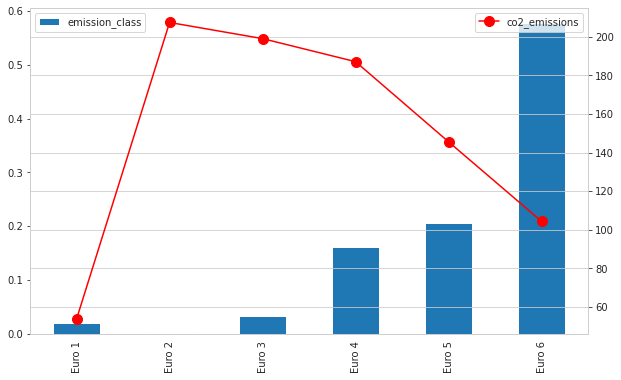

In [ ]:
pol_twin(df,'emission_class','co2_emissions')

## doors

In [ ]:
v_counts(df,"doors")

doors           
   COUNT       RATE
5  51436  73.974573
4   9620  13.835356
2   5829   8.383190
3   2549   3.665938
6     94   0.135190
1      4   0.005753

In [ ]:
simplify_column(df.doors, threshold=0.001, value=2).value_counts(dropna=False)

5    51436
4     9620
2     5833
3     2549
6       94
Name: doors, dtype: int64

In [ ]:
df.doors = simplify_column(df.doors, threshold=0.001, value=2)

## seats

In [ ]:
v_counts(df, "seats")

seats           
   COUNT       RATE
5  56098  80.679399
4   7129  10.252833
2   2531   3.640051
7   2160   3.106483
3   1179   1.695622
6    301   0.432894
8    134   0.192717

## empty_weight

In [ ]:
df.empty_weight.value_counts(dropna=False).sort_index()

1000.0    358
1001.0     13
1002.0     79
1003.0      1
1004.0     41
         ... 
3500.0      5
3647.0      1
3745.0      1
3960.0      1
4200.0      1
Name: empty_weight, Length: 1445, dtype: int64

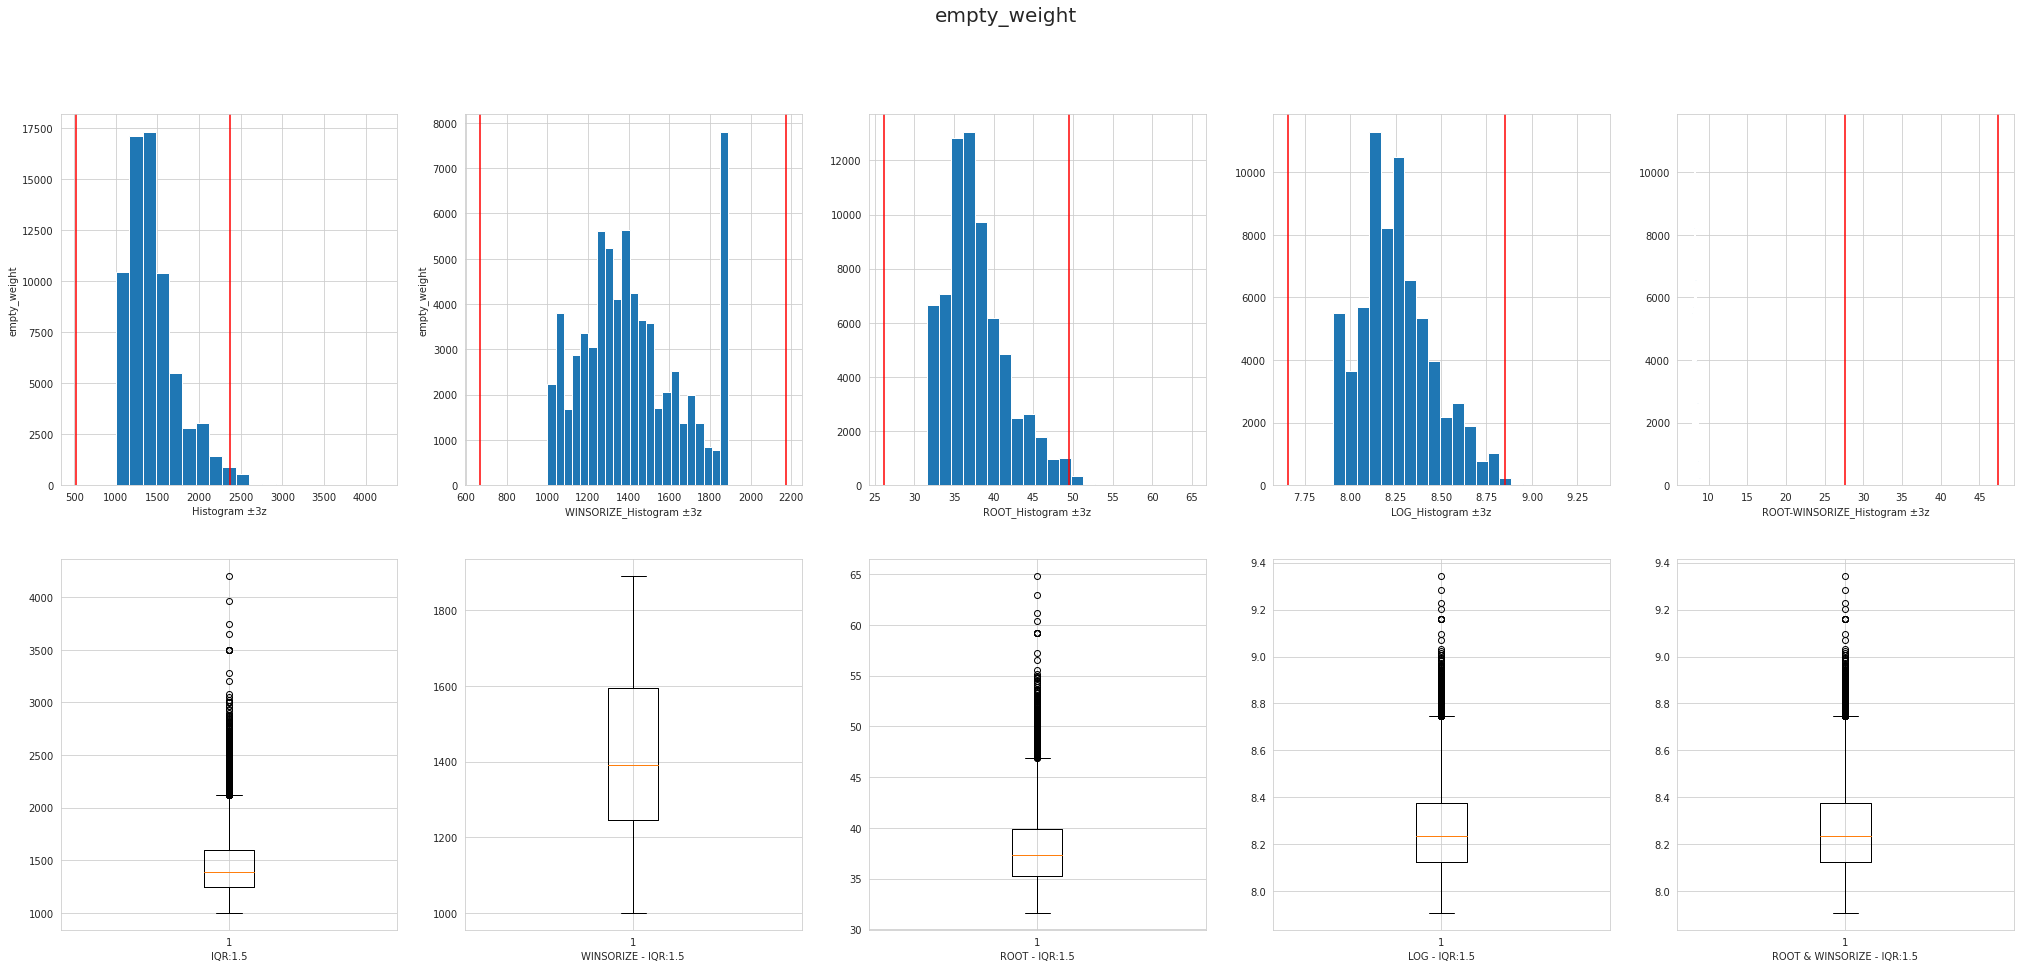

In [ ]:
col_plot(df, "empty_weight", iqr=1.5)

In [ ]:
outliers(df.empty_weight, whisker=1.5)

,count,values
0,IQR,350.000000
1,Lower Bound,1000.000000
2,Q1,1245.000000
3,Q2,1390.000000
4,Q3,1595.000000
5,Upper Bound,2120.000000
6,Count of Outliers,2918.000000
7,Percentage of Outliers,0.041966


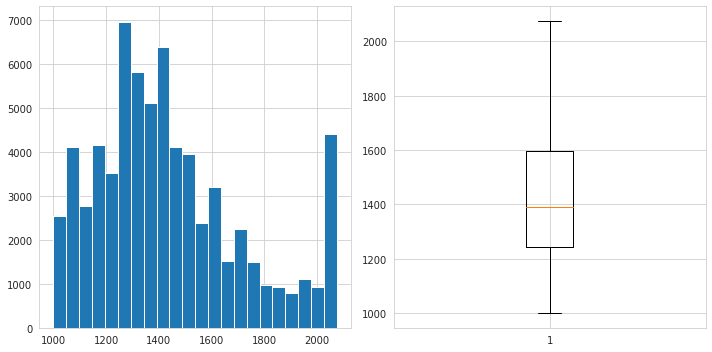

In [ ]:
winsor= winsorize(df.empty_weight, (0, 0.05))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(pd.Series(winsor), bins=22)
ax[1].boxplot(pd.Series(winsor), whis=1.5)
fig.tight_layout();

- winsorizarion can be a good solution for eliminating outliers. But I will prefer another solution.

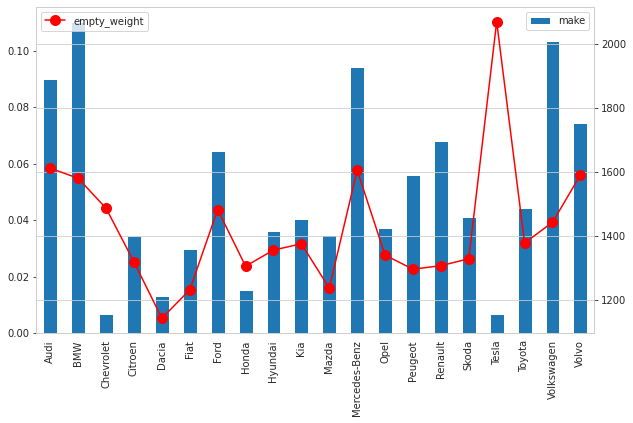

In [ ]:
pol_twin(df,'make','empty_weight')

In [ ]:
df.empty_weight.describe()

count    69532.000000
mean      1447.042527
std        308.594888
min       1000.000000
25%       1245.000000
50%       1390.000000
75%       1595.000000
max       4200.000000
Name: empty_weight, dtype: float64

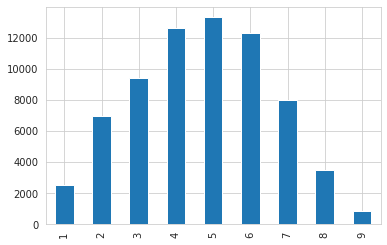

In [ ]:
bins = np.array([900, 1050, 1150, 1260, 1360, 1480, 1700, 2030, 2400, 4500])
digitized = np.digitize(df.empty_weight, bins)
pd.Series(digitized).value_counts().sort_index().plot.bar();

In [ ]:
df.empty_weight = digitized

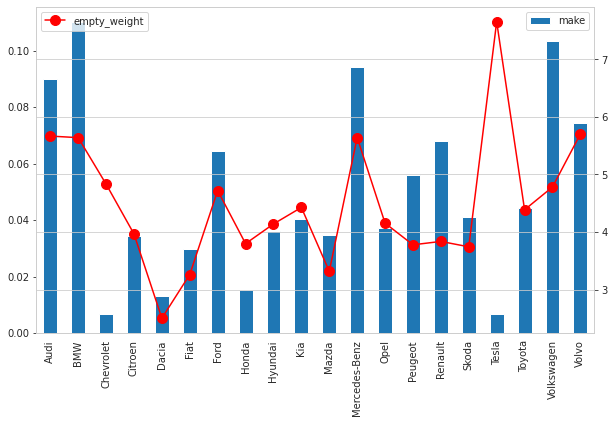

In [ ]:
pol_twin(df,'make','empty_weight')

## co2_emission

In [ ]:
df[df.co2_emissions==0]['fuel_type'].value_counts()

Electric    5479
Diesel         7
Gasoline       3
Others         1
Name: fuel_type, dtype: int64

In [ ]:
df.loc[df[(df.fuel_type=='Diesel')&(df.co2_emissions==0)].index,'co2_emissions'] = df[df.fuel_type=='Diesel']['co2_emissions'].median()
df.loc[df[(df.fuel_type=='Gasoline')&(df.co2_emissions==0)].index,'co2_emissions'] = df[df.fuel_type=='Gasoline']['co2_emissions'].median()
df.loc[df[(df.fuel_type=='Others')&(df.co2_emissions==0)].index,'co2_emissions'] = df[df.fuel_type=='Others']['co2_emissions'].median()

In [ ]:
df[df.co2_emissions==0]['fuel_type'].value_counts(dropna=False)

Electric    5479
Name: fuel_type, dtype: int64

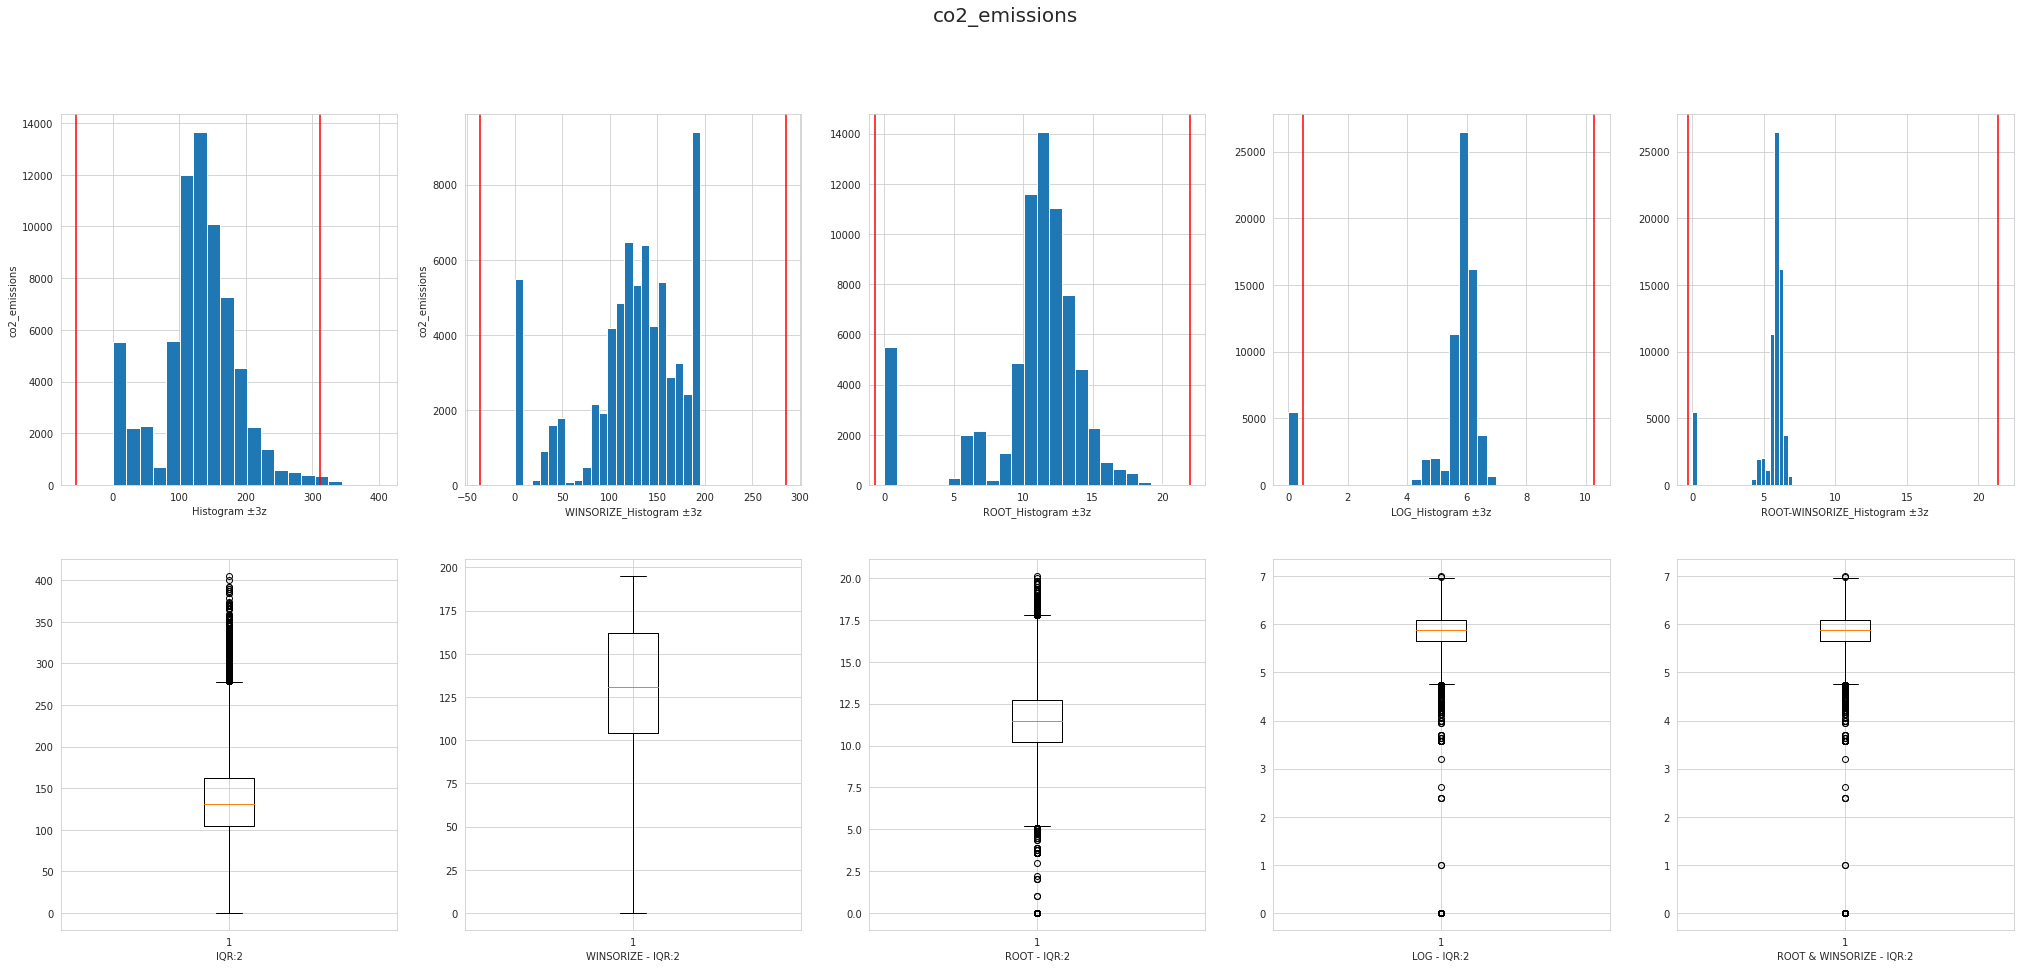

In [ ]:
col_plot(df, "co2_emissions", iqr=2)

In [ ]:
v_counts(df,"fuel_type")

fuel_type           
             COUNT       RATE
Gasoline     40771  58.636311
Diesel       13051  18.769775
Hybrit        9442  13.579359
Electric      5479   7.879825
LPG            707   1.016798
Others          82   0.117931

In [ ]:
outliers(df.co2_emissions, whisker=3.5)

,count,values
0,IQR,58.000000
1,Lower Bound,0.000000
2,Q1,104.000000
3,Q2,131.000000
4,Q3,162.000000
5,Upper Bound,365.000000
6,Count of Outliers,52.000000
7,Percentage of Outliers,0.000748


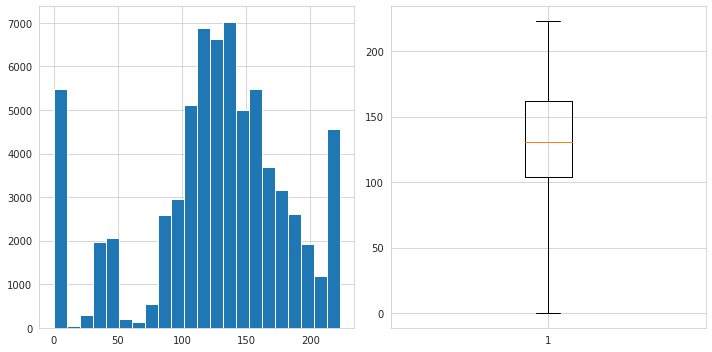

In [ ]:
winsor= winsorize(df.co2_emissions, (0, 0.05))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(pd.Series(winsor), bins=22)
ax[1].boxplot(pd.Series(winsor), whis=2)
fig.tight_layout();

In [ ]:
df.co2_emissions = winsor

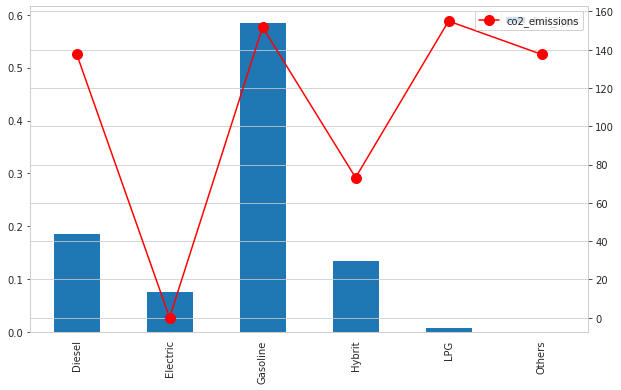

In [ ]:
pol_twin(df,'fuel_type','co2_emissions')

In [ ]:
perc_nans(df.co2_emissions)

0.0

## province

In [ ]:
v_counts(df,'province')

province           
                 COUNT       RATE
Gelderland       13164  18.932290
North Brabant    12123  17.435138
South Holland     9378  13.487315
North Holland     7982  11.479607
Utrecht           7709  11.086982
Overijssel        3888   5.591670
Limburg           3689   5.305471
Friesland         3303   4.750331
Drenthe           3111   4.474199
Flevoland         2344   3.371110
Groningen         1507   2.167347
Zeeland           1334   1.918541

In [ ]:
pr = v_counts(df,'province').reset_index()
pr.columns =pr.columns.droplevel()
pr = pr.rename(columns={'':'province'})
pr = pr.replace({'North Brabant':'Noord-Brabant','South Holland':'Zuid-Holland','North Holland':'Noord-Holland'})
pr

,province,COUNT,RATE
0,Gelderland,13164,18.932290
1,Noord-Brabant,12123,17.435138
2,Zuid-Holland,9378,13.487315
3,Noord-Holland,7982,11.479607
4,Utrecht,7709,11.086982
5,Overijssel,3888,5.591670
6,Limburg,3689,5.305471
7,Friesland,3303,4.750331
8,Drenthe,3111,4.474199
9,Flevoland,2344,3.371110


In [ ]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 27.1 MB/s 
     |████████████████████████████████| 16.7 MB 403 kB/s 
     |████████████████████████████████| 6.3 MB 68.0 MB/s 


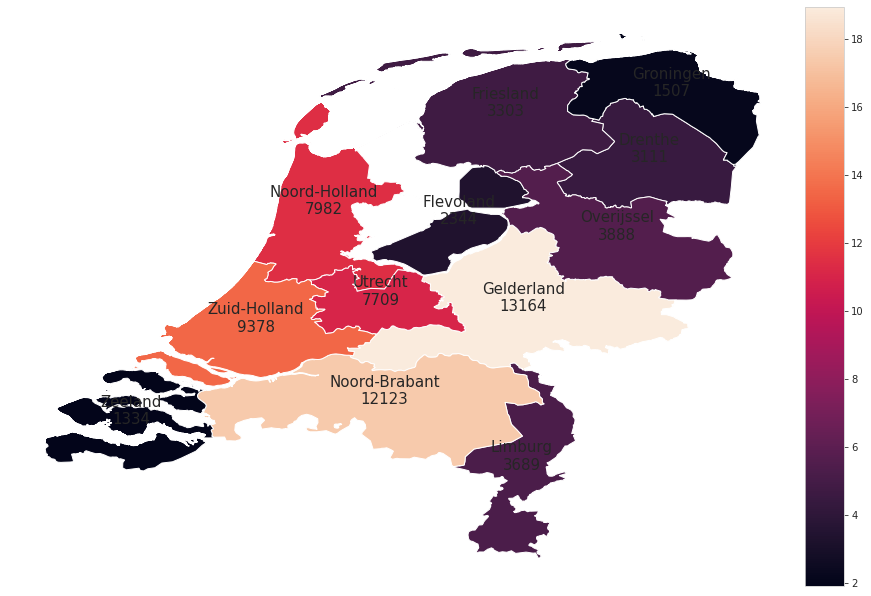

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

mapdf = gpd.read_file("https://stacks.stanford.edu/file/druid:st293bj4601/data.zip")

mapdf = mapdf[mapdf["TYPE_1"] == "Provincie"]
mapdf.sort_values("NAME_1", inplace=True)
mapdf = mapdf.reset_index(drop=True)
map_df = gpd.GeoDataFrame(mapdf.merge(pr, left_on='NAME_1', right_on='province', how='left'))
map_df['annotate'] = map_df[['NAME_1','COUNT']].apply(lambda x: x[0]+'\n'+str(x[1]), axis=1)
fig, ax = plt.subplots(1,figsize=(15,15))
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1)
map_df.plot(column="RATE", ax=ax, legend=True, cax=cax)
ax.axis('off')
map_df.apply(lambda x: ax.annotate(s=x['annotate'], xy=x.geometry.centroid.coords[0], ha='center',size=15), axis=1);

## model

In [ ]:
cramers_v(df.make_model, df.model)

0.9998472966036406

In [ ]:
df = df.drop(['model'], axis=1)

## make_model

In [ ]:
df.make_model.nunique()

787

In [ ]:
df.make_model.value_counts()

Audi A3                     1297
Renault Megane              1033
Volkswagen Golf             1025
Ford Focus                   939
Audi A4                      922
                            ... 
Volkswagen T5 California       1
Skoda Others                   1
Volkswagen XL1                 1
Skoda Felicia                  1
Toyota Paseo                   1
Name: make_model, Length: 787, dtype: int64

In [ ]:
s = df.make_model.value_counts()
car_make_models = s.where(s >= 30).dropna().index
df = df[df.make_model.isin(car_make_models)]

In [ ]:
df.make_model.nunique()

359

In [ ]:
df.make_model.value_counts()

Audi A3                     1297
Renault Megane              1033
Volkswagen Golf             1025
Ford Focus                   939
Audi A4                      922
                            ... 
Mercedes-Benz GLA 45 AMG      30
Opel Antara                   30
Citroen C2                    30
Hyundai Getz                  30
Ford Focus CC                 30
Name: make_model, Length: 359, dtype: int64

## dummy columns

In [ ]:
dummy_columns = list(filter(lambda x: re.match('^\w\w_',x), df.columns))
len(dummy_columns)

131

In [ ]:
df[dummy_columns].sum().sort_values(ascending=False)

cc_Air conditioning         63890
ss_Driver-side airbag       63241
ss_ABS                      62366
ss_Passenger-side airbag    61619
cc_Power windows            60177
                            ...  
ex_Biodiesel conversion        37
cc_Park Distance Control        9
ex_Awning                       8
cc_Leather seats                4
ex_Double cabin                 0
Length: 131, dtype: int64

In [ ]:
s = (df[dummy_columns].sum().sort_values(ascending=False)/df[dummy_columns].shape[0])
drop_list = s.where(s < 0.001).dropna().index
drop_list

Index(['ex_Biodiesel conversion', 'cc_Park Distance Control', 'ex_Awning', 'cc_Leather seats', 'ex_Double cabin'], dtype='object')

In [ ]:
df = df.drop(drop_list, axis=1)

In [ ]:
df[set(dummy_columns).difference(drop_list)].sum().sort_values(ascending=False)

cc_Air conditioning                     63890
ss_Driver-side airbag                   63241
ss_ABS                                  62366
ss_Passenger-side airbag                61619
cc_Power windows                        60177
                                        ...  
cc_Massage seats                          167
ex_Handicapped enabled                    155
ex_Sliding door                           154
cc_Automatic climate control 4 zones      151
ex_Range extender                          89
Length: 126, dtype: int64

## SAVE_5

In [ ]:
df.to_pickle('/content/drive/MyDrive/Colab Notebooks/AutoScout24/backup_5.pkl')

In [ ]:
df= pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/AutoScout24/backup_5.pkl')

## Encodings

In [ ]:
df.head(2)

,make,price,mileage,gearbox,fuel_type,power,seller,body_type,type,drivetrain,seats,doors,warranty,full_service_history,non_smoker_vehicle,engine_size,gears,cylinders,empty_weight,co2_emissions,emission_class,colour,paint,upholstery_colour,upholstery,inspection_new,fuel_consumption_mean,make_model,age,make_country,province,cc_360° camera,cc_Air conditioning,cc_Air suspension,cc_Armrest,cc_Automatic climate control,cc_Automatic climate control 2 zones,cc_Automatic climate control 3 zones,cc_Automatic climate control 4 zones,cc_Auxiliary heating,cc_Cruise control,cc_Electric backseat adjustment,cc_Electric tailgate,cc_Electrical side mirrors,cc_Electrically adjustable seats,cc_Electrically heated windshield,cc_Fold flat passenger seat,cc_Heads-up display,cc_Heated steering wheel,cc_Hill Holder,...,ss_Head airbag,ss_High beam assist,ss_Immobilizer,ss_Isofix,ss_LED Daytime Running Lights,ss_LED Headlights,ss_Lane departure warning system,ss_Laser headlights,ss_Night view assist,ss_Passenger-side airbag,ss_Power steering,ss_Rear airbag,ss_Side airbag,ss_Speed limit control system,ss_Tire pressure monitoring system,ss_Traction control,ss_Traffic sign recognition,ss_Xenon headlights,ex_All season tyres,ex_Alloy wheels,ex_Ambient lighting,ex_Automatically dimming interior mirror,ex_Cargo barrier,ex_Catalytic Converter,ex_E10-enabled,ex_Electronic parking brake,ex_Emergency tyre,ex_Emergency tyre repair kit,ex_Handicapped enabled,ex_Headlight washer system,ex_Range extender,ex_Right hand drive,ex_Roof rack,ex_Shift paddles,ex_Ski bag,ex_Sliding door,ex_Smokers package,ex_Spare tyre,ex_Spoiler,ex_Sport package,ex_Sport seats,ex_Sport suspension,ex_Steel wheels,ex_Summer tyres,ex_Touch screen,ex_Trailer hitch,ex_Tuned car,ex_Voice Control,ex_Winter package,ex_Winter tyres
0,Audi,4450.0,9,Automatic,Gasoline,150.0,Dealer,Compact,Used,Front,5,3,6.0,Yes,No,1984.0,6.0,4.0,4,119.0,Euro 4,Grey,Metallic,Black,Cloth,1.0,5.2,Audi A3,19.0,Germany,North Brabant,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Audi,12950.0,6,Automatic,Gasoline,125.0,Dealer,Compact,Used,Front,5,5,0.0,Yes,No,1395.0,6.0,4.0,3,119.0,Euro 6,White,No Metalic,Black,Cloth,0.0,4.9,Audi A3,9.0,Germany,North Brabant,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encode_cols= ['make_model']

one_hot_encode_cols=['province','make','make_country','fuel_type','body_type','type','emission_class','colour','upholstery_colour','inspection_new',
                     'full_service_history','non_smoker_vehicle','gearbox','seller','drivetrain','upholstery','paint']

numeric_cols= set(df.columns) -  set(label_encode_cols) - set(one_hot_encode_cols)
filtered_cols = set(numeric_cols) - set(filter(lambda v: re.match('^\w\w_', v), numeric_cols)) # subtract dummy columns from numeric columns.

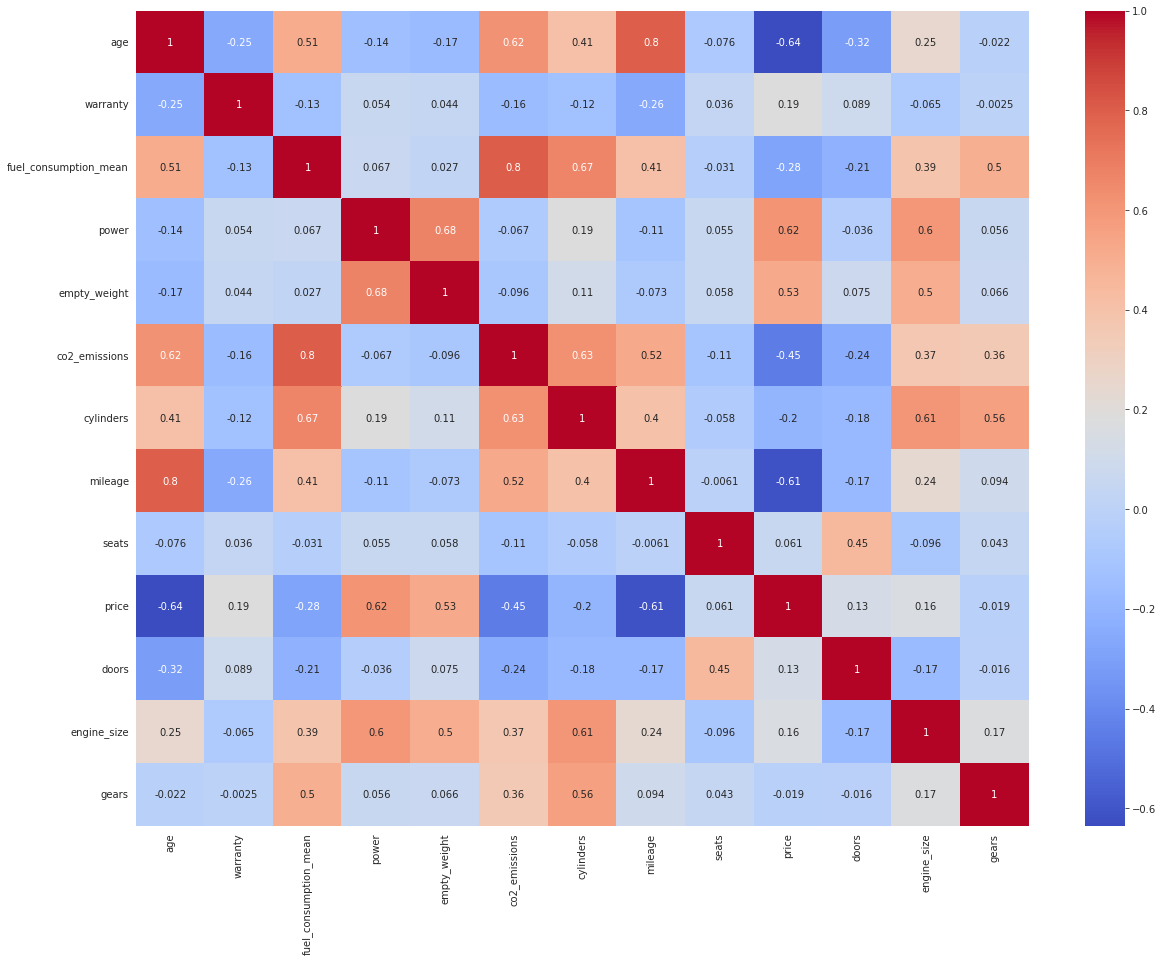

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(df[filtered_cols].corr(), cmap='coolwarm',annot=True);

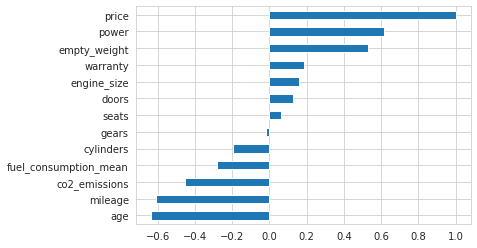

In [ ]:
df[filtered_cols].corr()["price"].sort_values().plot.barh();

In [ ]:
df[label_encode_cols] = df[label_encode_cols].apply(LabelEncoder().fit_transform)
# df[one_hot_encode_cols] = df[one_hot_encode_cols].apply(OneHotEncoder().fit_transform)

df = pd.get_dummies(df, drop_first=True)

In [ ]:
column_details(regex='', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

price:  float64, 8486, %0.0
[1.00000e+00 2.00000e+00 2.39000e+02 ... 2.34950e+05 3.06894e+05
 9.99999e+05]

mileage:  int64, 12, %0.0
[ 1  2  3  4  5  6  7  8  9 10 11 12]

power:  float64, 339, %0.0
[ 54.   56.   57.   58.   60.   61.   63.   64.   65.   67.   68.   69.
  71.   72.   73.   75.   76.   77.   79.   80.   82.   83.   84.   86.
  87.   88.   90.   91.   92.   94.   95.   97.   98.   99.  101.  102.
 103.  105.  106.  107.  109.  110.  111.  113.  113.5 114.  116.  117.
 118.  120.  120.5 121.  122.  124.  125.  126.  128.  128.5 129.  131.
 132.  133.  135.  136.  137.  139.  140.  141.  143.  144.  145.  147.
 148.  150.  151.  152.  154.  155.  156.  158.  159.  160.  162.  163.
 165.  166.  167.  169.  170.  171.  173.  174.  174.5 175.  177.  178.
 179.  180.  181.  182.  184.  184.5 185.  186.  187.  188.  189.  190.
 192.  193.  194.  196.  197.  199.  200.  201.  203.  204.  205.  207.
 208.  209.  

In [ ]:
null_values(df, rate=0)

,Missing_Records,Percentage (%)


In [ ]:
df.shape

(66094, 224)

## Categorical Correlation

In [ ]:
dummy_columns = [col for col in df.columns if re.search('^\w\w_', col)]

In [ ]:
corrank(df[dummy_columns],0.7)

,Feature1,Feature2,corr
0,em_Android Auto,em_Apple CarPlay,0.95
1,ss_Daytime running lights,ss_LED Daytime Running Lights,0.93
2,ss_Driver-side airbag,ss_Passenger-side airbag,0.77
3,ss_Central door lock,ss_Central door lock with remote control,0.73
4,ss_Bi-Xenon headlights,ss_Xenon headlights,0.71


In [ ]:
df.head(1)

,price,mileage,power,seats,doors,warranty,engine_size,gears,cylinders,empty_weight,co2_emissions,inspection_new,fuel_consumption_mean,make_model,age,cc_360° camera,cc_Air conditioning,cc_Air suspension,cc_Armrest,cc_Automatic climate control,cc_Automatic climate control 2 zones,cc_Automatic climate control 3 zones,cc_Automatic climate control 4 zones,cc_Auxiliary heating,cc_Cruise control,cc_Electric backseat adjustment,cc_Electric tailgate,cc_Electrical side mirrors,cc_Electrically adjustable seats,cc_Electrically heated windshield,cc_Fold flat passenger seat,cc_Heads-up display,cc_Heated steering wheel,cc_Hill Holder,cc_Keyless central door lock,cc_Leather steering wheel,cc_Light sensor,cc_Lumbar support,cc_Massage seats,cc_Multi-function steering wheel,cc_Navigation system,cc_Panorama roof,cc_Parking assist system camera,cc_Parking assist system self-steering,cc_Parking assist system sensors front,cc_Parking assist system sensors rear,cc_Power windows,cc_Rain sensor,cc_Seat heating,cc_Seat ventilation,...,type_New,type_Pre-registered,type_Used,drivetrain_Front,drivetrain_Rear,full_service_history_Yes,non_smoker_vehicle_Yes,emission_class_Euro 2,emission_class_Euro 3,emission_class_Euro 4,emission_class_Euro 5,emission_class_Euro 6,colour_Black,colour_Blue,colour_Brown,colour_Green,colour_Grey,colour_Orange,colour_Other,colour_Red,colour_Silver,colour_Violet,colour_White,colour_Yellow,paint_No Metalic,upholstery_colour_Black,upholstery_colour_Blue,upholstery_colour_Brown,upholstery_colour_Grey,upholstery_colour_Other,upholstery_colour_Red,upholstery_colour_White,upholstery_Part/Full Leather,make_country_Germany,make_country_Italy,make_country_Japan,make_country_Korea,make_country_Sweden,make_country_USA,province_Flevoland,province_Friesland,province_Gelderland,province_Groningen,province_Limburg,province_North Brabant,province_North Holland,province_Overijssel,province_South Holland,province_Utrecht,province_Zeeland
0,4450.0,9,150.0,5,3,6.0,1984.0,6.0,4.0,4,119.0,1.0,5.2,1,19.0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
corrank(df.loc[:,'gearbox_Manual':],0.5)

,Feature1,Feature2,corr
0,type_New,type_Used,0.72
1,upholstery_colour_Black,upholstery_colour_Grey,0.69
2,drivetrain_Front,drivetrain_Rear,0.67
3,emission_class_Euro 5,emission_class_Euro 6,0.61
4,emission_class_Euro 4,emission_class_Euro 6,0.51


In [ ]:
droplist=['em_Apple CarPlay','ss_LED Daytime Running Lights']
df.drop(droplist, axis = 1, inplace=True)

In [ ]:
show_nans(df, limit=0.01)

Series([], dtype: float64)

## CHECK DUPLICATES

In [ ]:
df.shape

(66094, 222)

In [ ]:
df.duplicated().sum()

400

In [ ]:
df = df.drop_duplicates()
df.shape

(65694, 222)

## SAVE_FINAL

In [ ]:
df.to_pickle('/content/drive/MyDrive/Colab Notebooks/AutoScout24/backup_final.pkl')

# Descriptional Statistical Analysis

In [ ]:
df= pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/AutoScout24/backup_5.pkl')

- en cok ilana konulan markalar

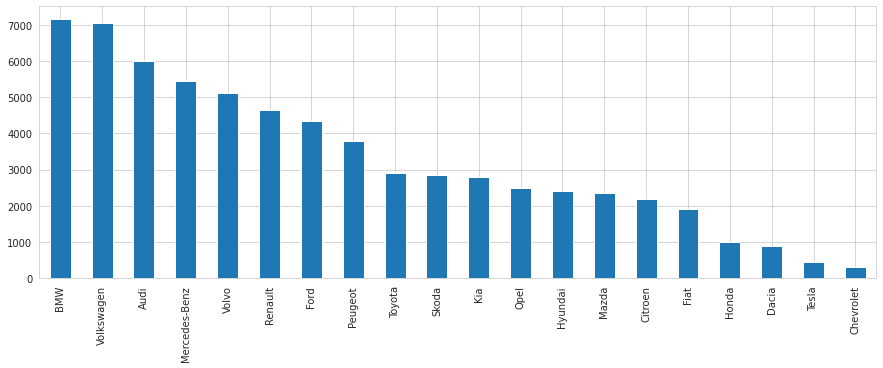

In [ ]:
df.make.value_counts().plot.bar(figsize=(15,5));

- en cok ilana konulan ilk 20 araba modelleri

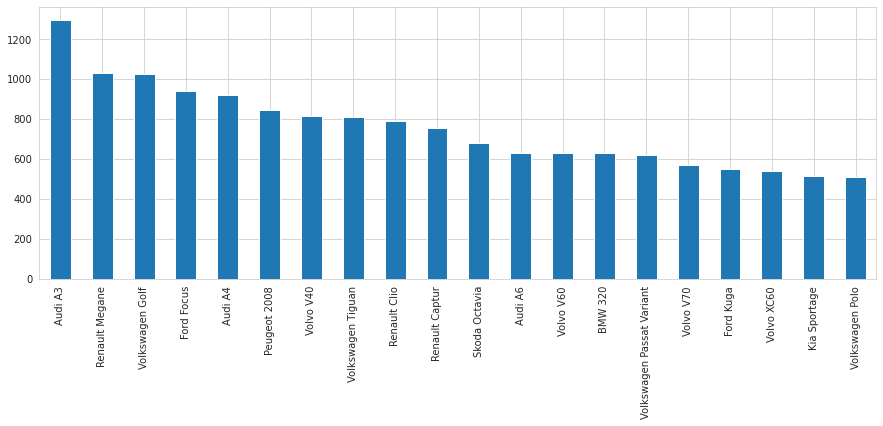

In [ ]:
df.make_model.value_counts()[:20].plot.bar(figsize=(15,5));

- vites tipine gore ilana konulan arac ilan sayisi frekanslari

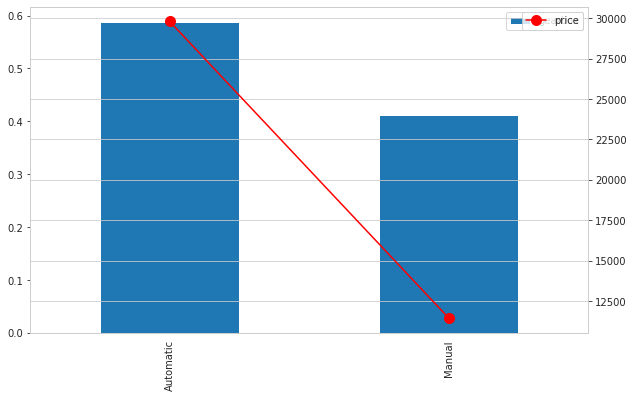

In [ ]:
pol_twin(df,'gearbox','price')

- yakit tipne gore ilana konulan arac ilan sayisi frekanslari

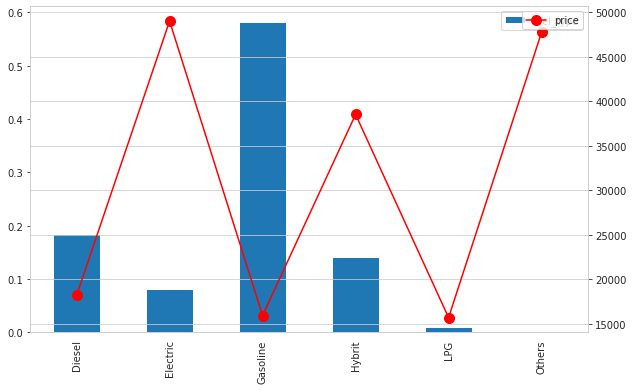

In [ ]:
pol_twin(df,'fuel_type','price')


- markaya gore fiyat ortalamalarinin grafigi.

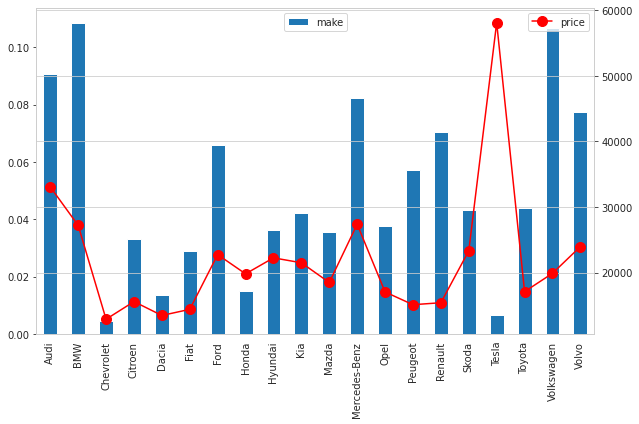

In [ ]:
pol_twin(df,'make','price')

- yasa gore km ortalamalarinin grafigi

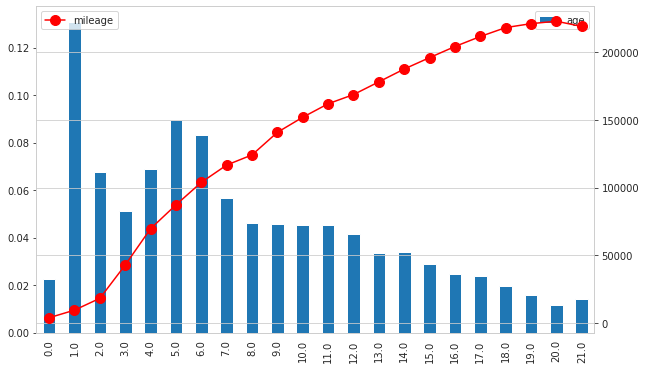

- yakit turune gore CO2 salinimi grafigi

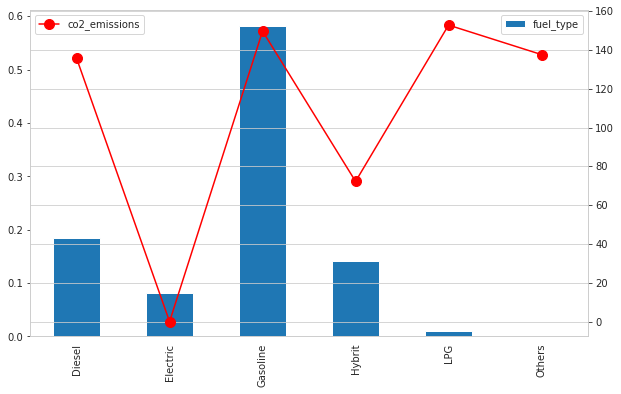

In [ ]:
pol_twin(df,'fuel_type','co2_emissions')

- yas+fiyat endeksi

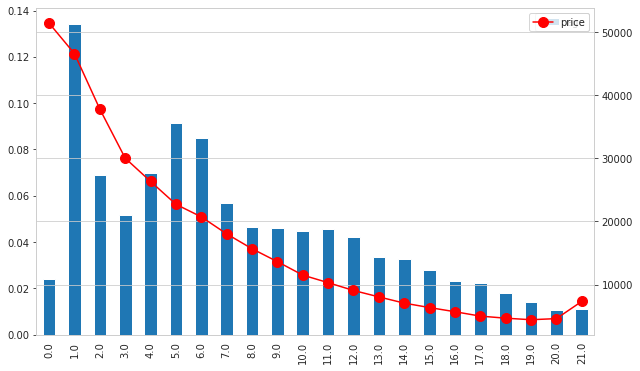

In [ ]:
pol_twin(df,'age','price')

- eyalete gore ilana verilen arac grafigi

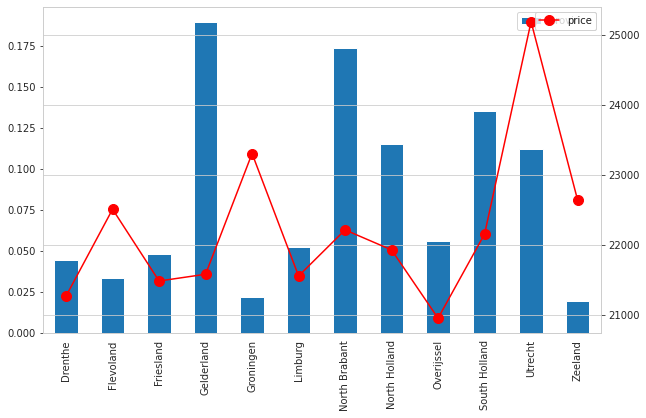

In [ ]:
pol_twin(df,'province','price')

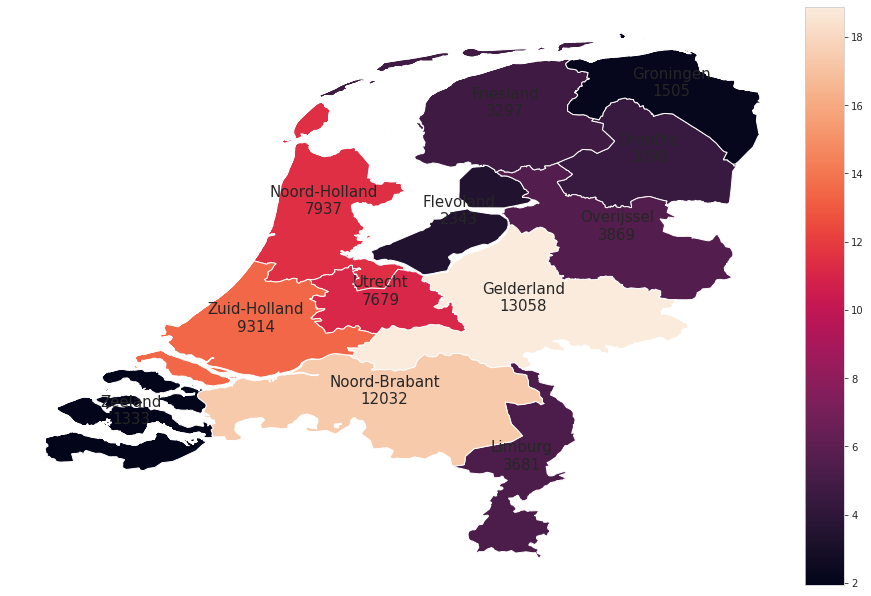

- markalara gore ortalama yakit tuketimi

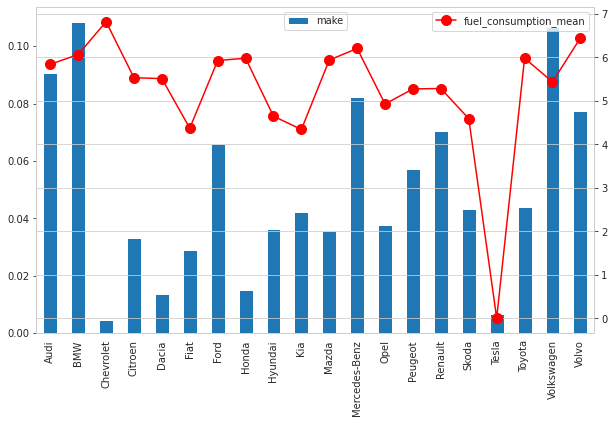

In [ ]:
pol_twin(df,'make','fuel_consumption_mean')

- markaya gore HP ortalamasi

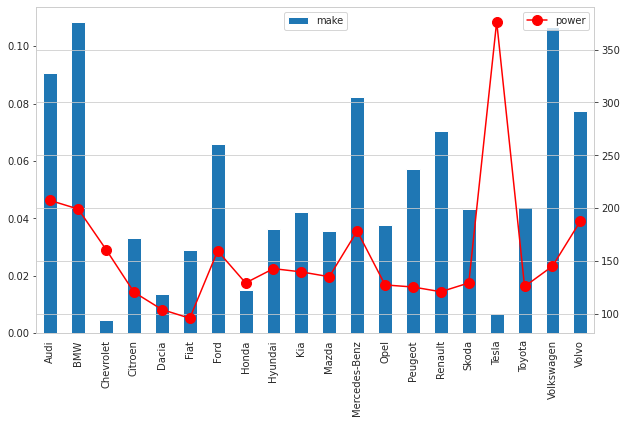

In [ ]:
pol_twin(df,'make','power')

- markaya gore arac agirligi grafigi

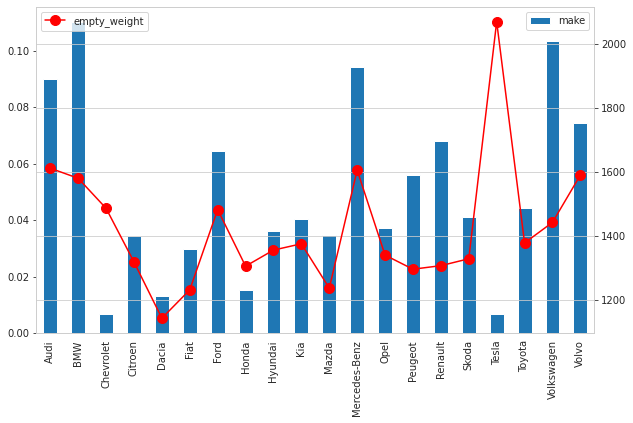